> Notebook com o treinamento dos modelos de ML para a classificação do label ob

---

1) excluir os casos de pele não melanoma (CID-O CID44 com as morfologias entre 80101 e 81103); ok

2) não utilizar as datas de recidiva (na ficha de seguimento há sobreposição); ok

3) a variável Cidade de residência (transformada em  RRAS - Rede Regional de Atenção à Saúde) relacionada com RRAS de atendimento (o valor 99 é ignorado);

4) Na questão de predição do óbito, sugiro que o comportamento 1 e 2 não sejam interessantes para a análise. Ao se observar a coluna MORFO o último dígito 1, 2 ou 3 faz referencia ao comportamento do tumor, por exemplo, 80503 = ductal invasivo. Os últimos dígitos 1 são incerto se benigno ou limítrofe e 2 carcinoma in situ.
Minha sugestão é gerar uma variável chamada comportamento e deixar só o comportamento 3 para certas análises; ok

5) trabalhar com o ano do diagnóstico agrupado é uma boa opção. O câncer não sofre mudanças abruptas ao longo do tempo e controlar por períodos de diagnóstico pode ser mais vantajoso (2000 - 2004; 2005 - 2009; 2010 - 2015). ok

6) não me recordo se os estadiamentos X e Y foram retirados, mas não devem ser trabalhados; ok

7) EC e ECGRUP dizem quase a mesma coisa. Talvez verificar o melhor preditor e usar para o modelo; ok

8) quanto a variável metástase e recidiva a distancia, deveriam estar preenchidas de forma homogênea, assim sugiro usar as informações de recidiva à distância;

9) o tempo entre o diagnóstico e o tratamento ou consulta e o tratamento devem ser recalculados (foi refeito, eu me recordo) e retirados das análise aqueles que não tiveram a possibilidade de serem tratados; ok

10) nesta base, a última coluna está preenchida com as habilitações para o tratamento CACON e UNACON. ok

# **Libraries**

Import of all libraries used in the project. 

In [1]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle # Save models
seed = 10 # seed for the random state

In [2]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Classification
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc

In [4]:
from sklearn.model_selection import RandomizedSearchCV

In [5]:
from sklearn import tree

In [6]:
!pip install shap --quiet

import shap

     |████████████████████████████████| 569 kB 4.4 MB/s 


# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

In [7]:
%%capture

# !pip install --upgrade --no-cache-dir gdown
!gdown 15TI1DRr9rMQOoNmn8S44D55Ek99m4kaZ

In [8]:
from functions import *

# **Introduction**

In this section, two machine learning models will be used to classify the `obito_geral` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died.

Four scenarios will be created using the column `obito_geral` as label. The first is the raw data for São Paulo and other states, as was generated in the previous section. The second scenario considers only patients with morphology with the last digit being 3, in addition, the `EC` column was removed.

The third and fourth scenarios use the years of diagnosis grouped, the last one also considering only morphologies with the final digit 3. The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

In [9]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 77)
(32891, 77)


In [10]:
df_SP.head(3)

SEXO  IDADE  ESCOLARI UFRESID     IBGE  CATEATEND  CLINICA  DIAGPREV  \
0     1     26         2      SP  3529401          9        4         1   
1     1     50         9      SP  3531209          2       26         2   
2     1     23         9      SP  3542602          9       26         1   

   BASEDIAG  TOPO  ...               REC03  HABILIT2 ULTICONS ULTIDIAG  \
0         3  C491  ...  **Sem informação**         2     5852     5738   
1         3  C402  ...  **Sem informação**         2     1293     1331   
2         3  C402  ...  **Sem informação**         1     2053     1942   

  ULTITRAT obito_geral obito_cancer vivo_ano1 vivo_ano3 vivo_ano5  
0     5738           0            0         1         1         1  
1     1248           0            0         1         1         0  
2     1942           1            1         1         1         1  

[3 rows x 77 columns]

In [11]:
df_fora.head(3)

SEXO  IDADE  ESCOLARI UFRESID     IBGE  CATEATEND  CLINICA  DIAGPREV  \
0     1     26         4      AC  1200401          2       24         2   
1     1     49         3      BA  2930709          2       26         1   
2     1     59         9      MG  3102605          9       32         1   

   BASEDIAG  TOPO  ...               REC03  HABILIT2 ULTICONS ULTIDIAG  \
0         3  C402  ...  **Sem informação**         2      669      710   
1         3  C402  ...  **Sem informação**         2     3163     3055   
2         3  C619  ...  **Sem informação**         2     1967     1967   

  ULTITRAT obito_geral obito_cancer vivo_ano1 vivo_ano3 vivo_ano5  
0      594           0            0         1         0         0  
1     2893           0            0         1         1         1  
2     1770           0            0         1         1         1  

[3 rows x 77 columns]

In [12]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

In [13]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the `ULTINFO` column, or they can be used as label for other machine learning models.

In [14]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['obito_geral']).sort_values(ascending = False).head(20)

obito_geral     1.000000
ULTINFO         0.866060
obito_cancer    0.778975
vivo_ano3       0.365068
ULTIDIAG        0.340122
ULTICONS        0.336685
ULTITRAT        0.332492
vivo_ano5       0.294475
vivo_ano1       0.288888
ANODIAG         0.264297
CIRURGIA        0.260995
QUIMIO          0.226548
CATEATEND       0.220804
RECNENHUM       0.208701
MORFO           0.195059
IDADE           0.190838
RECREGIO        0.153588
GLEASON         0.152939
PSA             0.152179
SEXO            0.150677
Name: obito_geral, dtype: float64

In [15]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['obito_geral']).sort_values(ascending = False).head(20)

obito_geral     1.000000
ULTINFO         0.866780
obito_cancer    0.847824
vivo_ano3       0.385518
ULTIDIAG        0.350399
ULTICONS        0.343164
ULTITRAT        0.338123
CIRURGIA        0.301963
vivo_ano5       0.301465
vivo_ano1       0.281608
QUIMIO          0.252260
ANODIAG         0.228325
CATEATEND       0.222303
MORFO           0.182062
GLEASON         0.151939
PSA             0.149539
ESCOLARI        0.142043
HORMONIO        0.141135
DIAGTRAT        0.135024
RECNENHUM       0.129595
Name: obito_geral, dtype: float64

Here we have the number of examples for each category of the label, it is possible to notice that there is an imbalance. 

In [16]:
df_SP.obito_geral.value_counts()

0    276947
1    229090
Name: obito_geral, dtype: int64

In [17]:
df_fora.obito_geral.value_counts()

0    20359
1    12532
Name: obito_geral, dtype: int64

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [18]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [19]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (379527, 66), X_test = (126510, 66)
y_train = (379527,), y_test = (126510,)


**Other states**

In [20]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (24668, 66), X_test = (8223, 66)
y_train = (24668,), y_test = (8223,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because teh model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.27}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.27}, criterion='entropy',
                       max_depth=10, random_state=10)

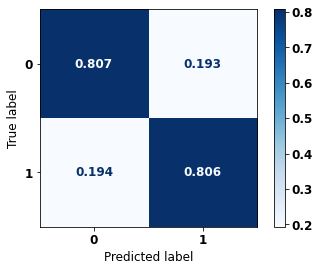


              precision    recall  f1-score   support

           0       0.83      0.81      0.82     69132
           1       0.78      0.81      0.79     57378

    accuracy                           0.81    126510
   macro avg       0.80      0.81      0.81    126510
weighted avg       0.81      0.81      0.81    126510



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


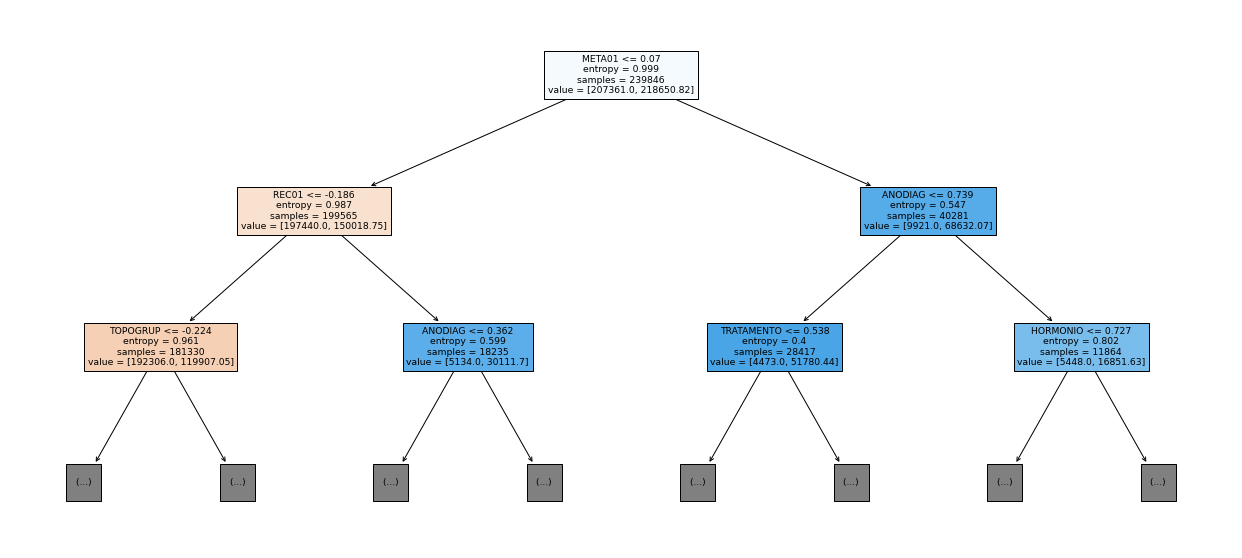

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

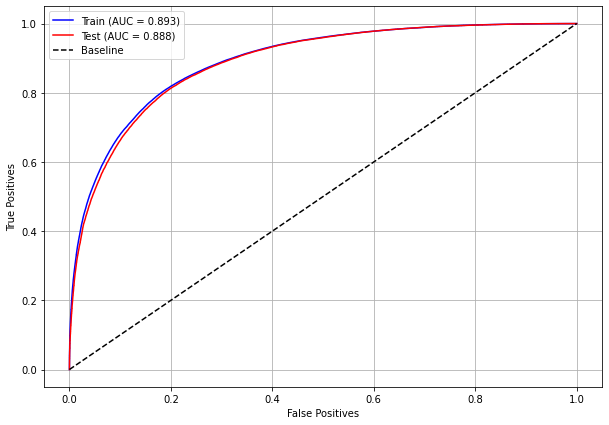

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

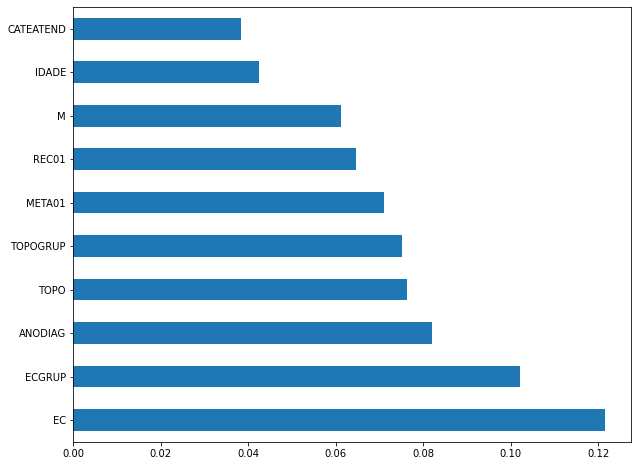

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `ANODIAG` and `TOPO`.

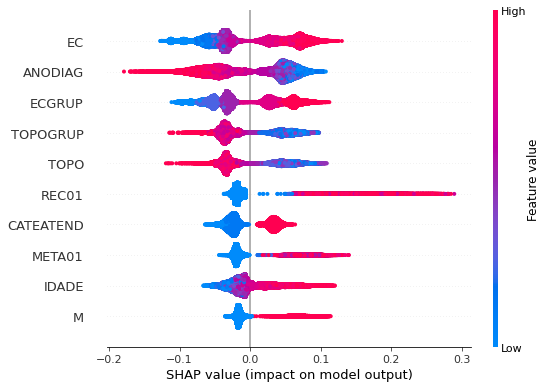

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1, 1:1.8},
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=10)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.8}, criterion='entropy',
                       max_depth=10, random_state=10)

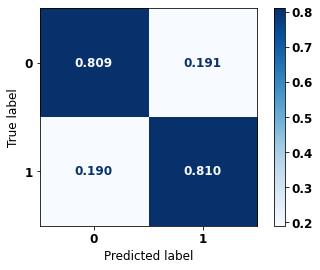


              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5092
           1       0.72      0.81      0.76      3131

    accuracy                           0.81      8223
   macro avg       0.80      0.81      0.80      8223
weighted avg       0.82      0.81      0.81      8223



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 81% of accuracy.


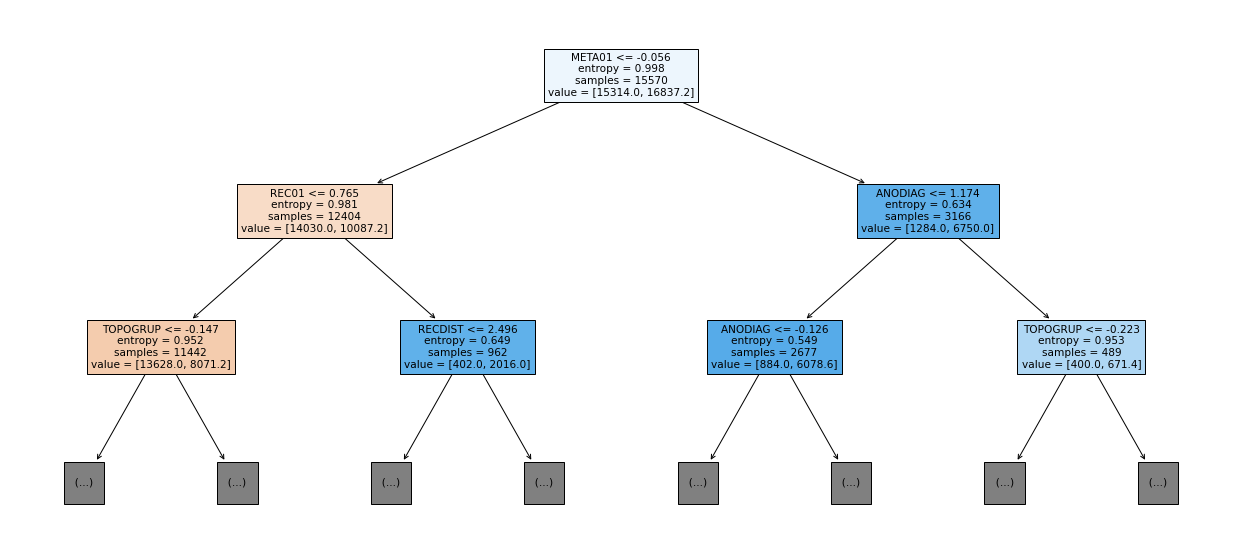

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

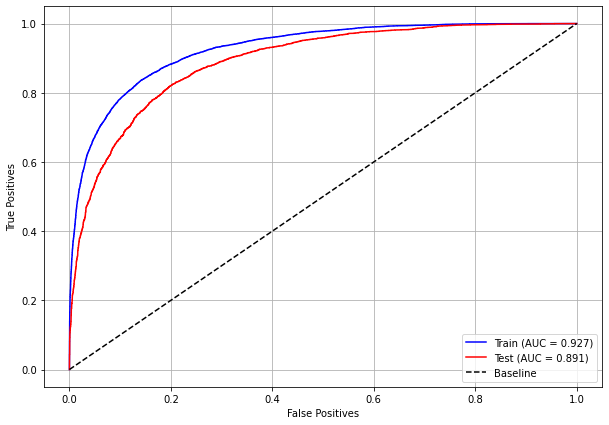

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

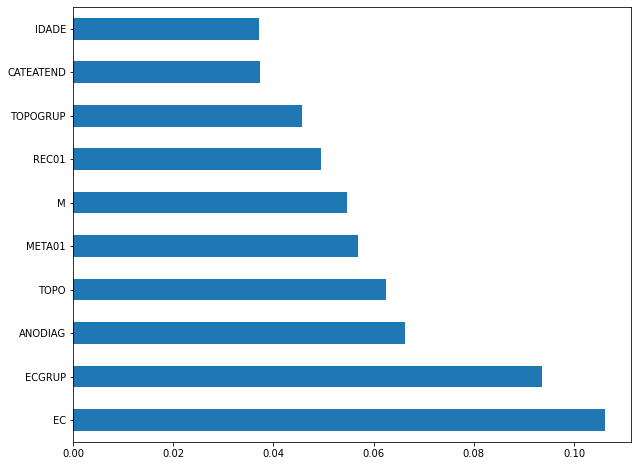

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ECGRUP`, `ANODIAG` and `TOPO`.

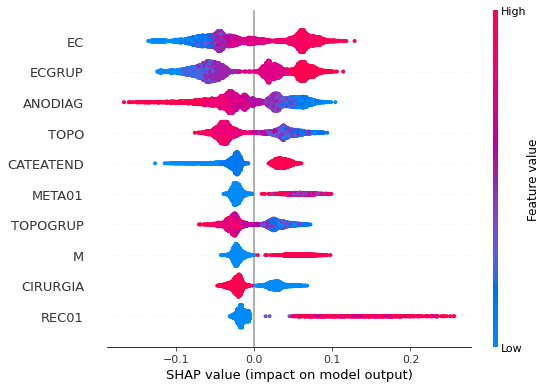

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 200, 250, 300, 500],
           'max_depth': [5, 8, 10, 15, 20, 25],
           'min_samples_split': [2, 5, 10, 15, 20],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

In [ ]:
# SP
rf_sp_opt = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:2.3},
                                   max_depth=bestSP.best_params_['max_depth'], 
                                   min_samples_leaf=bestSP.best_params_['min_samples_leaf'], 
                                   min_samples_split=bestSP.best_params_['min_samples_split'],
                                   n_estimators=bestSP.best_params_['n_estimators'],
                                   criterion='entropy')

rf_sp_opt.fit(X_train_SP, y_train_SP)

In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

In [ ]:
# Other states
rf_fora_opt = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:6.2},
                                     max_depth=bestOS.best_params_['max_depth'], 
                                     min_samples_leaf=bestOS.best_params_['min_samples_leaf'], 
                                     min_samples_split=bestOS.best_params_['min_samples_split'],
                                     n_estimators=bestOS.best_params_['n_estimators'],
                                     criterion='entropy')

rf_fora_opt.fit(X_train_OS, y_train_OS)

In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.25,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.25)

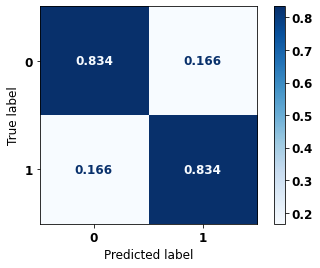


              precision    recall  f1-score   support

           0       0.86      0.83      0.85     69132
           1       0.81      0.83      0.82     57378

    accuracy                           0.83    126510
   macro avg       0.83      0.83      0.83    126510
weighted avg       0.83      0.83      0.83    126510



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 83% of accuracy.


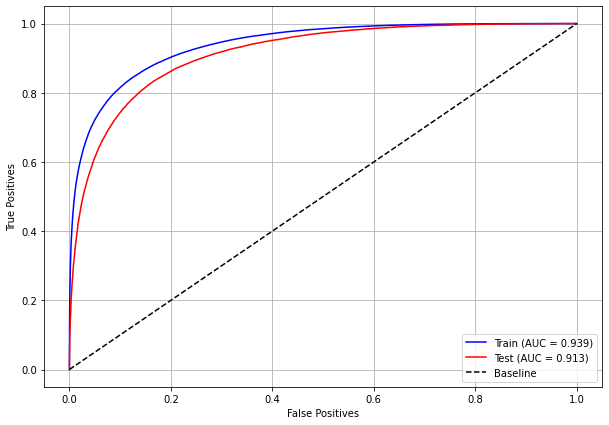

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

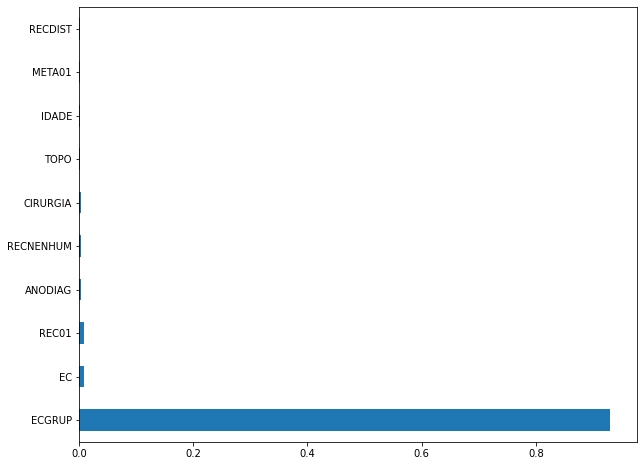

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `REC01` and `ANODIAG`.

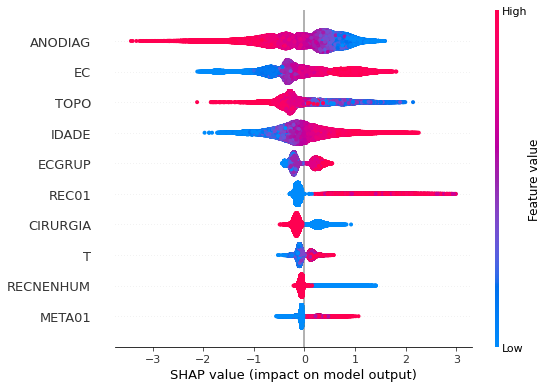

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the ANODIAG column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

In [25]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=8, 
                                 scale_pos_weight=1.9,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.9)

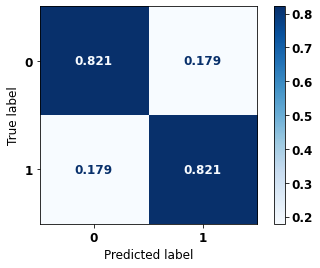


              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5092
           1       0.74      0.82      0.78      3131

    accuracy                           0.82      8223
   macro avg       0.81      0.82      0.81      8223
weighted avg       0.83      0.82      0.82      8223



In [26]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 82% of accuracy.


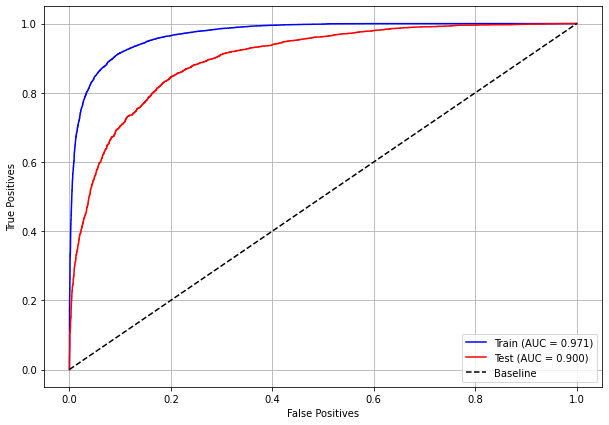

In [27]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

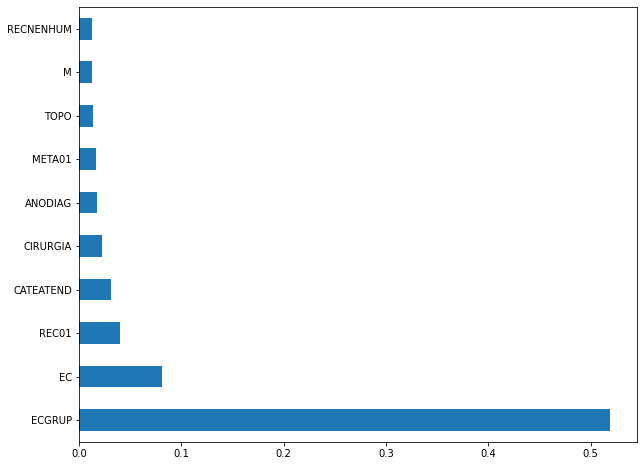

In [28]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `EC`, `REC01` and `CATEATEND`.

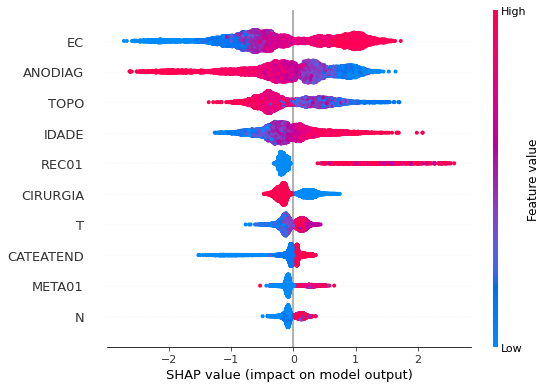

In [29]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15, 20, 30],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250, 300]}

xgboost = xgb.XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

In [ ]:
# SP
xgb_sp_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=1.31,
                               colsample_bytree=bestSP.best_params_['colsample_bytree'],
                               gamma=bestSP.best_params_['gamma'], 
                               learning_rate=bestSP.best_params_['learning_rate'],
                               max_depth=bestSP.best_params_['max_depth'], 
                               min_child_weight=bestSP.best_params_['min_child_weight'],
                               n_estimators=bestSP.best_params_['n_estimators'])

xgb_sp_opt.fit(X_train_SP, y_train_SP)

In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

In [ ]:
# Other states
xgb_fora_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=1.7,
                                 colsample_bytree=bestOS.best_params_['colsample_bytree'],
                                 gamma=bestOS.best_params_['gamma'], 
                                 learning_rate=bestOS.best_params_['learning_rate'],
                                 max_depth=bestOS.best_params_['max_depth'], 
                                 min_child_weight=bestOS.best_params_['min_child_weight'],
                                 n_estimators=bestOS.best_params_['n_estimators'])

xgb_fora_opt.fit(X_train_OS, y_train_OS)

In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach using only morphologies with final digit equal to 3 and without `EC` column as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [30]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [31]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (351486, 65), X_test = (117163, 65)
y_train = (351486,), y_test = (117163,)


**Other states**

In [32]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (23079, 65), X_test = (7693, 65)
y_train = (23079,), y_test = (7693,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:1, 1:1.149},
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.149}, criterion='entropy',
                       max_depth=10, random_state=10)

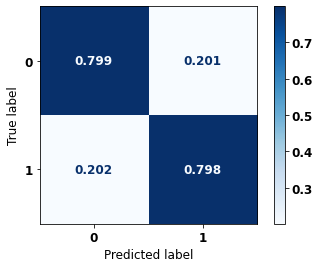


              precision    recall  f1-score   support

           0       0.81      0.80      0.80     60502
           1       0.79      0.80      0.79     56661

    accuracy                           0.80    117163
   macro avg       0.80      0.80      0.80    117163
weighted avg       0.80      0.80      0.80    117163



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, also shows a good performance of the model, with 80% of accuracy.


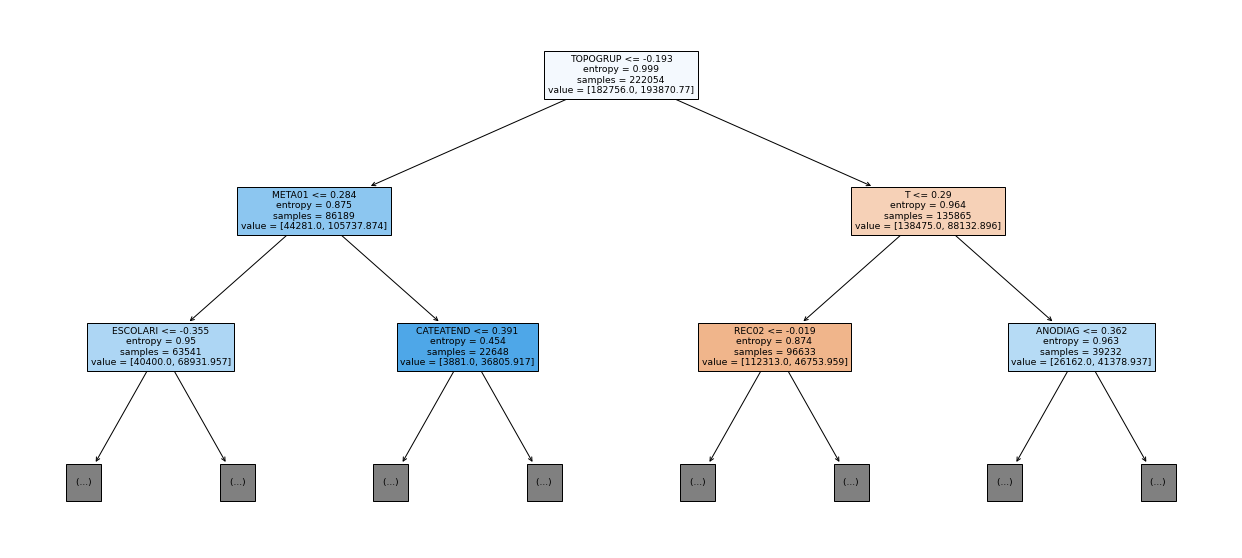

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

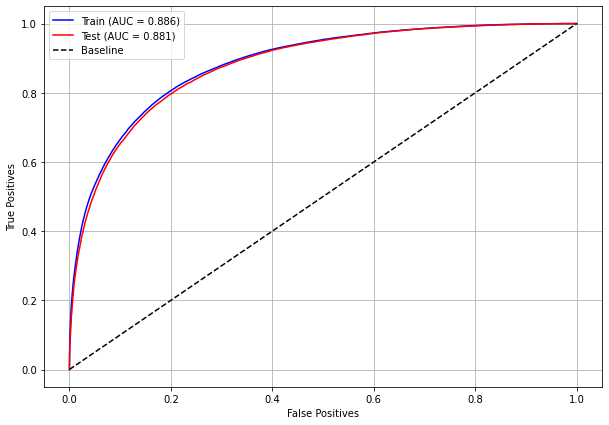

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

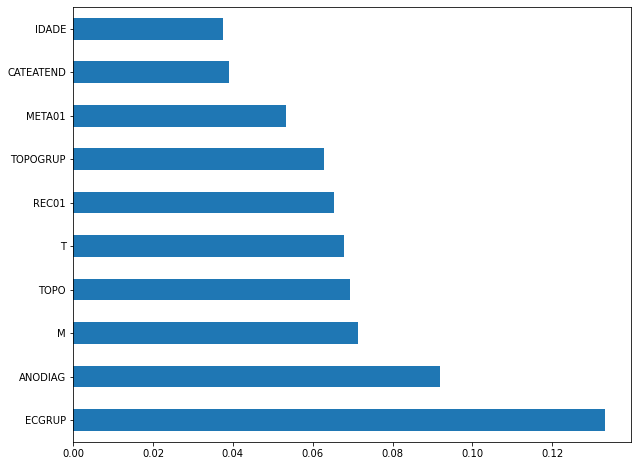

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `M` and `TOPO`.

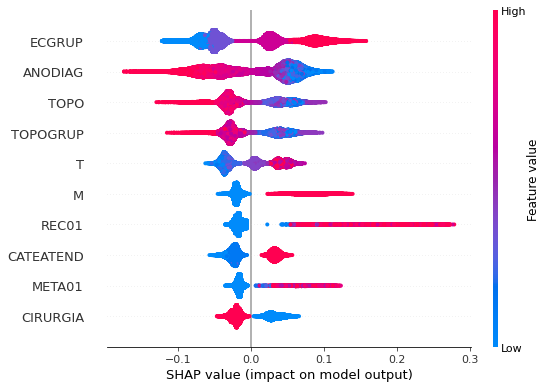

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:1, 1:1.48},
                                 criterion='entropy',
                                 max_depth=10)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.48}, criterion='entropy',
                       max_depth=10, random_state=10)

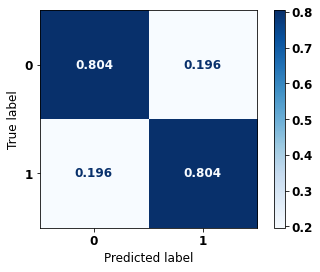


              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4578
           1       0.74      0.80      0.77      3115

    accuracy                           0.80      7693
   macro avg       0.80      0.80      0.80      7693
weighted avg       0.81      0.80      0.80      7693



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with other states data shows a good performance of the model, because the model achieves a 80% of accuracy.


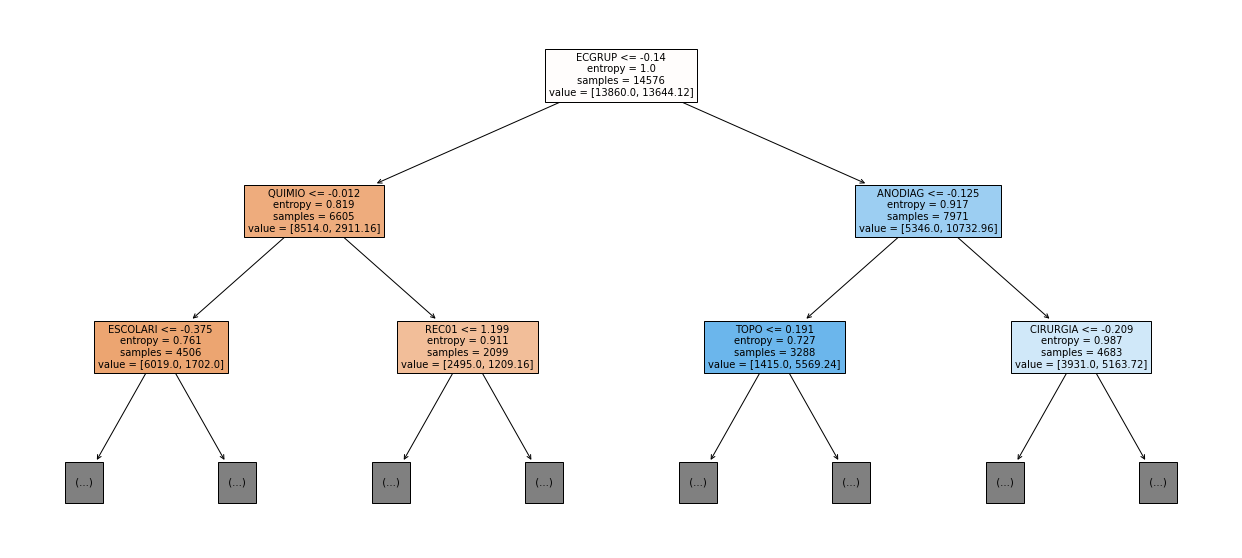

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

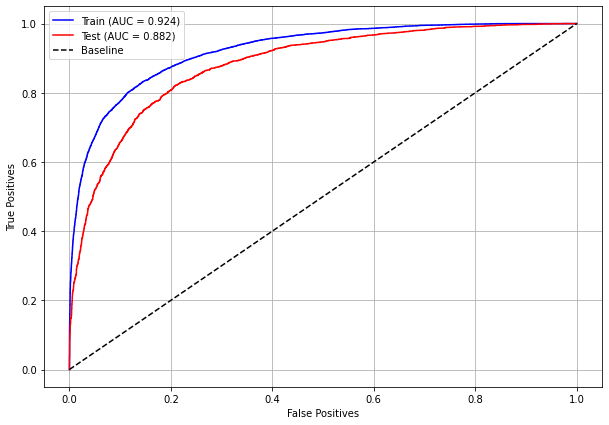

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

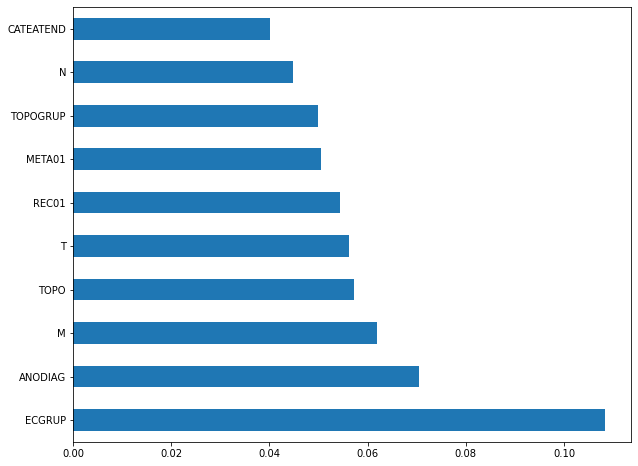

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ANODIAG`, `M` and `TOPO`.

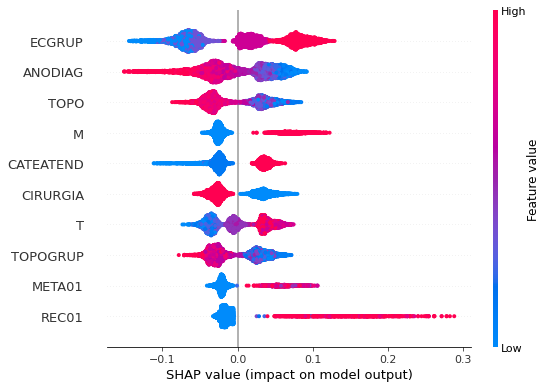

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.108,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.108)

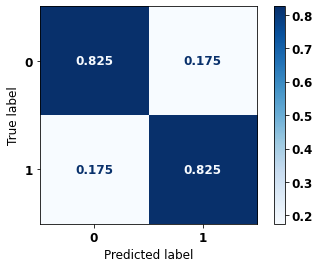


              precision    recall  f1-score   support

           0       0.83      0.82      0.83     60502
           1       0.82      0.82      0.82     56661

    accuracy                           0.82    117163
   macro avg       0.82      0.82      0.82    117163
weighted avg       0.82      0.82      0.82    117163



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 82% of accuracy.


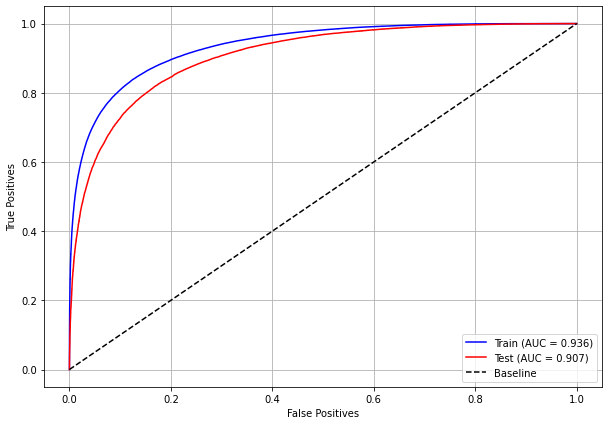

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

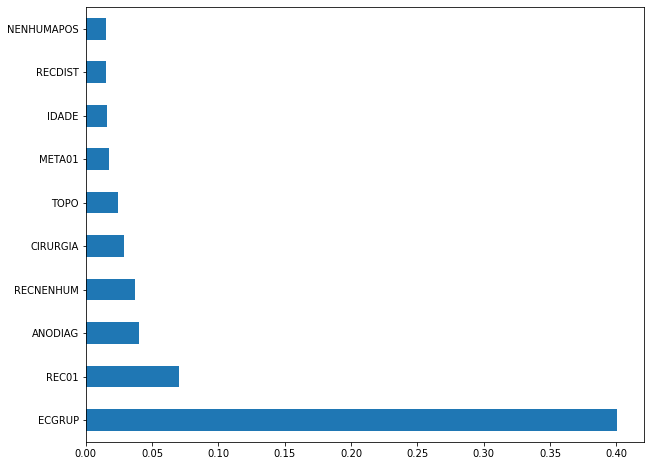

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `ANODIAG` and `RECNENHUM`.

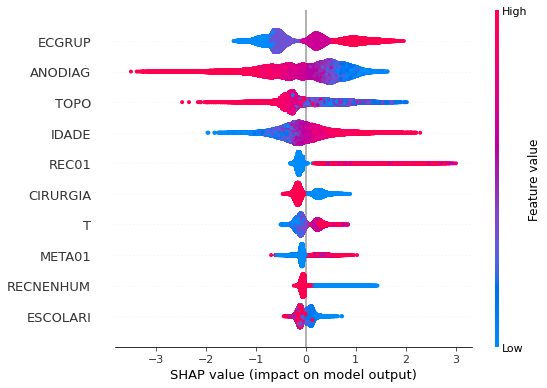

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [49]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=8, 
                                 scale_pos_weight=1.533,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.533)

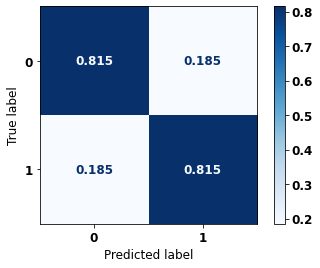


              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4578
           1       0.75      0.81      0.78      3115

    accuracy                           0.82      7693
   macro avg       0.81      0.81      0.81      7693
weighted avg       0.82      0.82      0.82      7693



In [50]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 81% of accuracy.


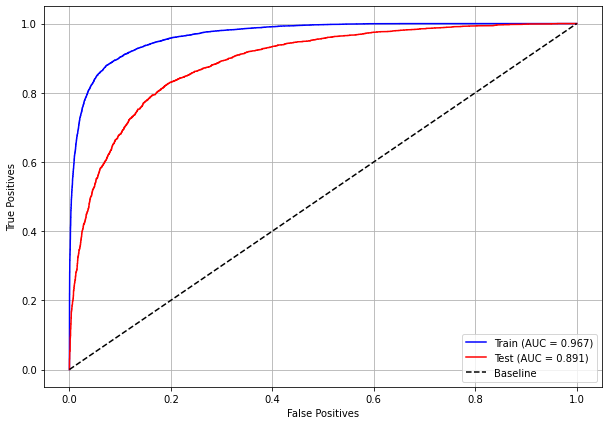

In [51]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

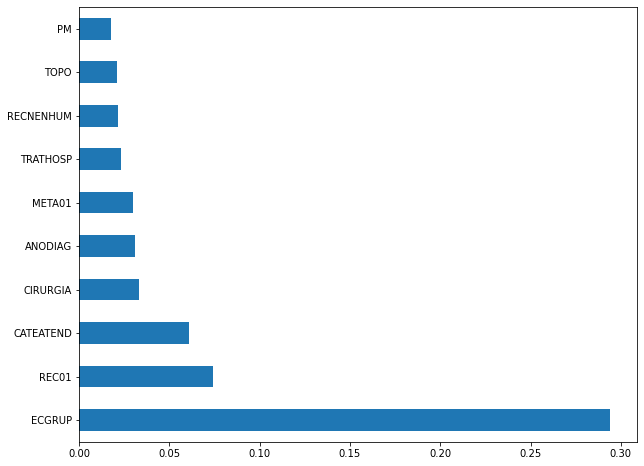

In [52]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `REC01`, `CATEATEND` and `CIRURGIA`.

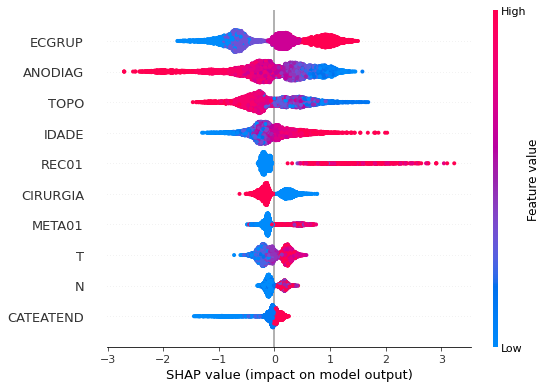

In [53]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Third approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [54]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [55]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (49873, 65), X_test = (16625, 65)
y_train = (49873,), y_test = (16625,)


In [56]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (62658, 65), X_test = (20887, 65)
y_train = (62658,), y_test = (20887,)


In [57]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (83228, 65), X_test = (27743, 65)
y_train = (83228,), y_test = (27743,)


In [58]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (103890, 65), X_test = (34630, 65)
y_train = (103890,), y_test = (34630,)


In [59]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (79877, 65), X_test = (26626, 65)
y_train = (79877,), y_test = (26626,)


### **Other states**

In [60]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2802, 65), X_test = (935, 65)
y_train = (2802,), y_test = (935,)


In [61]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3942, 65), X_test = (1315, 65)
y_train = (3942,), y_test = (1315,)


In [62]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4842, 65), X_test = (1614, 65)
y_train = (4842,), y_test = (1614,)


In [63]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6456, 65), X_test = (2153, 65)
y_train = (6456,), y_test = (2153,)


In [64]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6624, 65), X_test = (2208, 65)
y_train = (6624,), y_test = (2208,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.85, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1.85, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

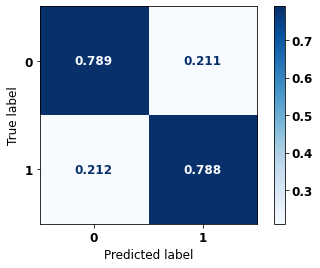


              precision    recall  f1-score   support

           0       0.67      0.79      0.73      5933
           1       0.87      0.79      0.83     10692

    accuracy                           0.79     16625
   macro avg       0.77      0.79      0.78     16625
weighted avg       0.80      0.79      0.79     16625



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


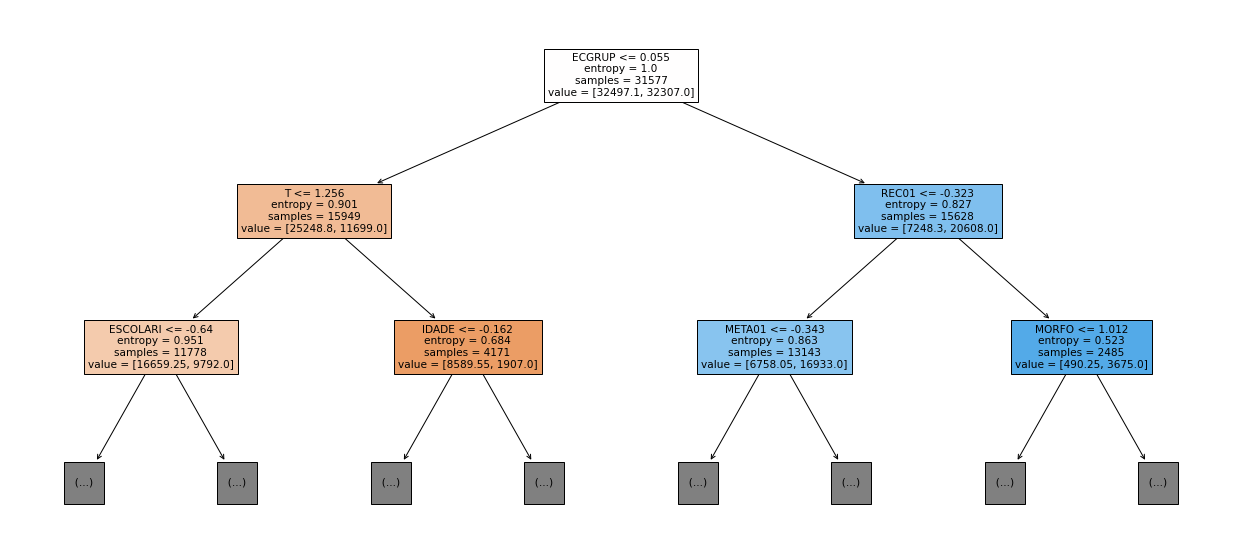

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

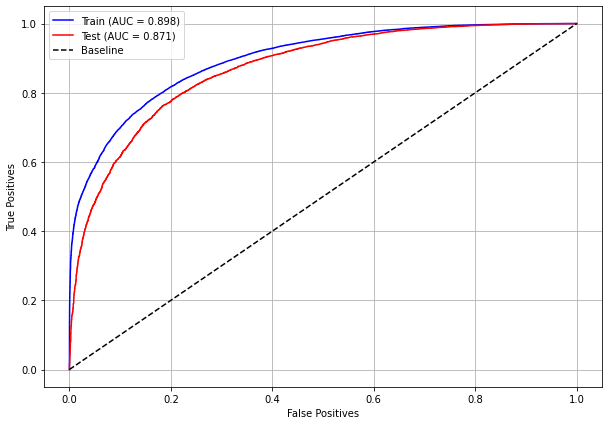

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

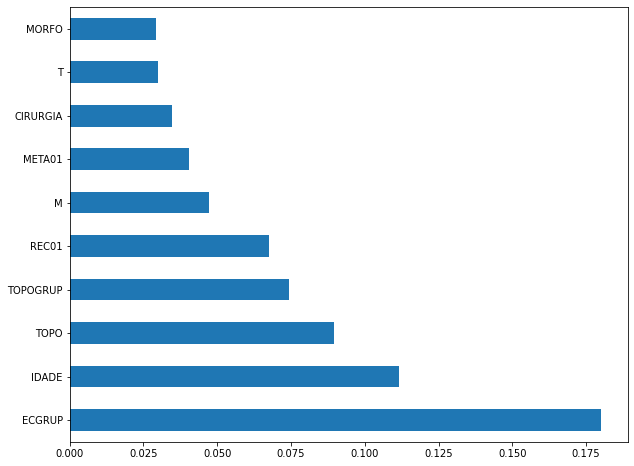

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO`, and `TOPOGRUP`. 

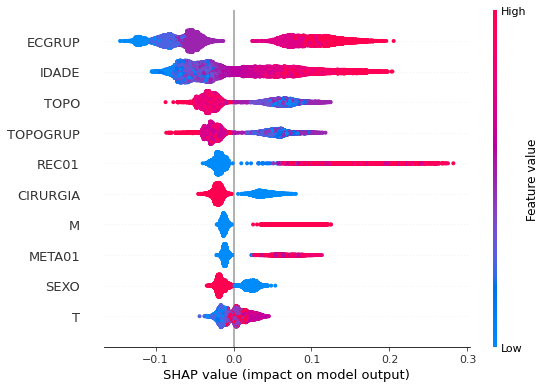

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.25007, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.25007, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

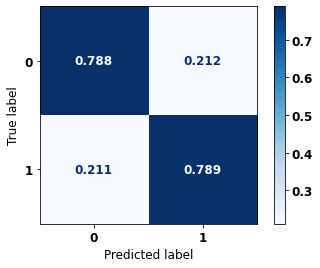


              precision    recall  f1-score   support

           0       0.73      0.79      0.76      8835
           1       0.84      0.79      0.81     12052

    accuracy                           0.79     20887
   macro avg       0.78      0.79      0.79     20887
weighted avg       0.79      0.79      0.79     20887



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


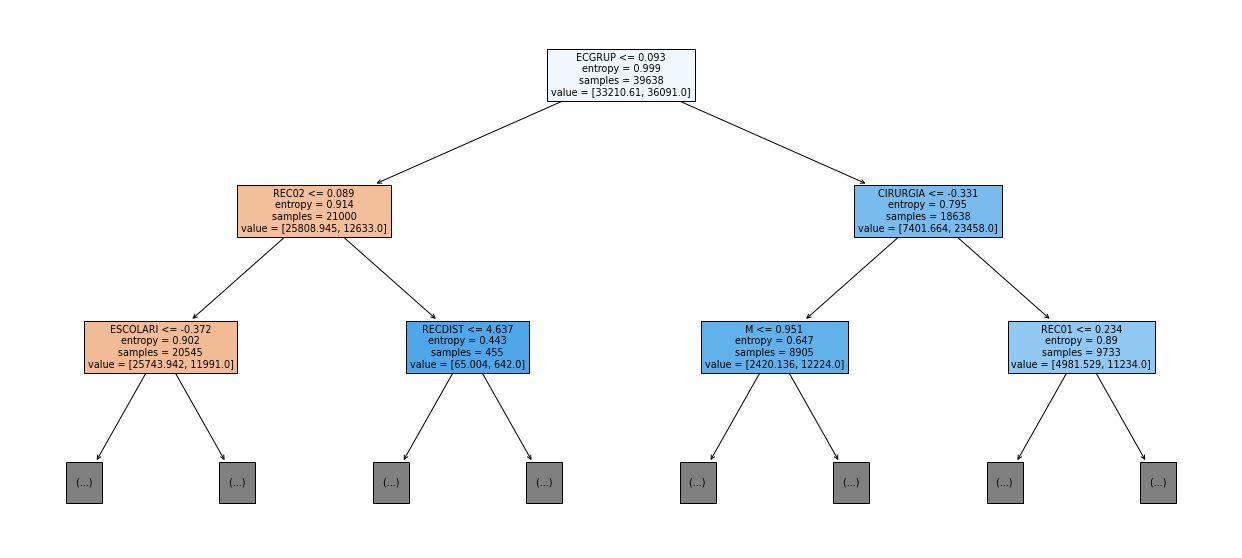

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

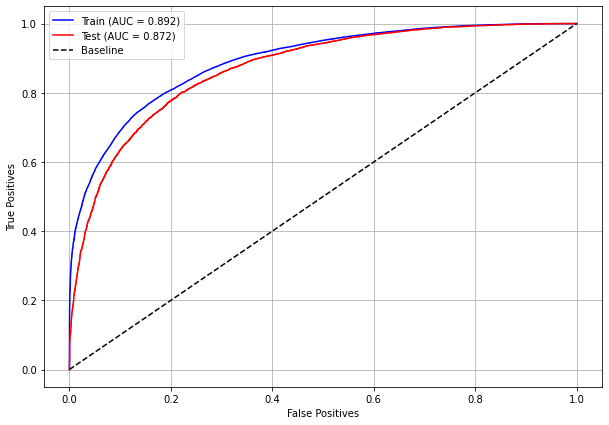

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

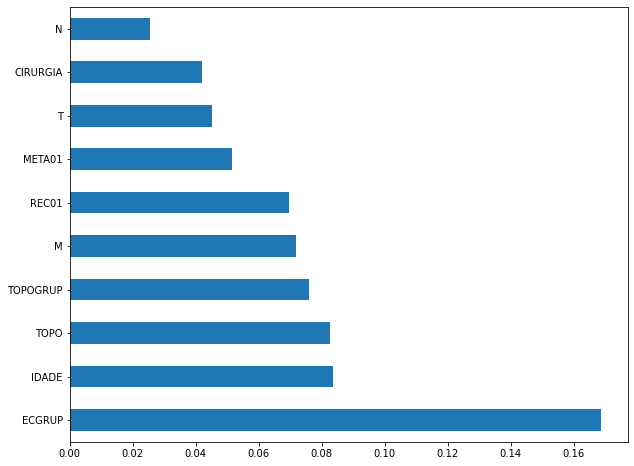

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO`, and `TOPOGRUP`. 

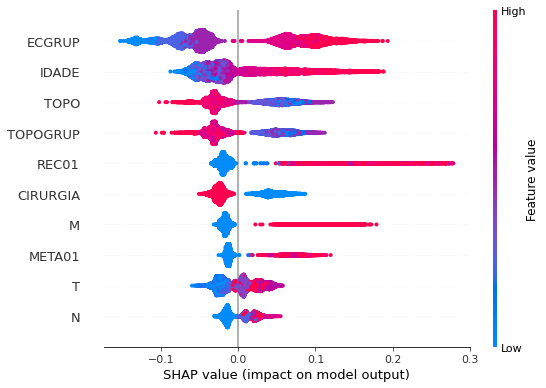

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.201},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.201}, criterion='entropy',
                       max_depth=10, random_state=10)

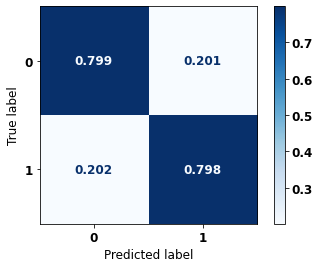


              precision    recall  f1-score   support

           0       0.79      0.80      0.80     13700
           1       0.80      0.80      0.80     14043

    accuracy                           0.80     27743
   macro avg       0.80      0.80      0.80     27743
weighted avg       0.80      0.80      0.80     27743



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

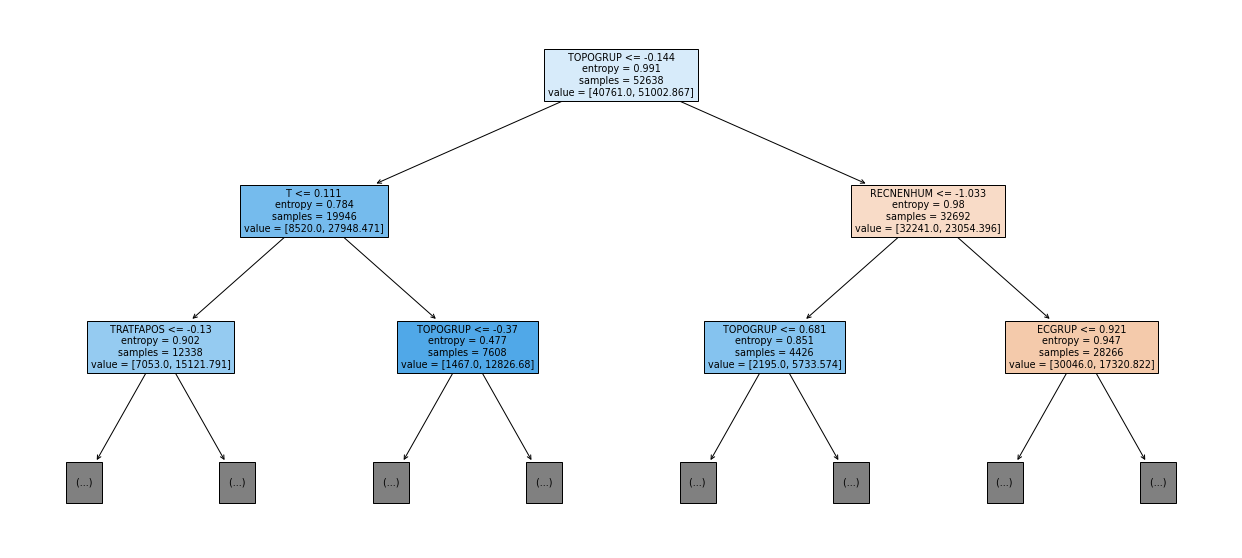

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

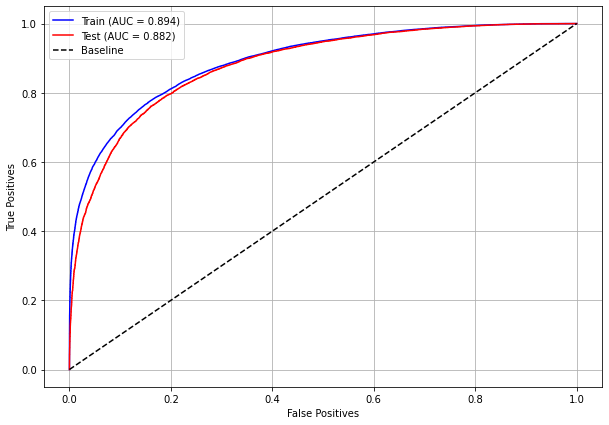

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

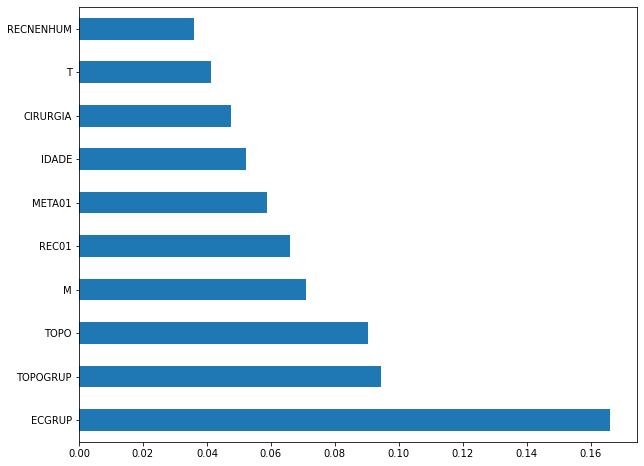

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `M`.

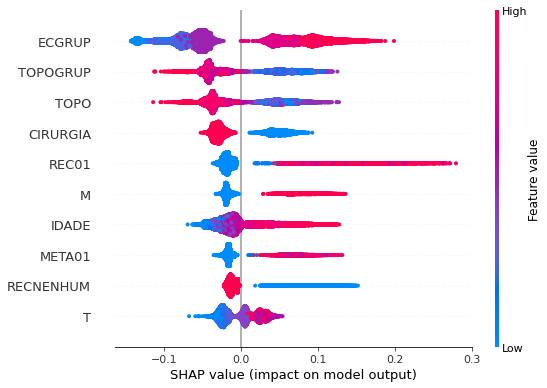

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=10, random_state=10)

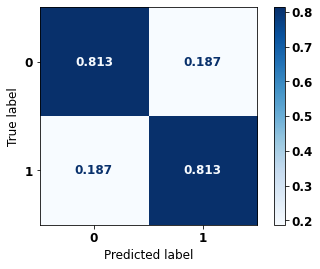


              precision    recall  f1-score   support

           0       0.87      0.81      0.84     21278
           1       0.73      0.81      0.77     13352

    accuracy                           0.81     34630
   macro avg       0.80      0.81      0.81     34630
weighted avg       0.82      0.81      0.81     34630



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

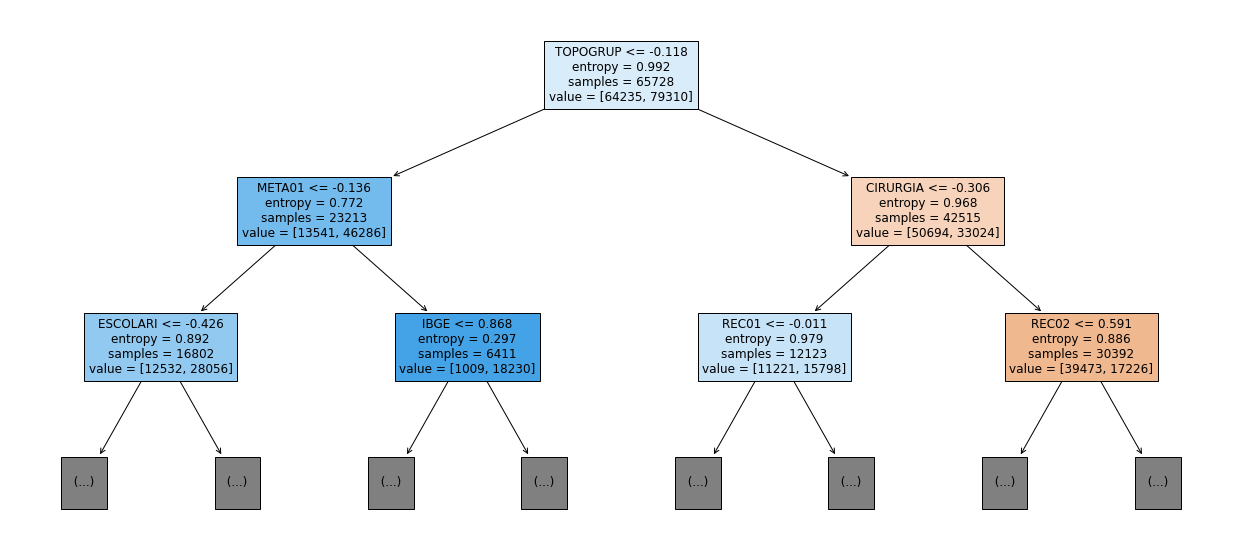

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

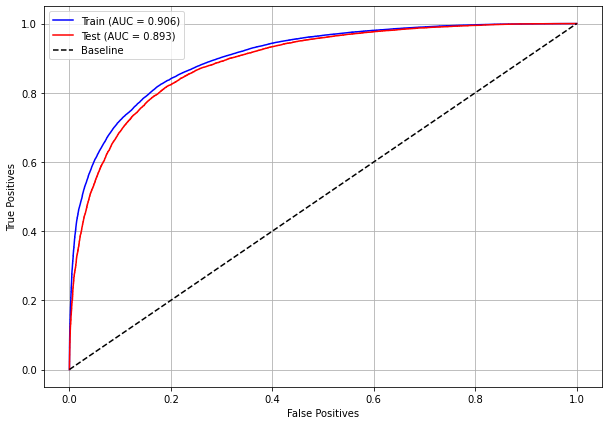

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

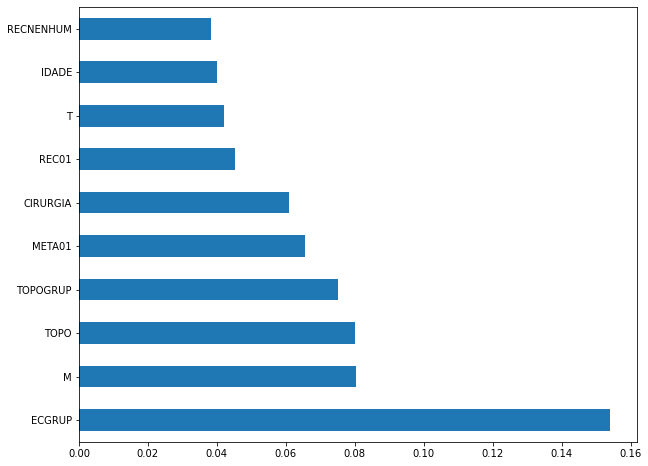

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

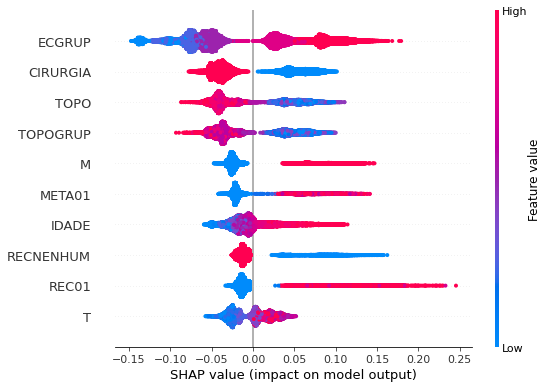

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.88},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 2.88}, criterion='entropy',
                       max_depth=10, random_state=10)

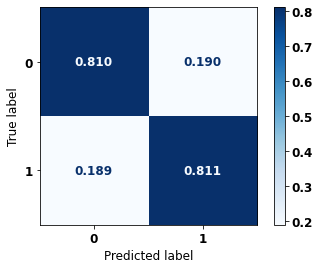


              precision    recall  f1-score   support

           0       0.92      0.81      0.86     19595
           1       0.61      0.81      0.69      7031

    accuracy                           0.81     26626
   macro avg       0.76      0.81      0.78     26626
weighted avg       0.84      0.81      0.82     26626



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

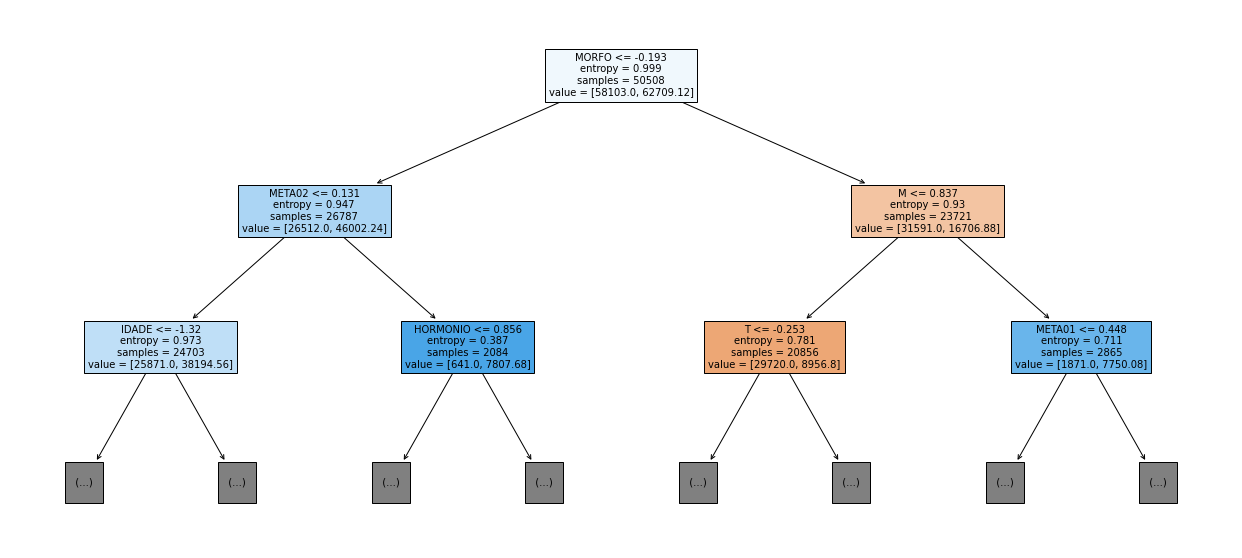

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

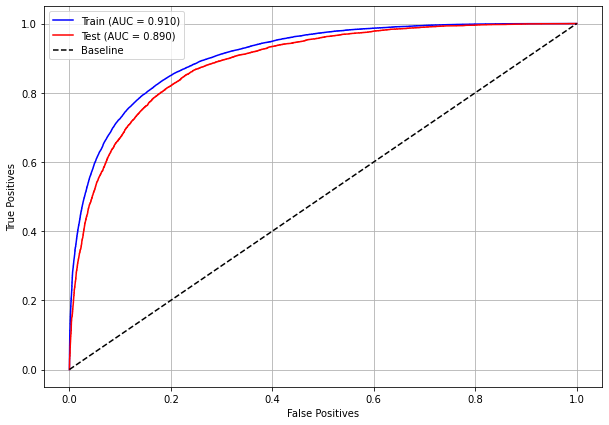

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

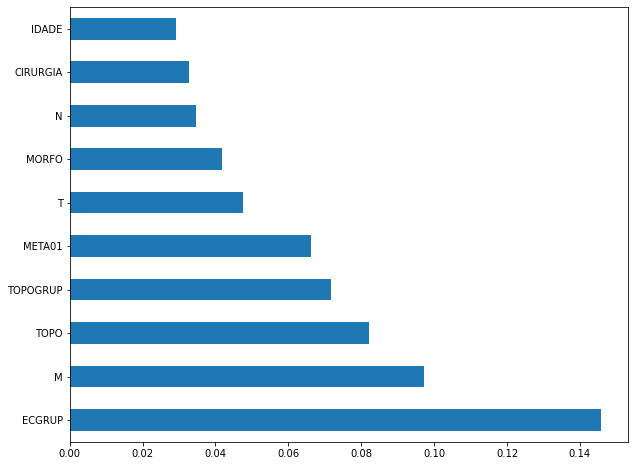

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO`, and `TOPOGRUP`.



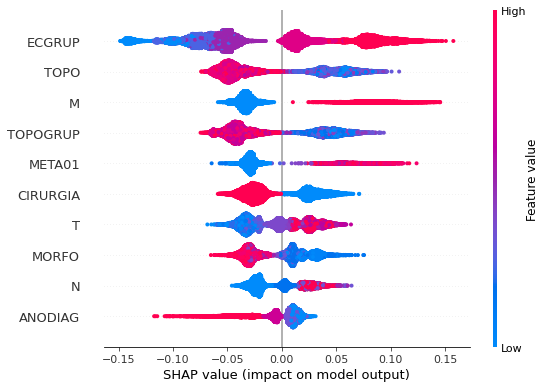

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [77]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.327, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.327, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

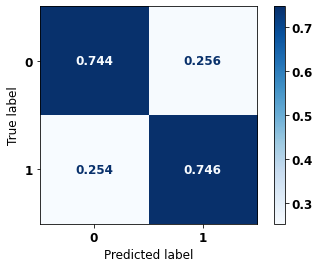


              precision    recall  f1-score   support

           0       0.67      0.74      0.71       383
           1       0.81      0.75      0.78       552

    accuracy                           0.75       935
   macro avg       0.74      0.75      0.74       935
weighted avg       0.75      0.75      0.75       935



In [78]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 75% of accuracy.

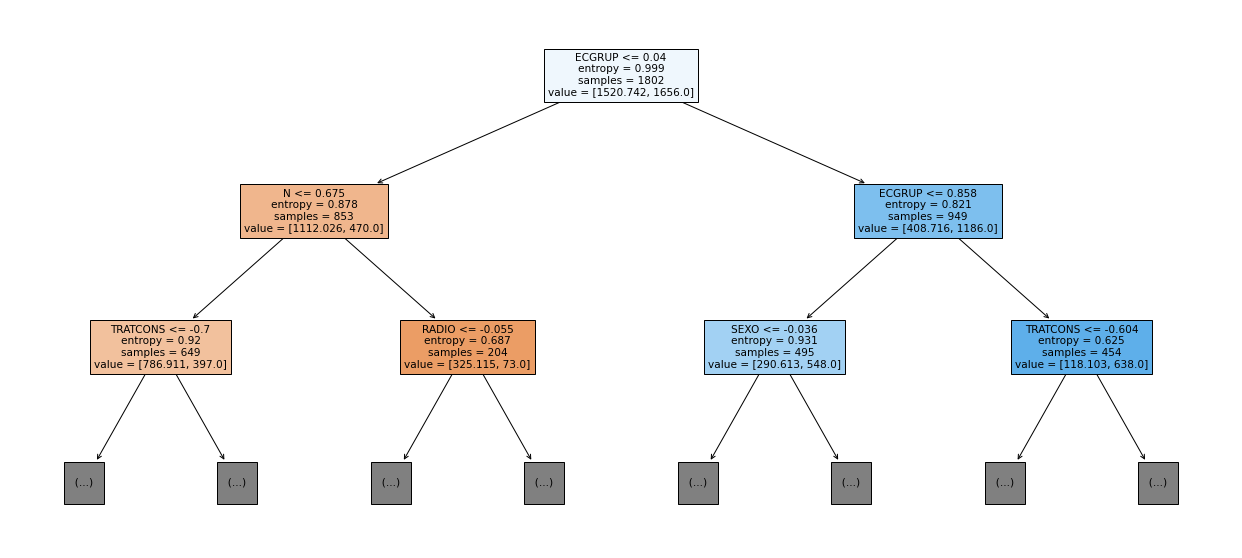

In [79]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

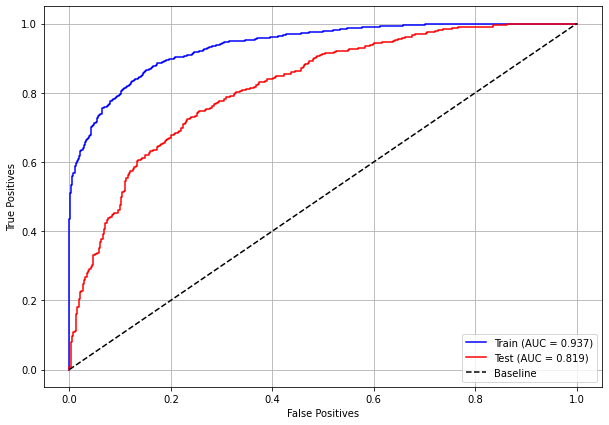

In [80]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

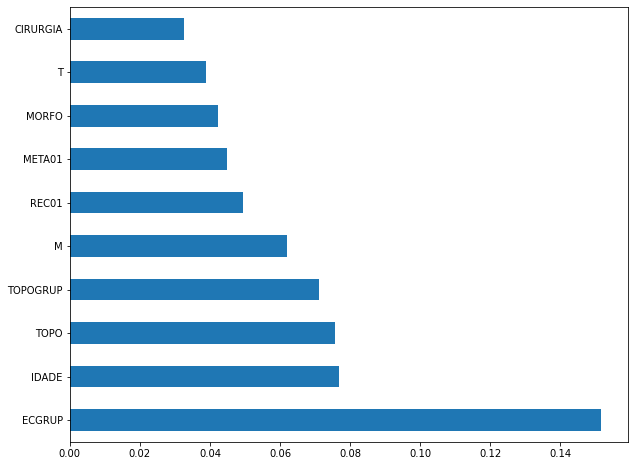

In [81]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO` and `TOPOGRUP`.

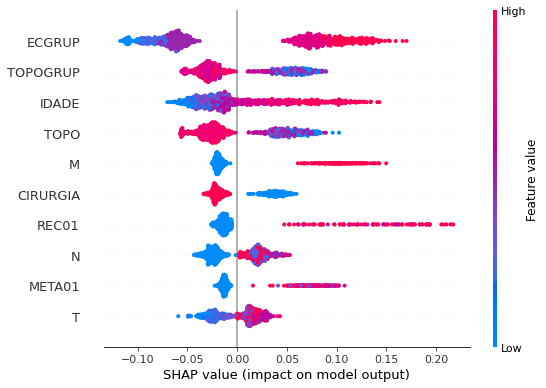

In [82]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [87]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.36},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.36}, criterion='entropy',
                       max_depth=8, random_state=10)

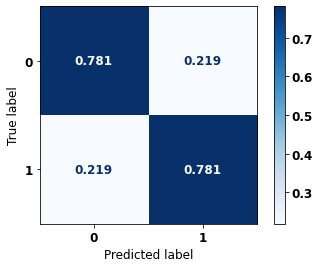


              precision    recall  f1-score   support

           0       0.79      0.78      0.78       672
           1       0.77      0.78      0.78       643

    accuracy                           0.78      1315
   macro avg       0.78      0.78      0.78      1315
weighted avg       0.78      0.78      0.78      1315



In [88]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 78% of accuracy.


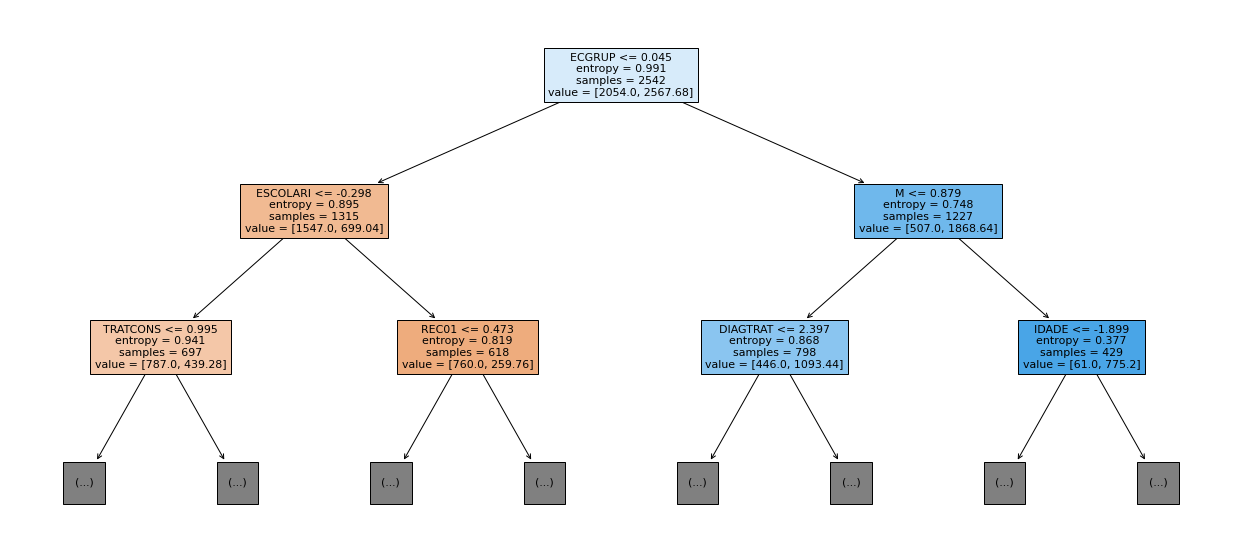

In [89]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

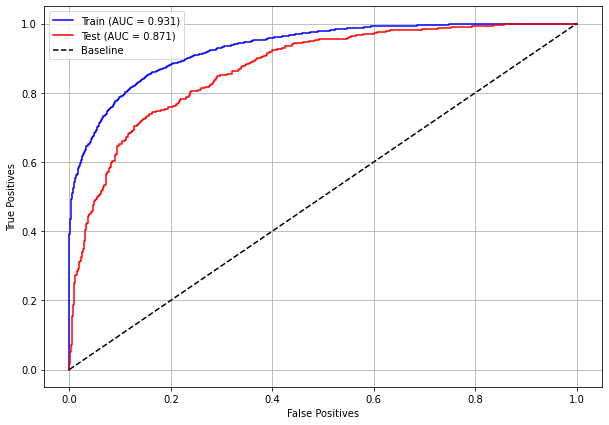

In [90]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

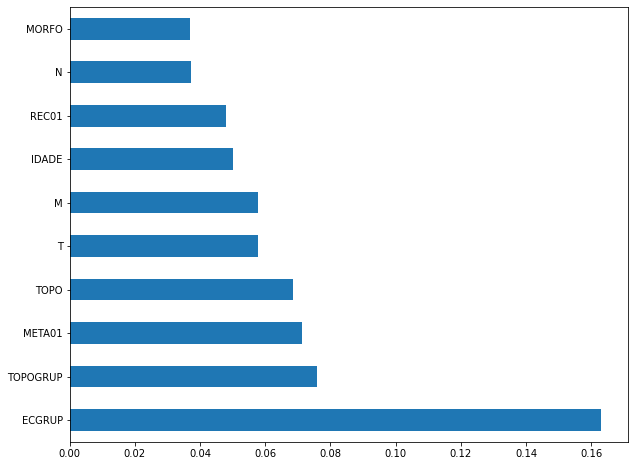

In [91]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `META01` and `TOPO`.

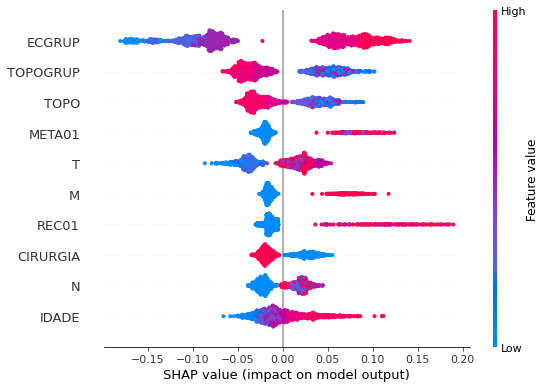

In [92]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [97]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.95},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.95}, criterion='entropy',
                       max_depth=8, random_state=10)

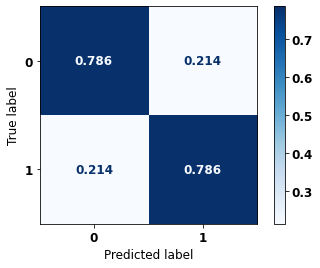


              precision    recall  f1-score   support

           0       0.83      0.79      0.81       913
           1       0.74      0.79      0.76       701

    accuracy                           0.79      1614
   macro avg       0.78      0.79      0.78      1614
weighted avg       0.79      0.79      0.79      1614



In [98]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 79% of accuracy.


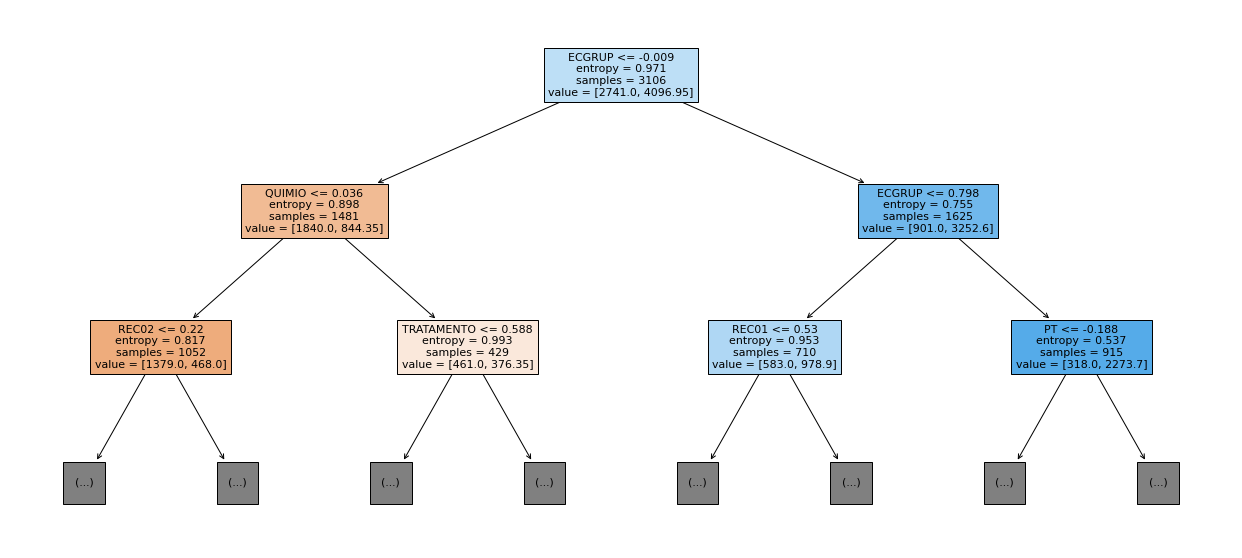

In [99]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

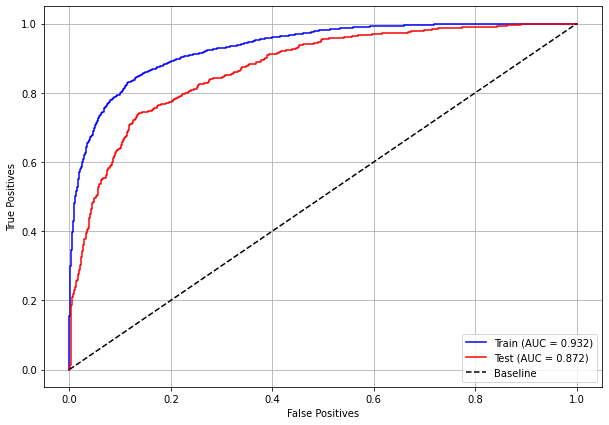

In [100]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

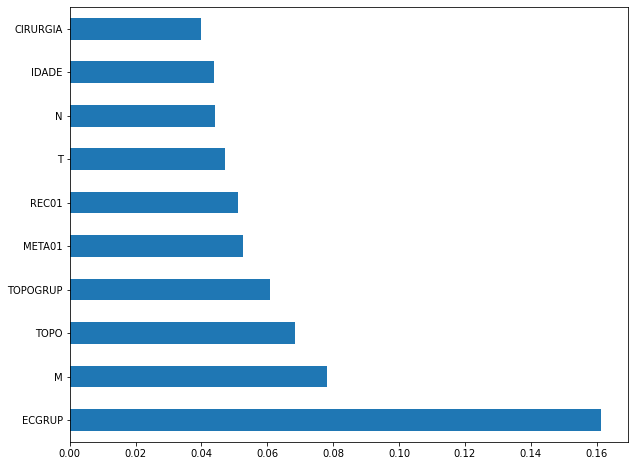

In [101]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

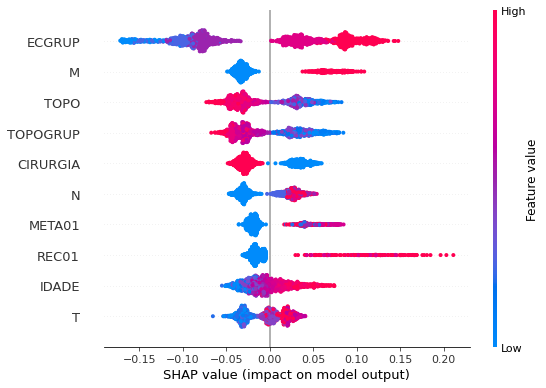

In [102]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [103]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 3.0}, criterion='entropy',
                       max_depth=8, random_state=10)

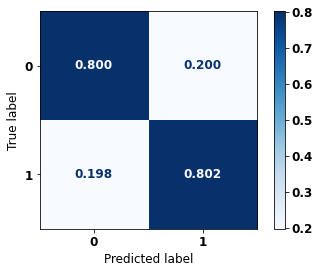


              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1447
           1       0.66      0.80      0.73       706

    accuracy                           0.80      2153
   macro avg       0.78      0.80      0.78      2153
weighted avg       0.82      0.80      0.80      2153



In [104]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 80% of accuracy.


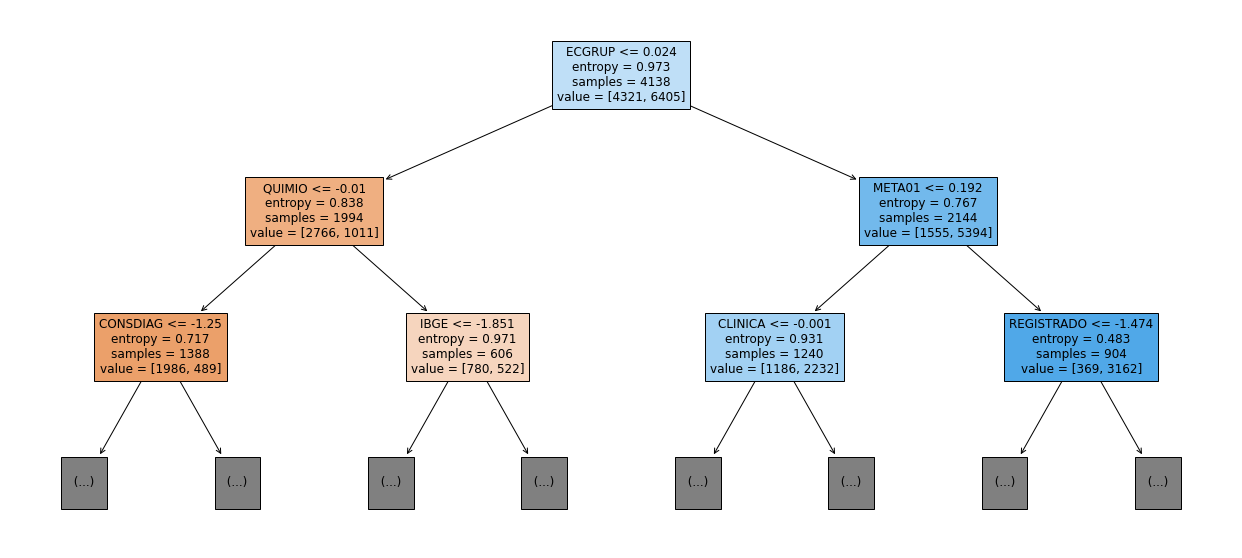

In [105]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

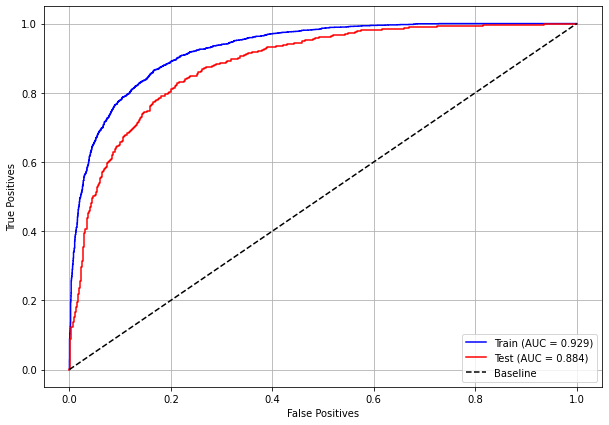

In [106]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

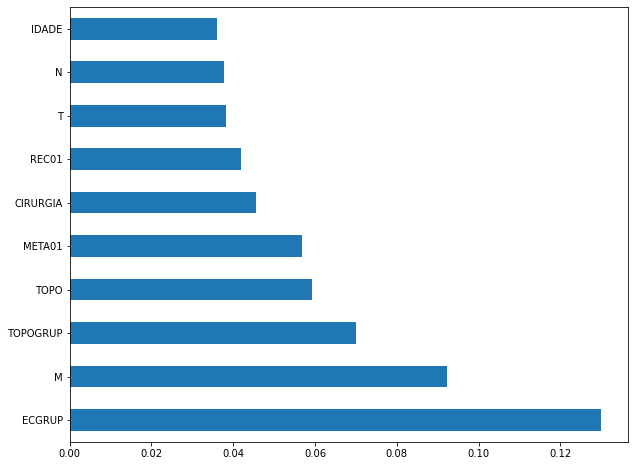

In [107]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `TOPO`.

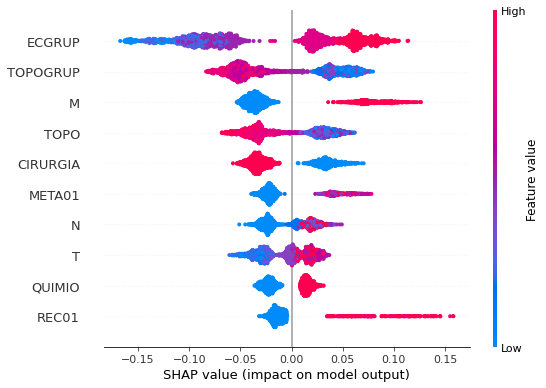

In [108]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [119]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.34},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 3.34}, criterion='entropy',
                       max_depth=8, random_state=10)

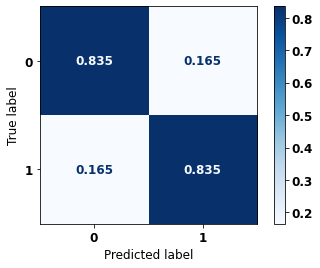


              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1632
           1       0.64      0.84      0.73       576

    accuracy                           0.84      2208
   macro avg       0.79      0.84      0.80      2208
weighted avg       0.86      0.84      0.84      2208



In [120]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 84% of accuracy.


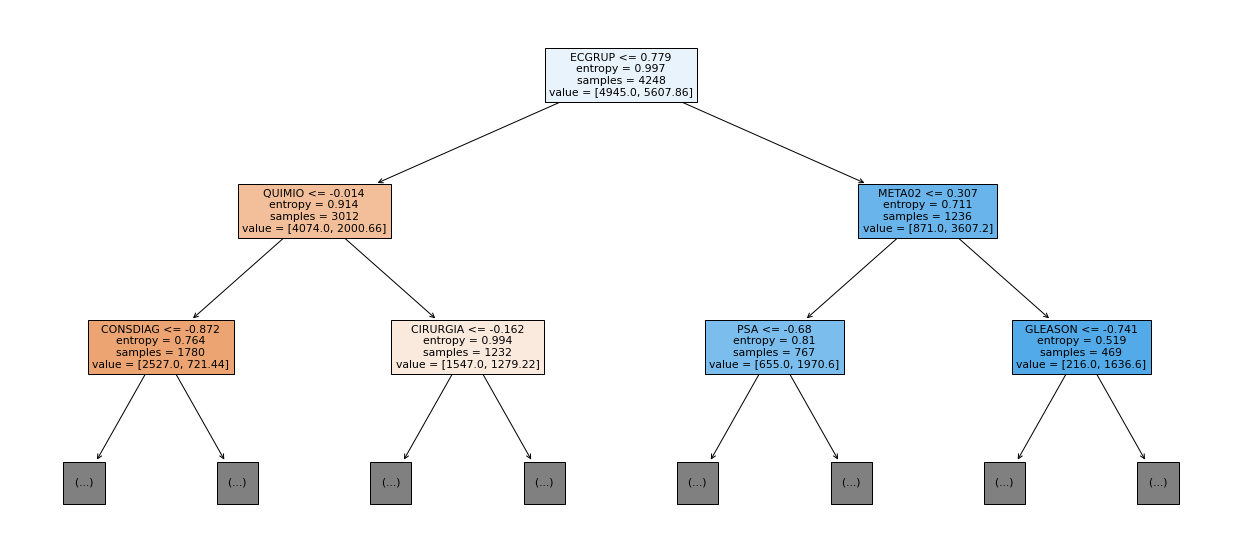

In [121]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

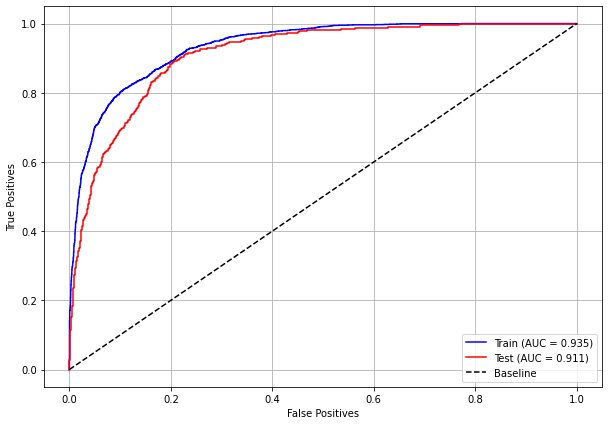

In [122]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

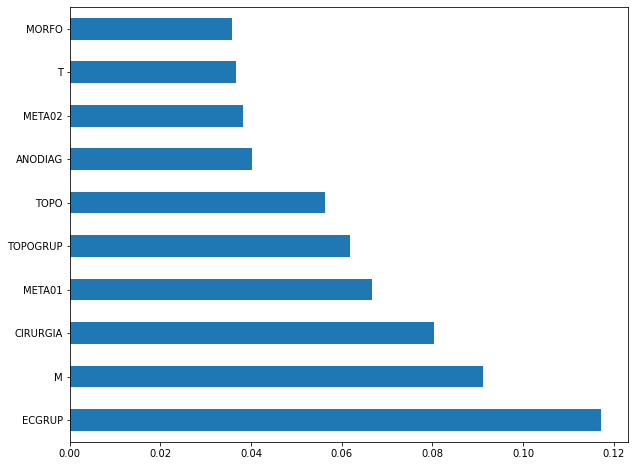

In [123]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, `M`, `CIRURGIA` and `META01`.

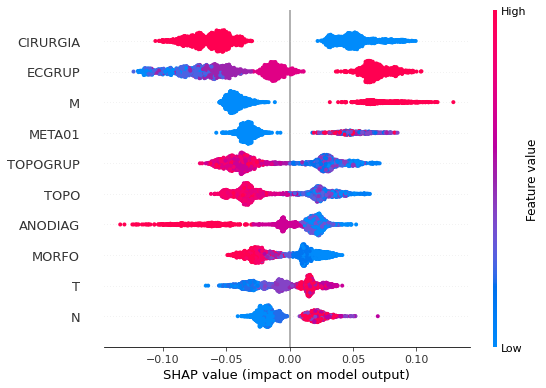

In [124]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the CIRURGIA column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.488)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.488)

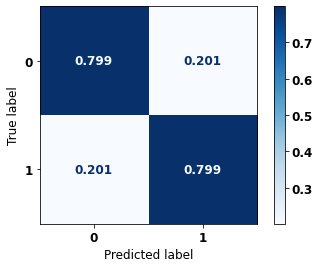


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5933
           1       0.88      0.80      0.84     10692

    accuracy                           0.80     16625
   macro avg       0.78      0.80      0.79     16625
weighted avg       0.81      0.80      0.80     16625



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 80% of accuracy.

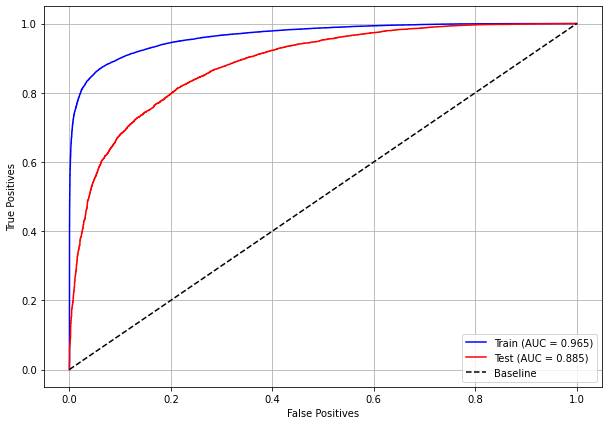

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

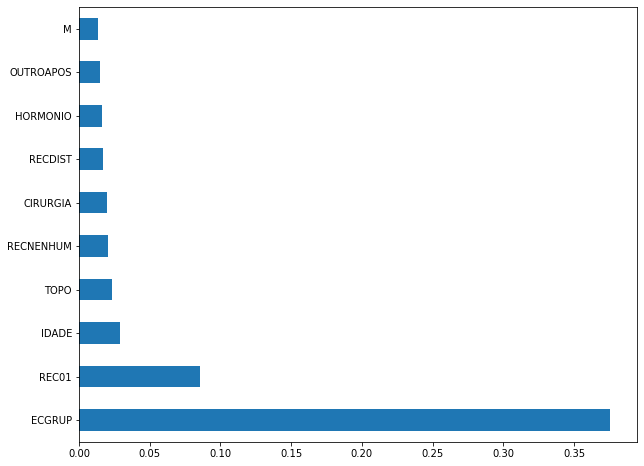

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `IDADE` and `TOPO`.

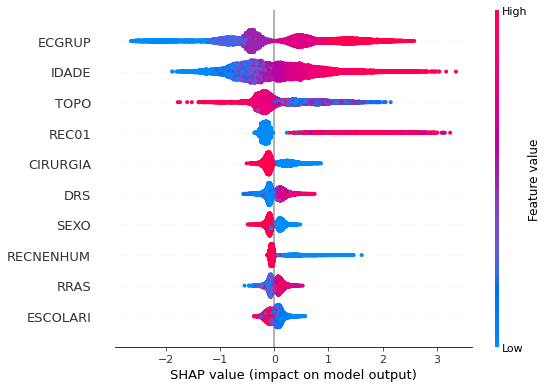

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.727)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.727)

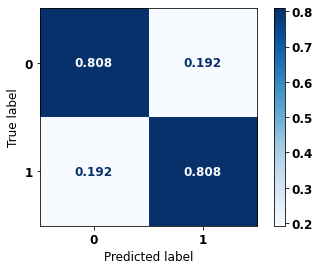


              precision    recall  f1-score   support

           0       0.76      0.81      0.78      8835
           1       0.85      0.81      0.83     12052

    accuracy                           0.81     20887
   macro avg       0.80      0.81      0.81     20887
weighted avg       0.81      0.81      0.81     20887



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


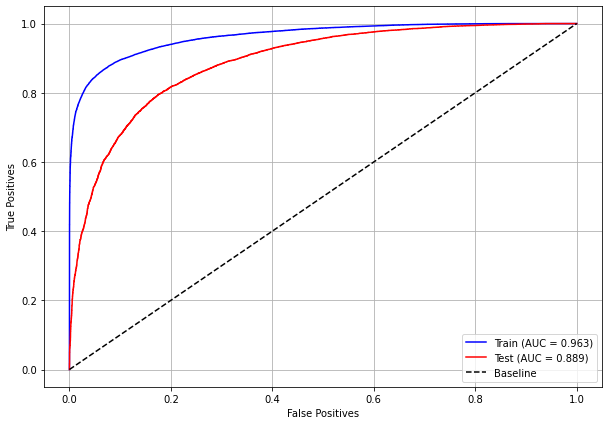

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

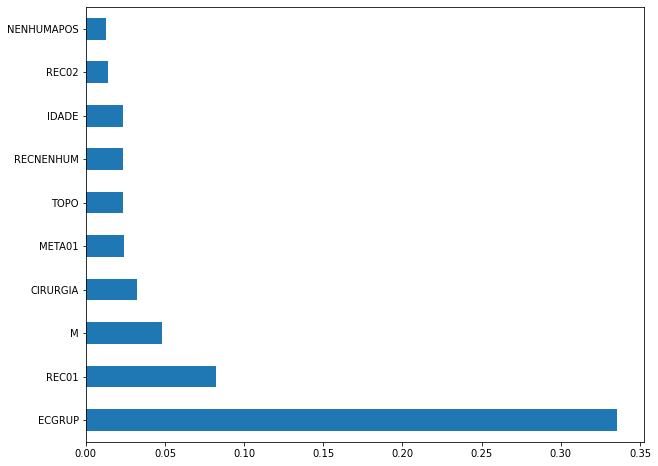

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `M` and `CIRURGIA`. 

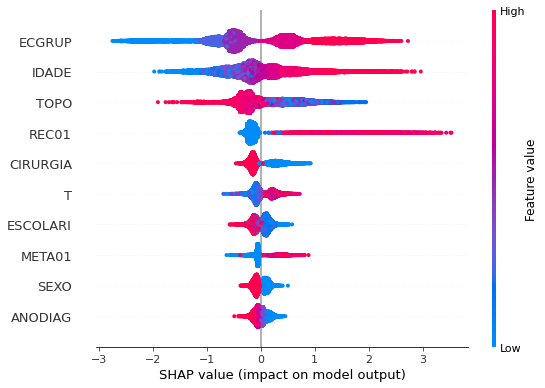

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.128,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.128)

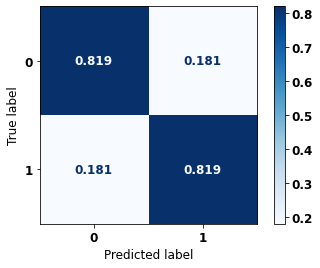


              precision    recall  f1-score   support

           0       0.82      0.82      0.82     13700
           1       0.82      0.82      0.82     14043

    accuracy                           0.82     27743
   macro avg       0.82      0.82      0.82     27743
weighted avg       0.82      0.82      0.82     27743



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuracy.

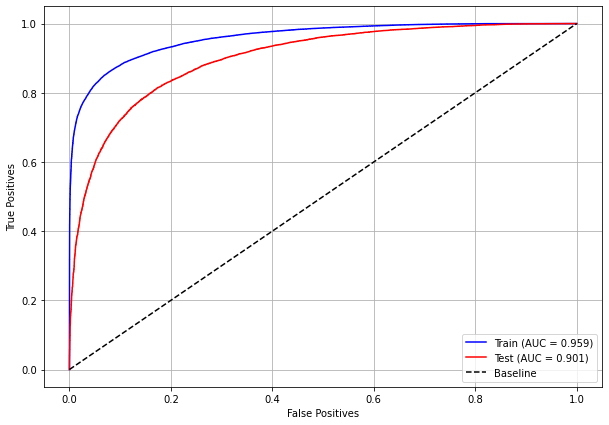

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

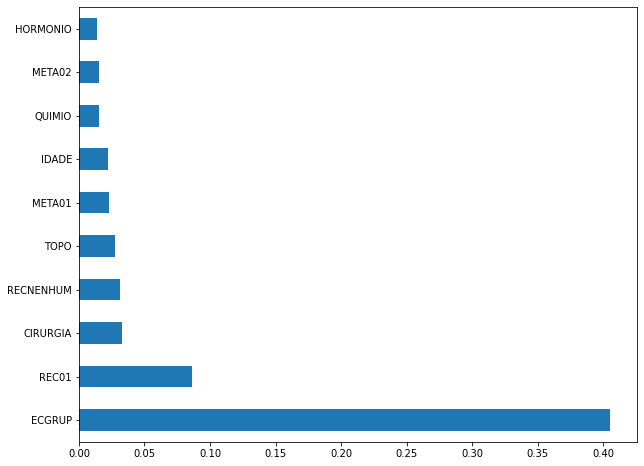

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

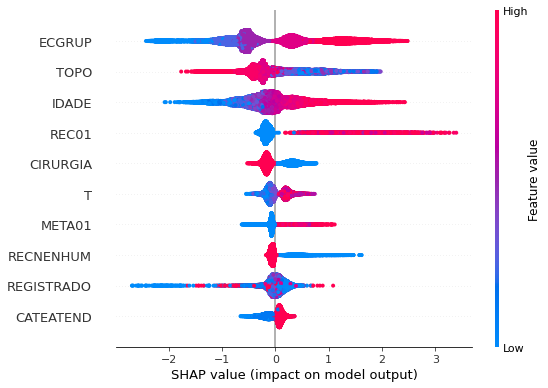

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=1.95)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.95)

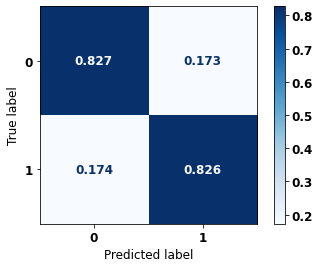


              precision    recall  f1-score   support

           0       0.88      0.83      0.85     21278
           1       0.75      0.83      0.79     13352

    accuracy                           0.83     34630
   macro avg       0.82      0.83      0.82     34630
weighted avg       0.83      0.83      0.83     34630



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

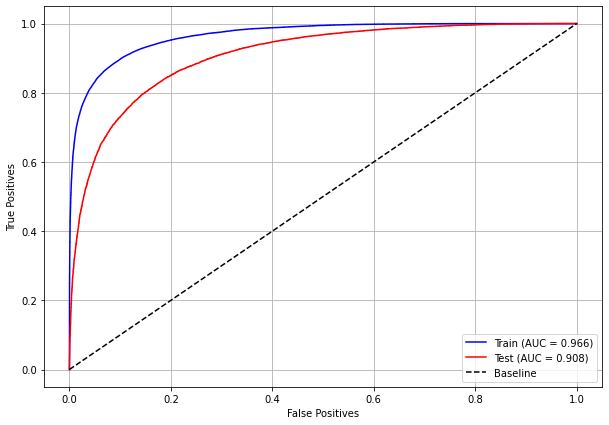

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

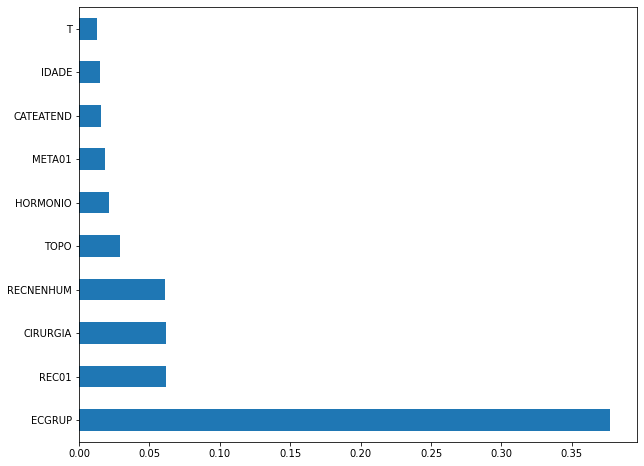

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

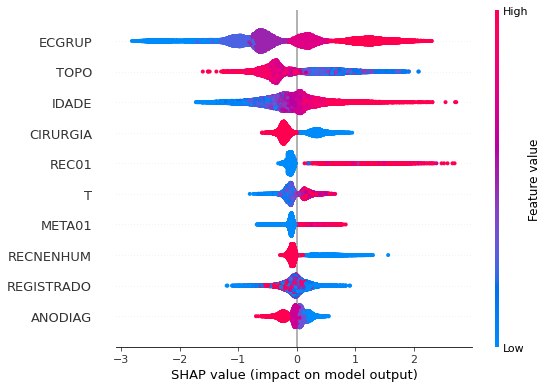

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=3.6)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=3.6)

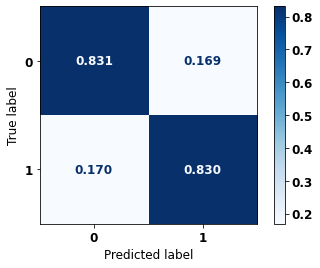


              precision    recall  f1-score   support

           0       0.93      0.83      0.88     19595
           1       0.64      0.83      0.72      7031

    accuracy                           0.83     26626
   macro avg       0.78      0.83      0.80     26626
weighted avg       0.85      0.83      0.84     26626



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.


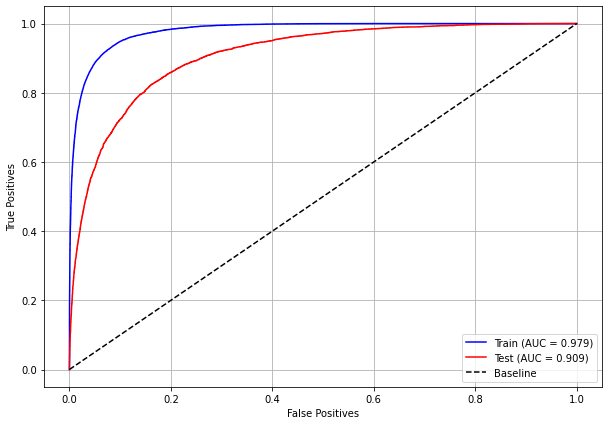

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

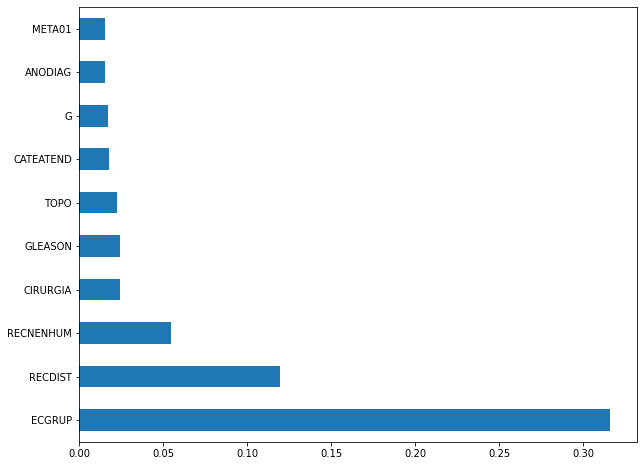

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECDIST`, `RECNENHUM` and `CIRURGIA`.

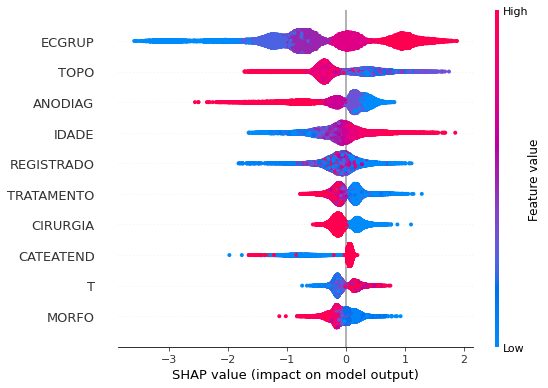

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [131]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=0.75,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=0.75)

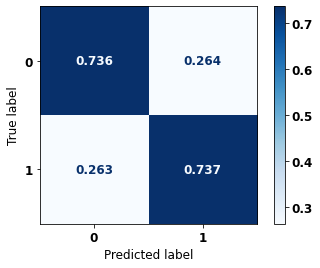


              precision    recall  f1-score   support

           0       0.66      0.74      0.70       383
           1       0.80      0.74      0.77       552

    accuracy                           0.74       935
   macro avg       0.73      0.74      0.73       935
weighted avg       0.74      0.74      0.74       935



In [132]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 74% of accuracy.

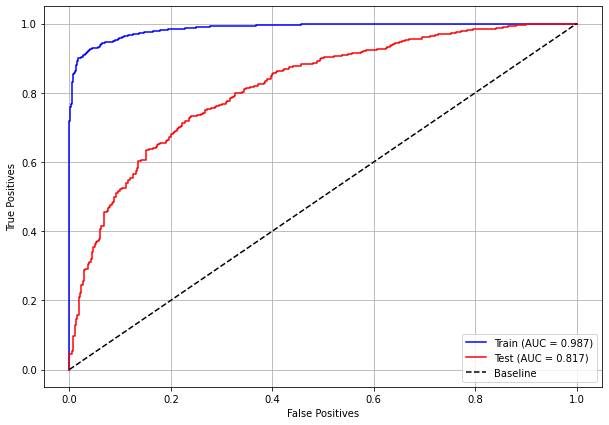

In [133]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

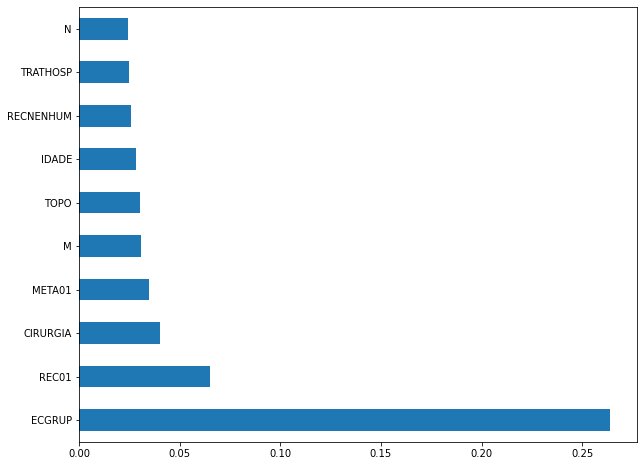

In [134]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `META01`.

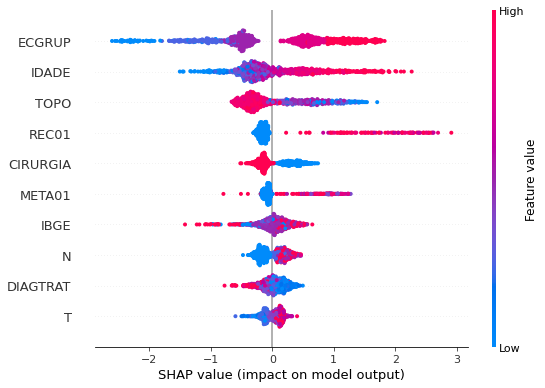

In [135]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [138]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.35,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.35)

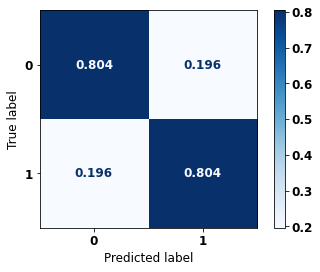


              precision    recall  f1-score   support

           0       0.81      0.80      0.81       672
           1       0.80      0.80      0.80       643

    accuracy                           0.80      1315
   macro avg       0.80      0.80      0.80      1315
weighted avg       0.80      0.80      0.80      1315



In [139]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 80% of accuracy.

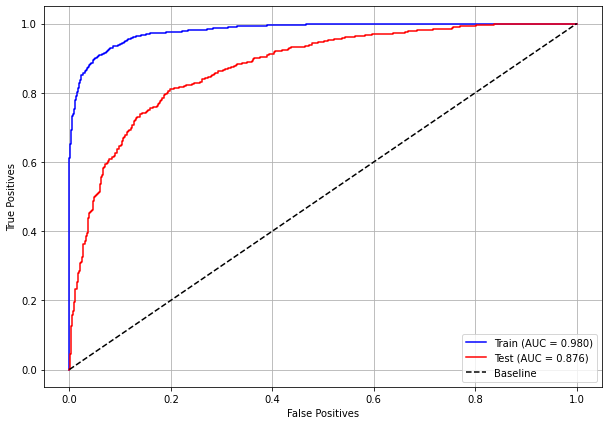

In [140]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

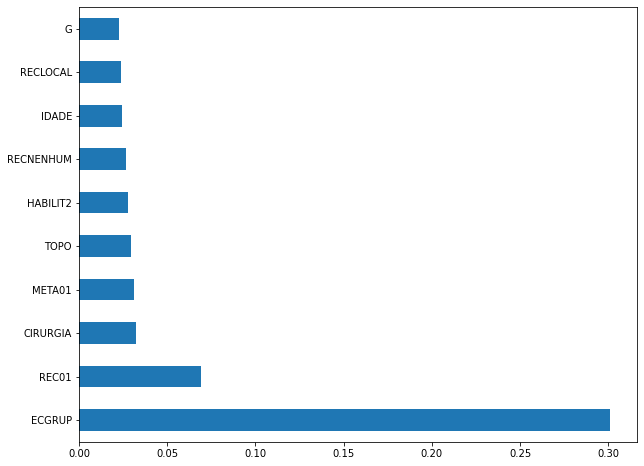

In [141]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `META01`.

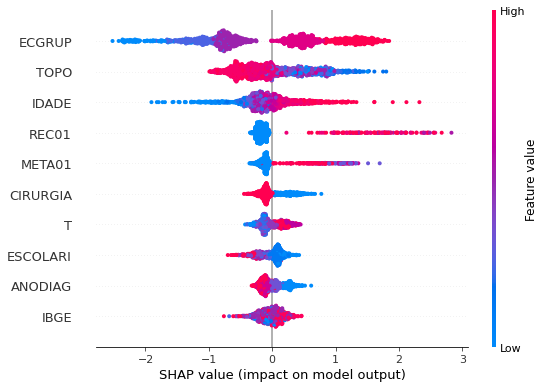

In [142]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [147]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.95,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.95)

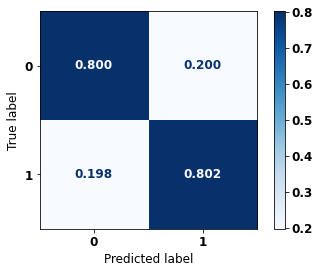


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       913
           1       0.75      0.80      0.78       701

    accuracy                           0.80      1614
   macro avg       0.80      0.80      0.80      1614
weighted avg       0.80      0.80      0.80      1614



In [148]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 80% of accuracy.

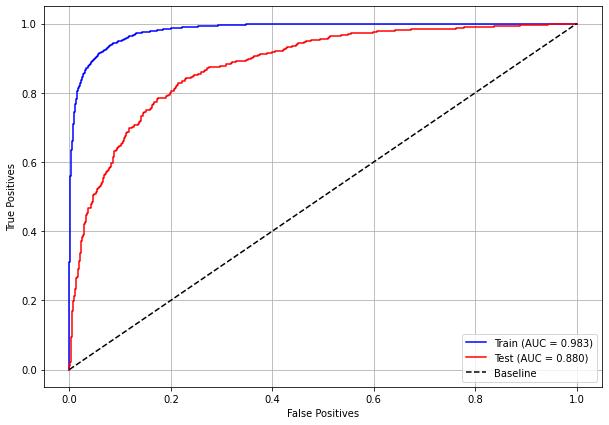

In [149]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

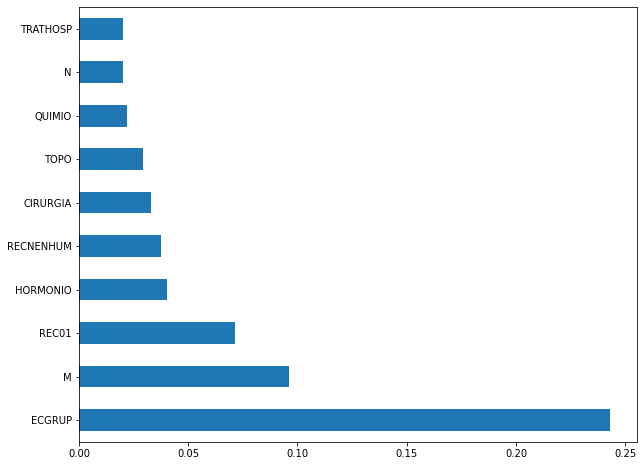

In [150]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, with a lot advantage. The following most important features were `M`, `REC01` and `HORMONIO`.

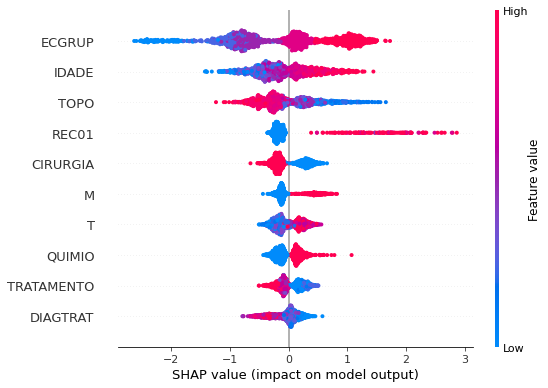

In [151]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [156]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=3,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=3)

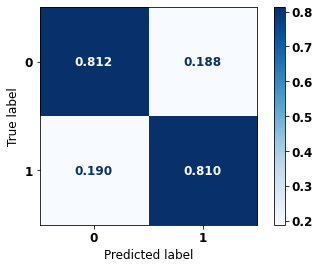


              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1447
           1       0.68      0.81      0.74       706

    accuracy                           0.81      2153
   macro avg       0.79      0.81      0.80      2153
weighted avg       0.83      0.81      0.82      2153



In [157]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 81% of accuracy.

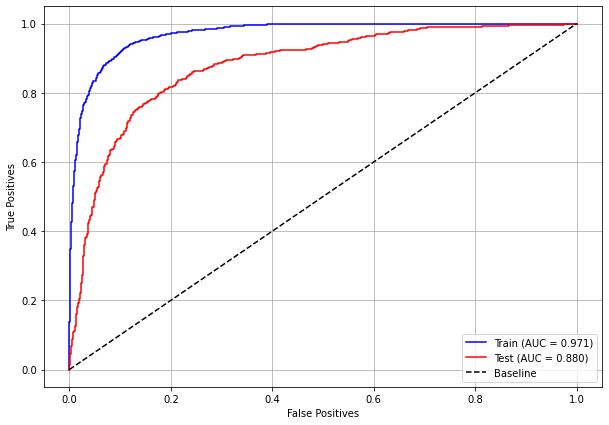

In [158]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

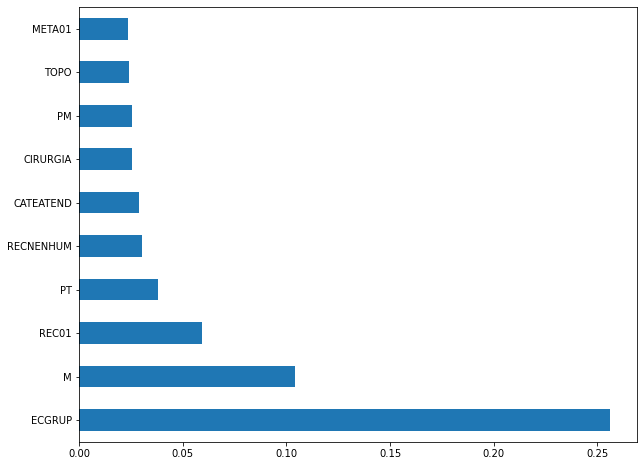

In [159]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `M`, `REC01` and `PT`.

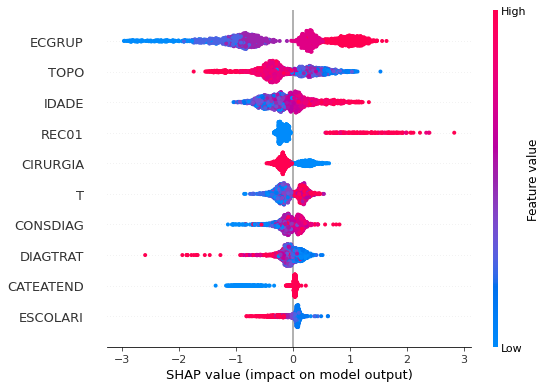

In [160]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [163]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=4,
                                   random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=4)

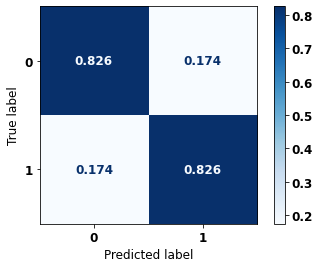


              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1632
           1       0.63      0.83      0.71       576

    accuracy                           0.83      2208
   macro avg       0.78      0.83      0.79      2208
weighted avg       0.85      0.83      0.83      2208



In [164]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 83% of accuracy.

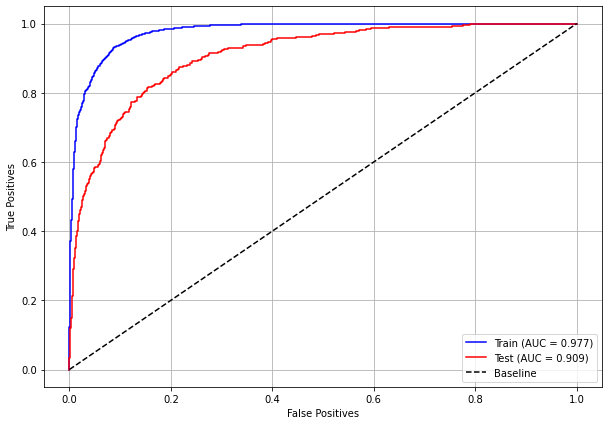

In [165]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

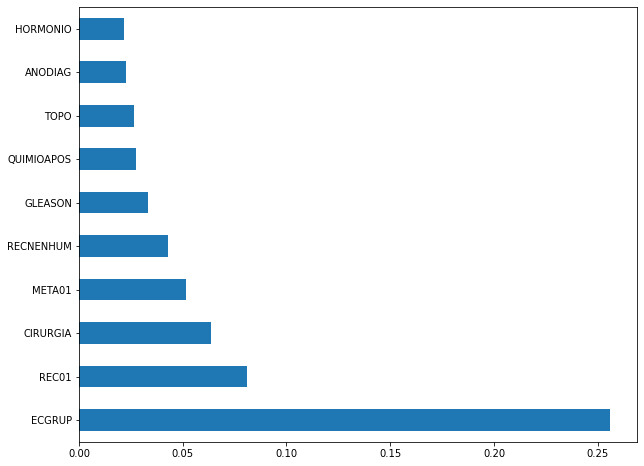

In [166]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `REC01`, `CIRURGIA` and `META01`.

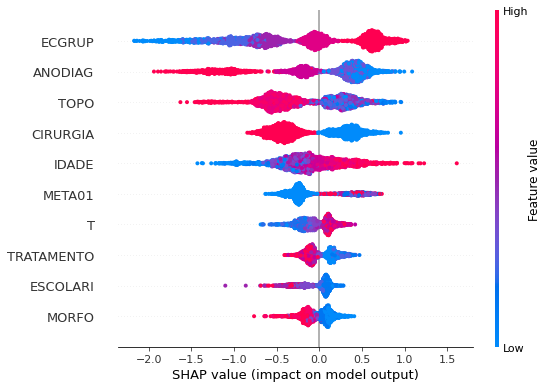

In [167]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

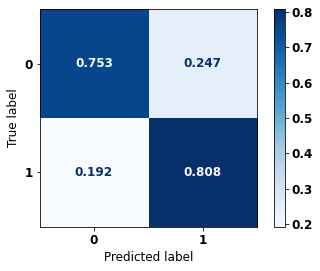


              precision    recall  f1-score   support

           0       0.74      0.75      0.75      8835
           1       0.82      0.81      0.81     12052

    accuracy                           0.78     20887
   macro avg       0.78      0.78      0.78     20887
weighted avg       0.79      0.78      0.79     20887



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

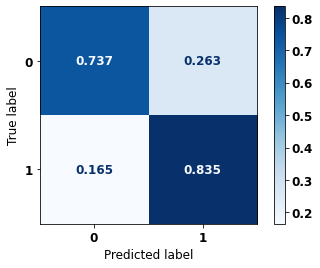


              precision    recall  f1-score   support

           0       0.81      0.74      0.77     13700
           1       0.76      0.83      0.80     14043

    accuracy                           0.79     27743
   macro avg       0.79      0.79      0.79     27743
weighted avg       0.79      0.79      0.79     27743



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

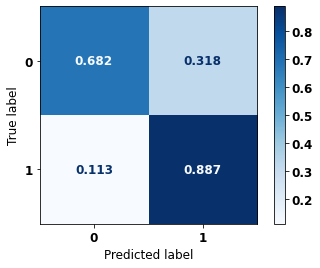


              precision    recall  f1-score   support

           0       0.91      0.68      0.78     21278
           1       0.64      0.89      0.74     13352

    accuracy                           0.76     34630
   macro avg       0.77      0.78      0.76     34630
weighted avg       0.80      0.76      0.76     34630



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

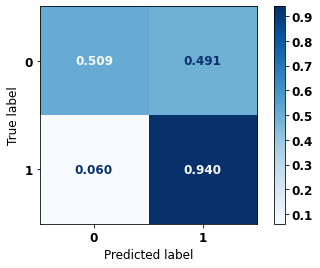


              precision    recall  f1-score   support

           0       0.96      0.51      0.66     19595
           1       0.41      0.94      0.57      7031

    accuracy                           0.62     26626
   macro avg       0.68      0.72      0.62     26626
weighted avg       0.81      0.62      0.64     26626



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

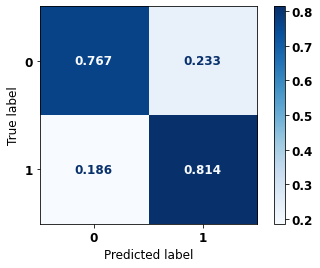


              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8835
           1       0.83      0.81      0.82     12052

    accuracy                           0.79     20887
   macro avg       0.79      0.79      0.79     20887
weighted avg       0.80      0.79      0.79     20887



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

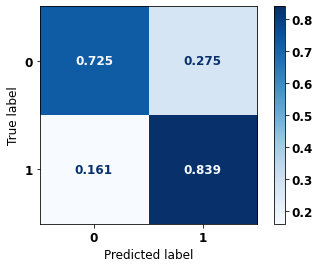


              precision    recall  f1-score   support

           0       0.81      0.73      0.77     13700
           1       0.76      0.84      0.80     14043

    accuracy                           0.78     27743
   macro avg       0.79      0.78      0.78     27743
weighted avg       0.79      0.78      0.78     27743



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

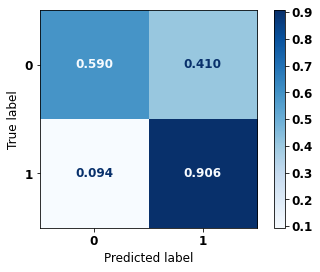


              precision    recall  f1-score   support

           0       0.91      0.59      0.72     21278
           1       0.58      0.91      0.71     13352

    accuracy                           0.71     34630
   macro avg       0.75      0.75      0.71     34630
weighted avg       0.78      0.71      0.71     34630



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

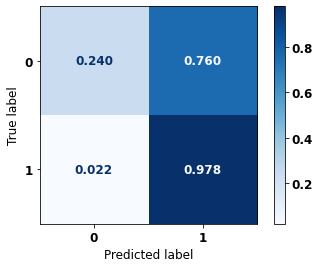


              precision    recall  f1-score   support

           0       0.97      0.24      0.38     19595
           1       0.32      0.98      0.48      7031

    accuracy                           0.43     26626
   macro avg       0.64      0.61      0.43     26626
weighted avg       0.80      0.43      0.41     26626



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

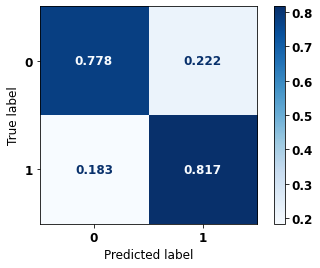


              precision    recall  f1-score   support

           0       0.81      0.78      0.79     13700
           1       0.79      0.82      0.80     14043

    accuracy                           0.80     27743
   macro avg       0.80      0.80      0.80     27743
weighted avg       0.80      0.80      0.80     27743



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

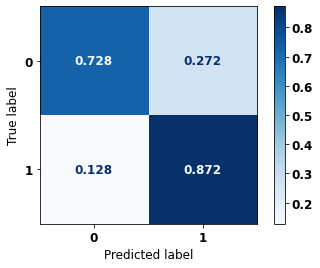


              precision    recall  f1-score   support

           0       0.90      0.73      0.81     21278
           1       0.67      0.87      0.76     13352

    accuracy                           0.78     34630
   macro avg       0.78      0.80      0.78     34630
weighted avg       0.81      0.78      0.79     34630



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

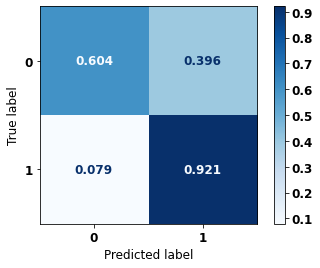


              precision    recall  f1-score   support

           0       0.96      0.60      0.74     19595
           1       0.45      0.92      0.61      7031

    accuracy                           0.69     26626
   macro avg       0.70      0.76      0.67     26626
weighted avg       0.82      0.69      0.71     26626



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

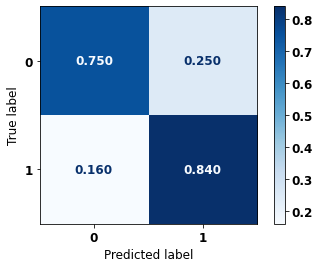


              precision    recall  f1-score   support

           0       0.82      0.75      0.78     13700
           1       0.78      0.84      0.81     14043

    accuracy                           0.80     27743
   macro avg       0.80      0.80      0.80     27743
weighted avg       0.80      0.80      0.80     27743



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

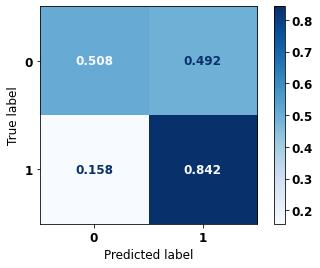


              precision    recall  f1-score   support

           0       0.84      0.51      0.63     21278
           1       0.52      0.84      0.64     13352

    accuracy                           0.64     34630
   macro avg       0.68      0.68      0.64     34630
weighted avg       0.71      0.64      0.64     34630



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

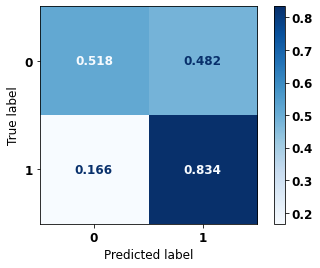


              precision    recall  f1-score   support

           0       0.90      0.52      0.66     19595
           1       0.38      0.83      0.52      7031

    accuracy                           0.60     26626
   macro avg       0.64      0.68      0.59     26626
weighted avg       0.76      0.60      0.62     26626



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

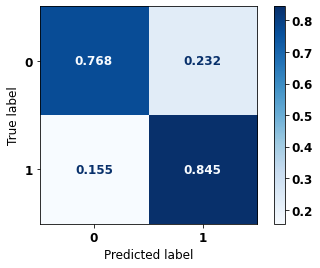


              precision    recall  f1-score   support

           0       0.89      0.77      0.82     21278
           1       0.70      0.84      0.76     13352

    accuracy                           0.80     34630
   macro avg       0.79      0.81      0.79     34630
weighted avg       0.81      0.80      0.80     34630



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

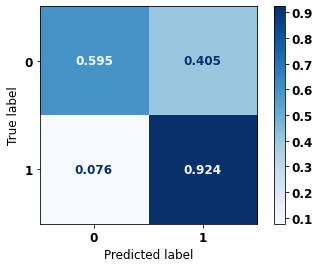


              precision    recall  f1-score   support

           0       0.96      0.60      0.73     19595
           1       0.45      0.92      0.61      7031

    accuracy                           0.68     26626
   macro avg       0.70      0.76      0.67     26626
weighted avg       0.82      0.68      0.70     26626



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

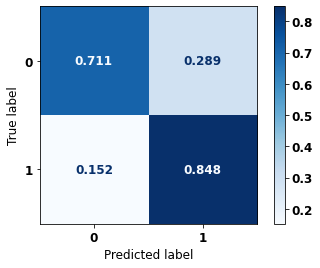


              precision    recall  f1-score   support

           0       0.88      0.71      0.79     21278
           1       0.65      0.85      0.73     13352

    accuracy                           0.76     34630
   macro avg       0.76      0.78      0.76     34630
weighted avg       0.79      0.76      0.77     34630



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

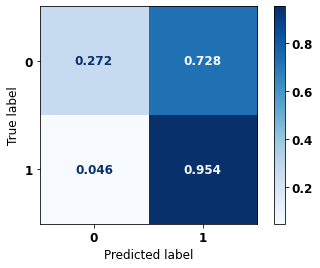


              precision    recall  f1-score   support

           0       0.94      0.27      0.42     19595
           1       0.32      0.95      0.48      7031

    accuracy                           0.45     26626
   macro avg       0.63      0.61      0.45     26626
weighted avg       0.78      0.45      0.44     26626



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

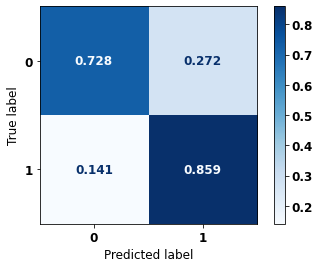


              precision    recall  f1-score   support

           0       0.94      0.73      0.82     19595
           1       0.53      0.86      0.66      7031

    accuracy                           0.76     26626
   macro avg       0.73      0.79      0.74     26626
weighted avg       0.83      0.76      0.78     26626



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

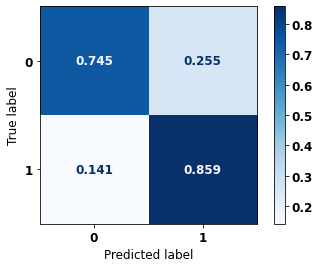


              precision    recall  f1-score   support

           0       0.94      0.74      0.83     19595
           1       0.55      0.86      0.67      7031

    accuracy                           0.77     26626
   macro avg       0.74      0.80      0.75     26626
weighted avg       0.83      0.77      0.79     26626



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

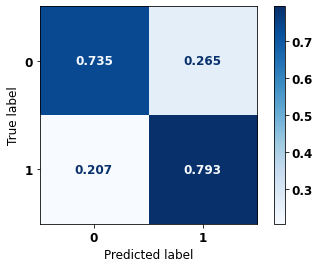


              precision    recall  f1-score   support

           0       0.79      0.74      0.76       672
           1       0.74      0.79      0.77       643

    accuracy                           0.76      1315
   macro avg       0.76      0.76      0.76      1315
weighted avg       0.77      0.76      0.76      1315



In [168]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

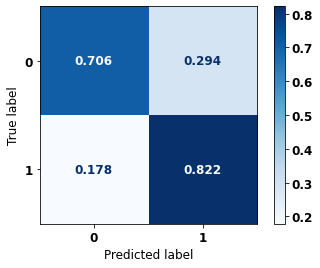


              precision    recall  f1-score   support

           0       0.84      0.71      0.77       913
           1       0.68      0.82      0.75       701

    accuracy                           0.76      1614
   macro avg       0.76      0.76      0.76      1614
weighted avg       0.77      0.76      0.76      1614



In [169]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

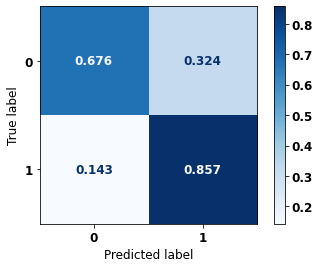


              precision    recall  f1-score   support

           0       0.91      0.68      0.77      1447
           1       0.56      0.86      0.68       706

    accuracy                           0.74      2153
   macro avg       0.73      0.77      0.73      2153
weighted avg       0.79      0.74      0.74      2153



In [170]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

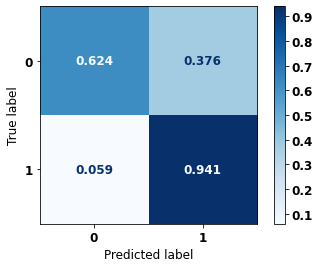


              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1632
           1       0.47      0.94      0.63       576

    accuracy                           0.71      2208
   macro avg       0.72      0.78      0.69      2208
weighted avg       0.84      0.71      0.72      2208



In [171]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

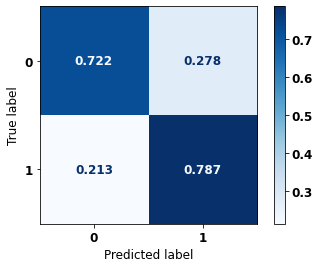


              precision    recall  f1-score   support

           0       0.78      0.72      0.75       672
           1       0.73      0.79      0.76       643

    accuracy                           0.75      1315
   macro avg       0.75      0.75      0.75      1315
weighted avg       0.76      0.75      0.75      1315



In [172]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

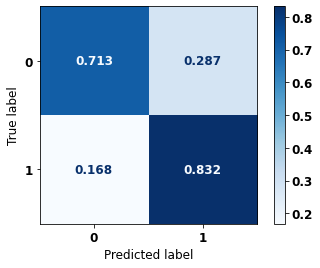


              precision    recall  f1-score   support

           0       0.85      0.71      0.77       913
           1       0.69      0.83      0.75       701

    accuracy                           0.76      1614
   macro avg       0.77      0.77      0.76      1614
weighted avg       0.78      0.76      0.77      1614



In [173]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

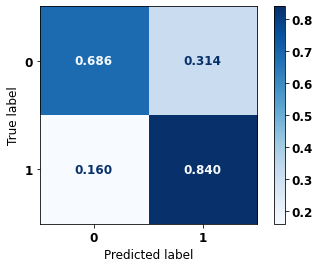


              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1447
           1       0.57      0.84      0.68       706

    accuracy                           0.74      2153
   macro avg       0.73      0.76      0.73      2153
weighted avg       0.79      0.74      0.74      2153



In [174]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

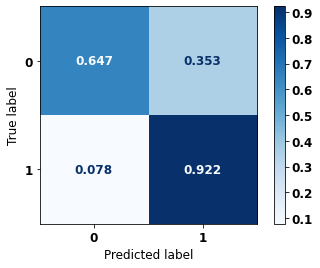


              precision    recall  f1-score   support

           0       0.96      0.65      0.77      1632
           1       0.48      0.92      0.63       576

    accuracy                           0.72      2208
   macro avg       0.72      0.78      0.70      2208
weighted avg       0.83      0.72      0.74      2208



In [175]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

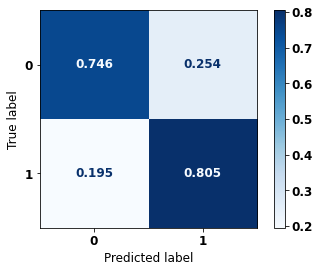


              precision    recall  f1-score   support

           0       0.83      0.75      0.79       913
           1       0.71      0.80      0.75       701

    accuracy                           0.77      1614
   macro avg       0.77      0.78      0.77      1614
weighted avg       0.78      0.77      0.77      1614



In [176]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

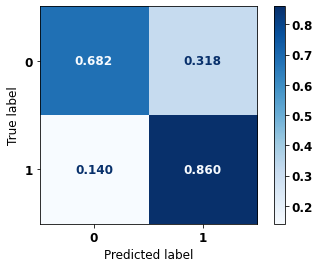


              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1447
           1       0.57      0.86      0.68       706

    accuracy                           0.74      2153
   macro avg       0.74      0.77      0.73      2153
weighted avg       0.80      0.74      0.75      2153



In [177]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

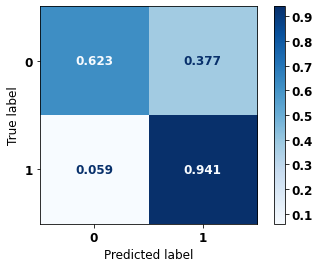


              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1632
           1       0.47      0.94      0.63       576

    accuracy                           0.71      2208
   macro avg       0.72      0.78      0.69      2208
weighted avg       0.84      0.71      0.72      2208



In [178]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

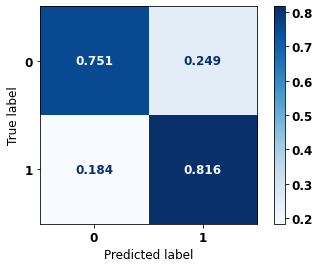


              precision    recall  f1-score   support

           0       0.84      0.75      0.79       913
           1       0.72      0.82      0.76       701

    accuracy                           0.78      1614
   macro avg       0.78      0.78      0.78      1614
weighted avg       0.79      0.78      0.78      1614



In [179]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

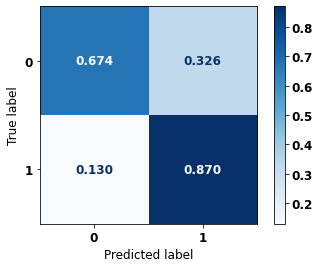


              precision    recall  f1-score   support

           0       0.91      0.67      0.78      1447
           1       0.57      0.87      0.69       706

    accuracy                           0.74      2153
   macro avg       0.74      0.77      0.73      2153
weighted avg       0.80      0.74      0.75      2153



In [180]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

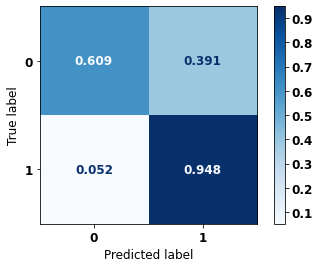


              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1632
           1       0.46      0.95      0.62       576

    accuracy                           0.70      2208
   macro avg       0.72      0.78      0.68      2208
weighted avg       0.84      0.70      0.72      2208



In [181]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

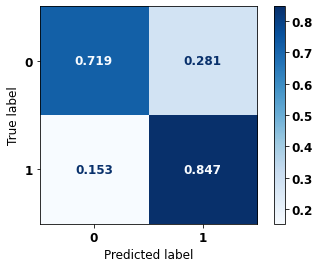


              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1447
           1       0.60      0.85      0.70       706

    accuracy                           0.76      2153
   macro avg       0.75      0.78      0.75      2153
weighted avg       0.80      0.76      0.77      2153



In [182]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

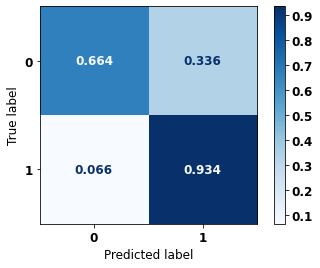


              precision    recall  f1-score   support

           0       0.97      0.66      0.79      1632
           1       0.50      0.93      0.65       576

    accuracy                           0.73      2208
   macro avg       0.73      0.80      0.72      2208
weighted avg       0.84      0.73      0.75      2208



In [183]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

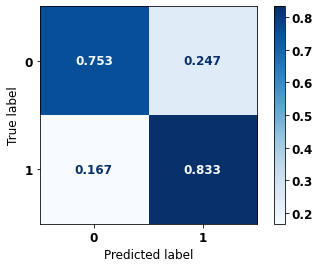


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1447
           1       0.62      0.83      0.71       706

    accuracy                           0.78      2153
   macro avg       0.76      0.79      0.77      2153
weighted avg       0.81      0.78      0.78      2153



In [184]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

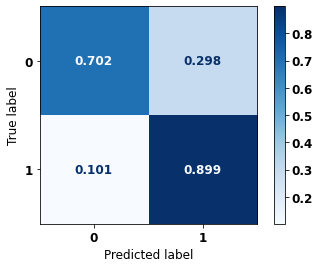


              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1632
           1       0.52      0.90      0.66       576

    accuracy                           0.75      2208
   macro avg       0.73      0.80      0.73      2208
weighted avg       0.84      0.75      0.77      2208



In [185]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

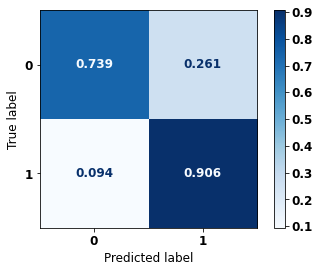


              precision    recall  f1-score   support

           0       0.96      0.74      0.83      1632
           1       0.55      0.91      0.69       576

    accuracy                           0.78      2208
   macro avg       0.75      0.82      0.76      2208
weighted avg       0.85      0.78      0.80      2208



In [186]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

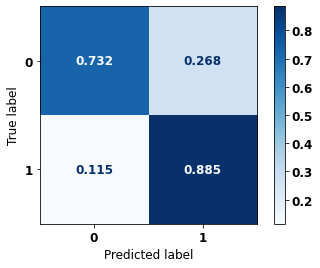


              precision    recall  f1-score   support

           0       0.95      0.73      0.83      1632
           1       0.54      0.89      0.67       576

    accuracy                           0.77      2208
   macro avg       0.74      0.81      0.75      2208
weighted avg       0.84      0.77      0.78      2208



In [187]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fourth approach**

Approach with grouped years, using only morphologies with final digit equal to 3 and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [188]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [189]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (46098, 65), X_test = (15367, 65)
y_train = (46098,), y_test = (15367,)


In [190]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (58169, 65), X_test = (19390, 65)
y_train = (58169,), y_test = (19390,)


In [191]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77412, 65), X_test = (25804, 65)
y_train = (77412,), y_test = (25804,)


In [192]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (96124, 65), X_test = (32042, 65)
y_train = (96124,), y_test = (32042,)


In [193]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2021, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73682, 65), X_test = (24561, 65)
y_train = (73682,), y_test = (24561,)


### **Other states**

In [194]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2000,
                                                                                                last_year=2003, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2592, 65), X_test = (865, 65)
y_train = (2592,), y_test = (865,)


In [195]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3694, 65), X_test = (1232, 65)
y_train = (3694,), y_test = (1232,)


In [196]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4536, 65), X_test = (1513, 65)
y_train = (4536,), y_test = (1513,)


In [197]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6069, 65), X_test = (2024, 65)
y_train = (6069,), y_test = (2024,)


In [198]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2020, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6185, 65), X_test = (2062, 65)
y_train = (6185,), y_test = (2062,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:2.155, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 2.155, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

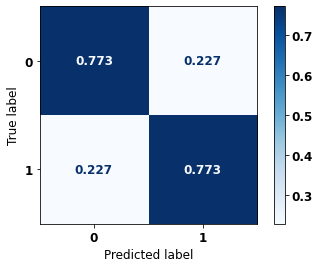


              precision    recall  f1-score   support

           0       0.61      0.77      0.68      4790
           1       0.88      0.77      0.82     10577

    accuracy                           0.77     15367
   macro avg       0.74      0.77      0.75     15367
weighted avg       0.80      0.77      0.78     15367



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 77% of accuracy.


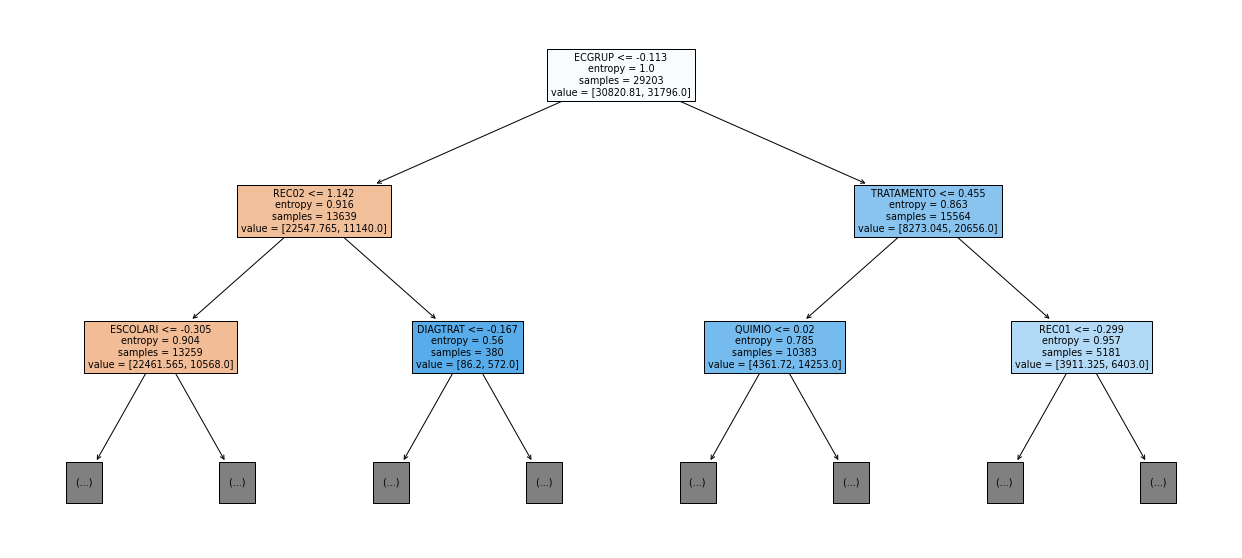

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

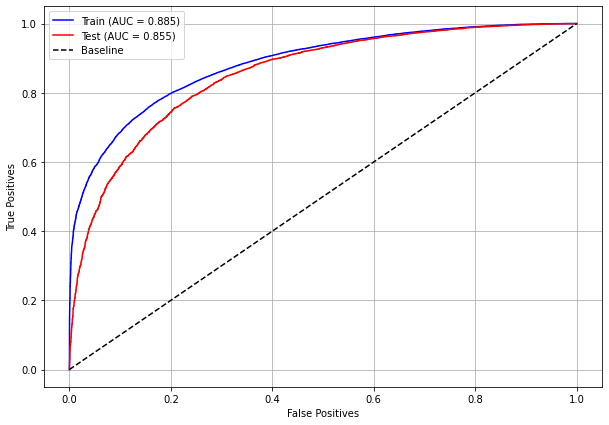

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

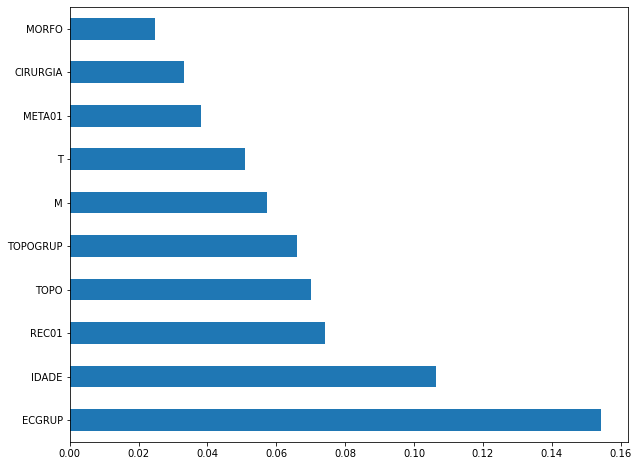

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `REC01`, and `TOPO`.

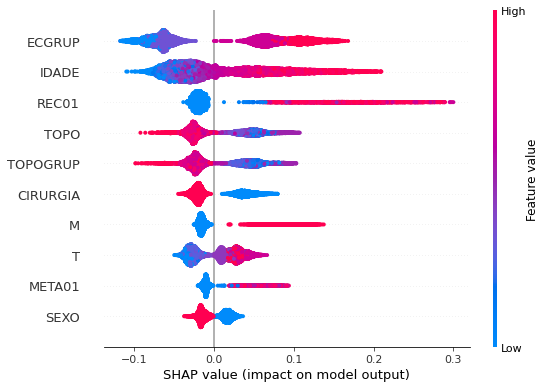

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.32, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.32, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

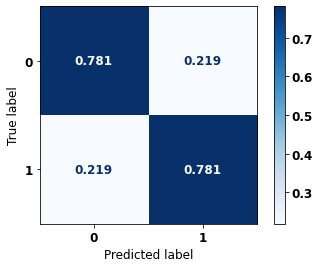


              precision    recall  f1-score   support

           0       0.69      0.78      0.74      7548
           1       0.85      0.78      0.81     11842

    accuracy                           0.78     19390
   macro avg       0.77      0.78      0.77     19390
weighted avg       0.79      0.78      0.78     19390



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 78% of accuracy.

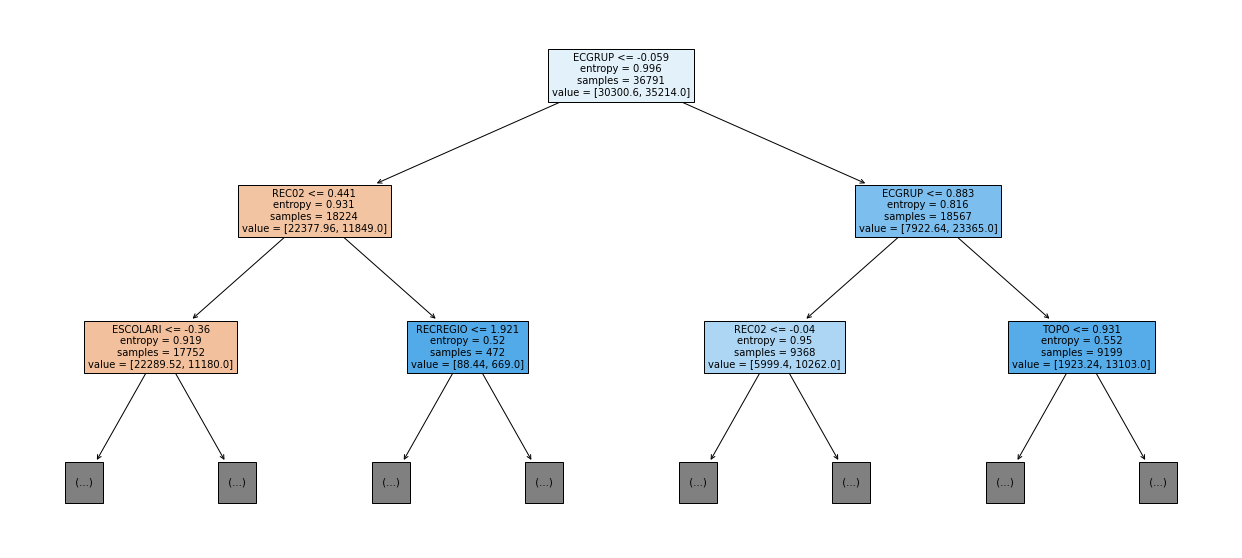

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

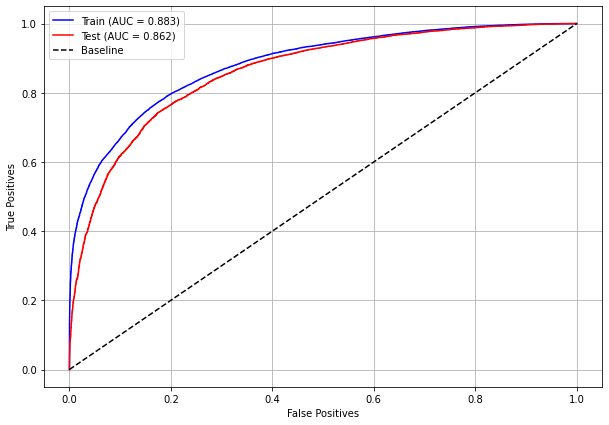

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

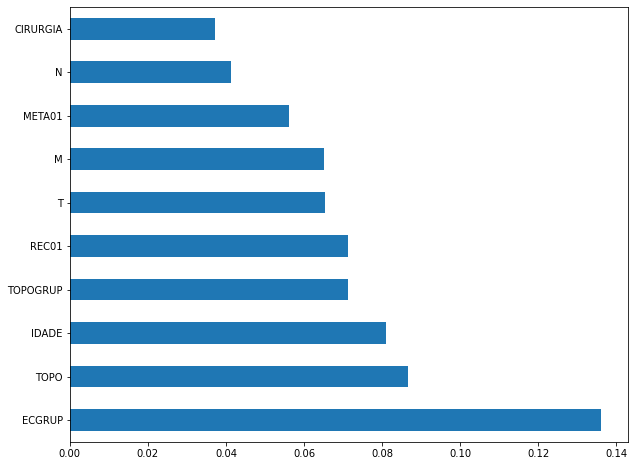

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `IDADE` and `TOPOGRUP`.

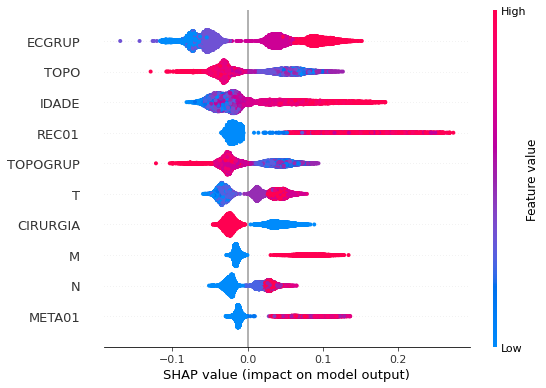

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.0975},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.0975}, criterion='entropy',
                       max_depth=10, random_state=10)

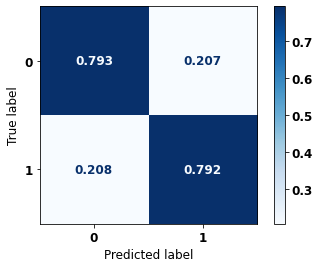


              precision    recall  f1-score   support

           0       0.77      0.79      0.78     12072
           1       0.81      0.79      0.80     13732

    accuracy                           0.79     25804
   macro avg       0.79      0.79      0.79     25804
weighted avg       0.79      0.79      0.79     25804



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 79% of accuray.

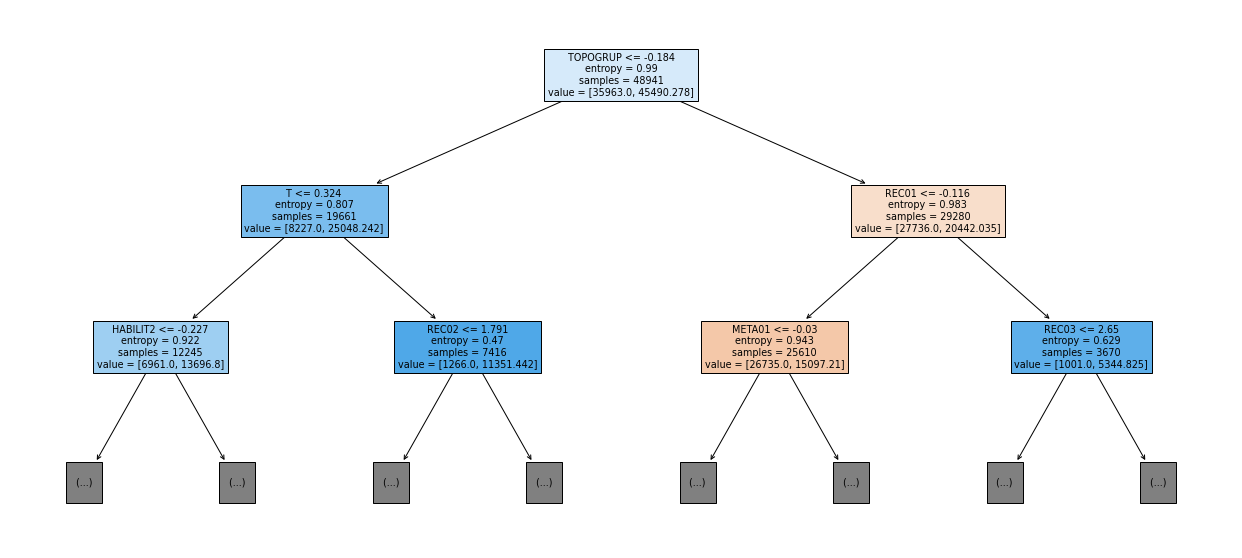

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

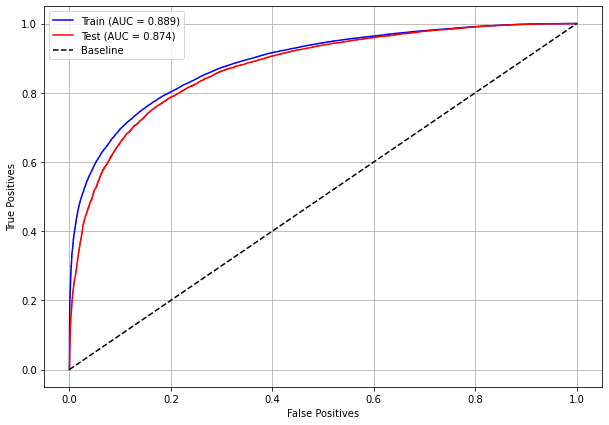

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

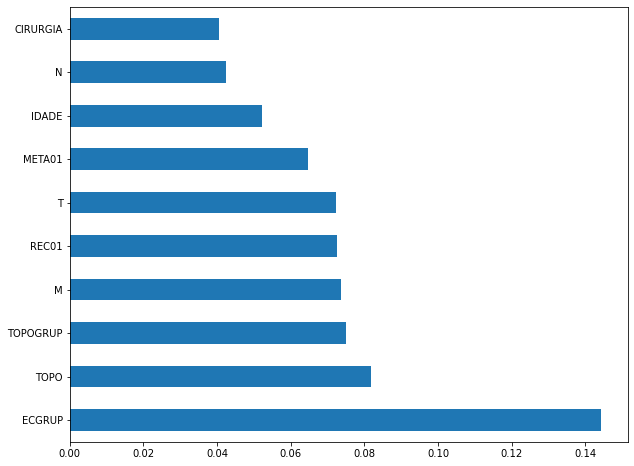

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

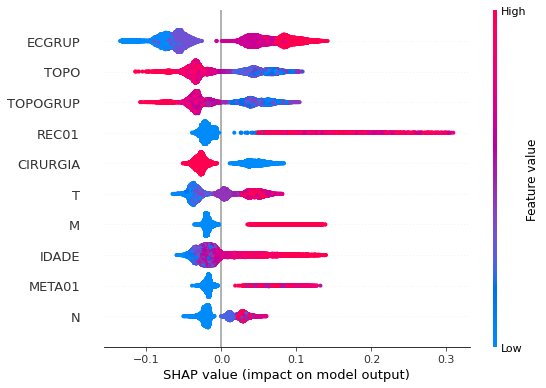

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.778},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.778}, criterion='entropy',
                       max_depth=10, random_state=10)

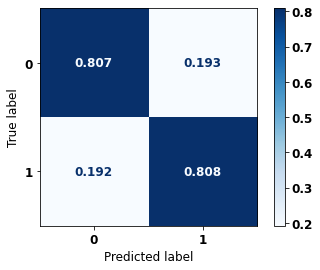


              precision    recall  f1-score   support

           0       0.86      0.81      0.83     19067
           1       0.74      0.81      0.77     12975

    accuracy                           0.81     32042
   macro avg       0.80      0.81      0.80     32042
weighted avg       0.81      0.81      0.81     32042



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

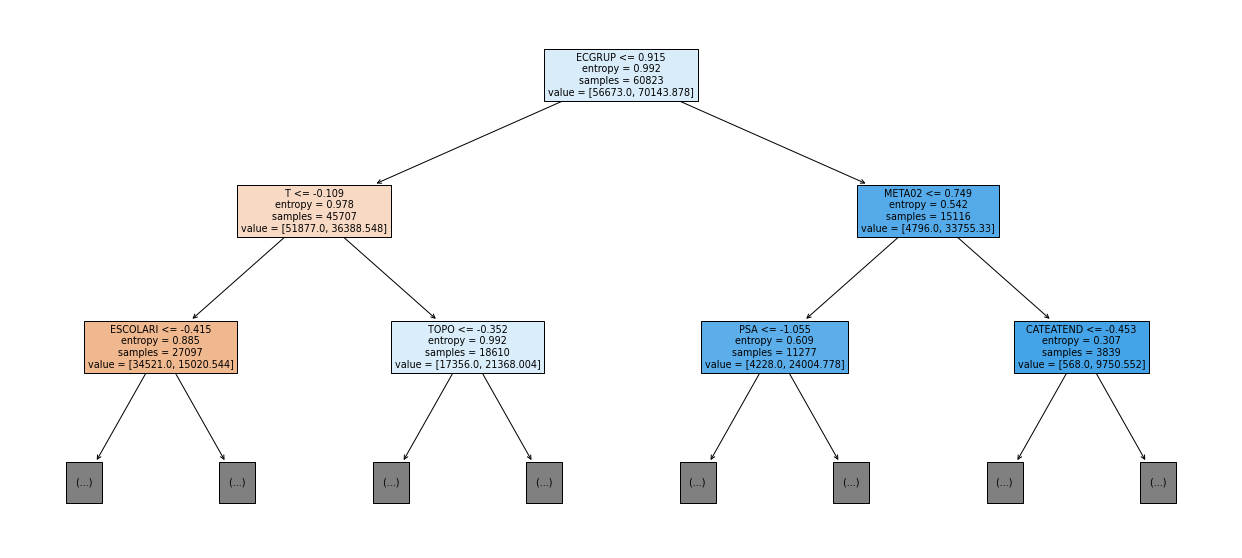

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

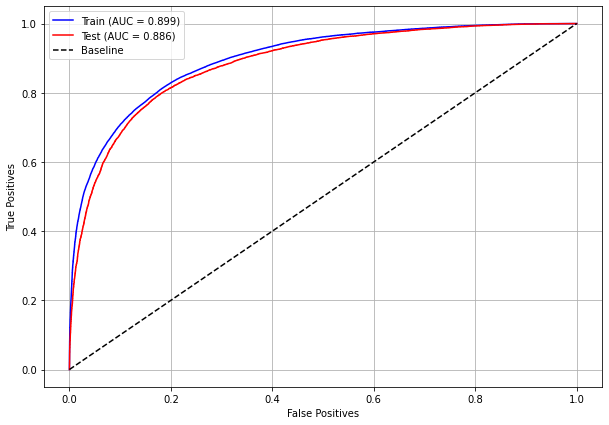

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

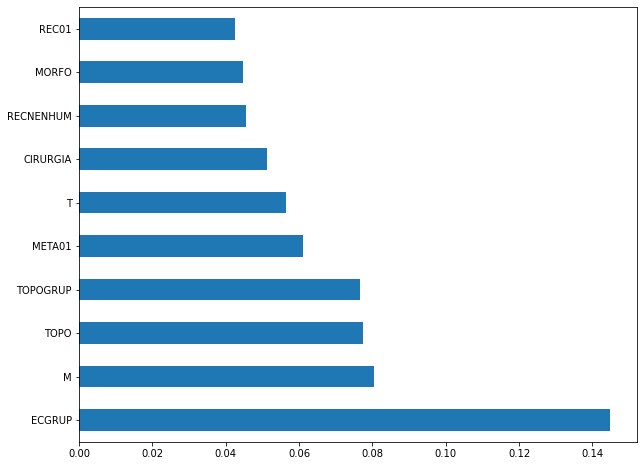

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

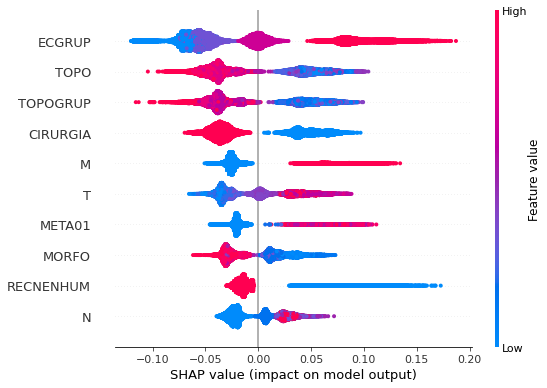

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.5},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 2.5}, criterion='entropy',
                       max_depth=10, random_state=10)

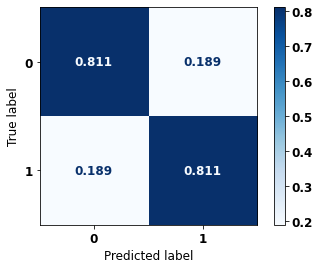


              precision    recall  f1-score   support

           0       0.92      0.81      0.86     17594
           1       0.63      0.81      0.71      6967

    accuracy                           0.81     24561
   macro avg       0.77      0.81      0.78     24561
weighted avg       0.83      0.81      0.82     24561



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

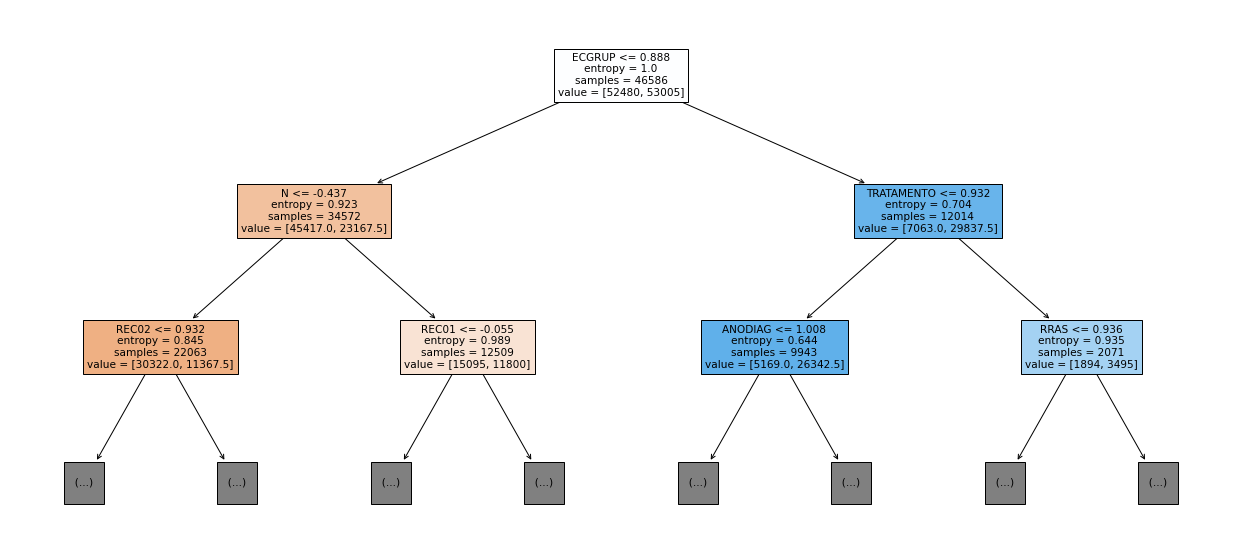

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

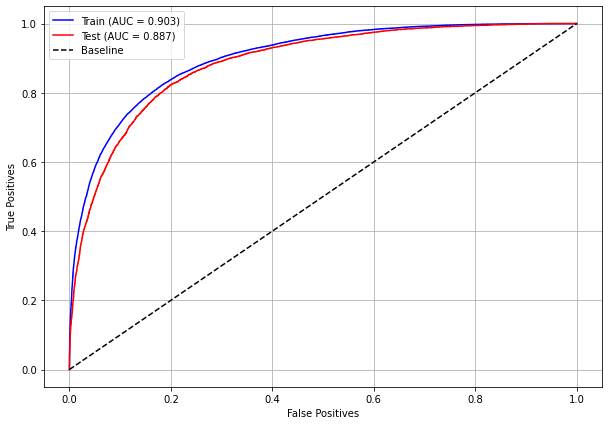

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

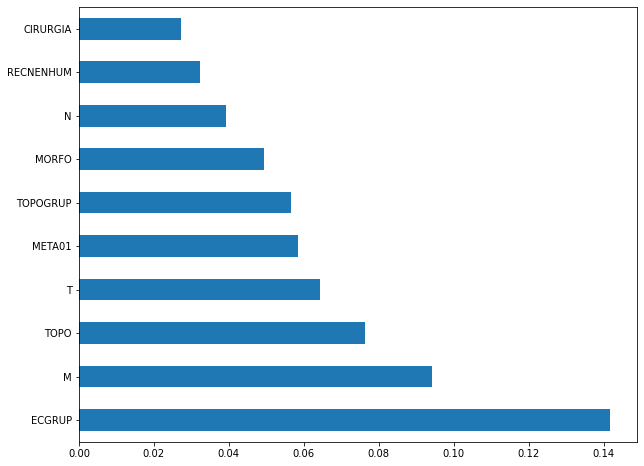

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO`, and `T`.



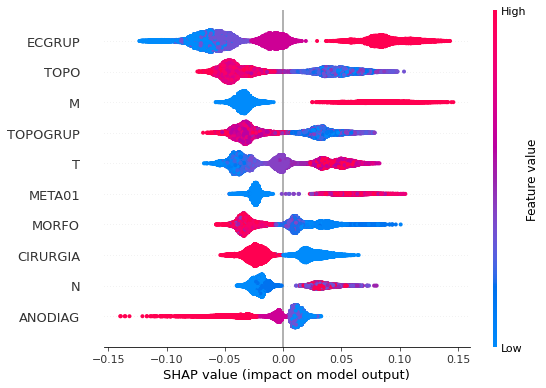

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [203]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.38, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.38, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

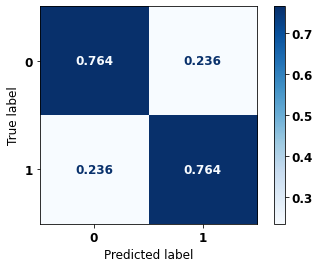


              precision    recall  f1-score   support

           0       0.66      0.76      0.71       326
           1       0.84      0.76      0.80       539

    accuracy                           0.76       865
   macro avg       0.75      0.76      0.76       865
weighted avg       0.77      0.76      0.77       865



In [204]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 76% of accuracy.

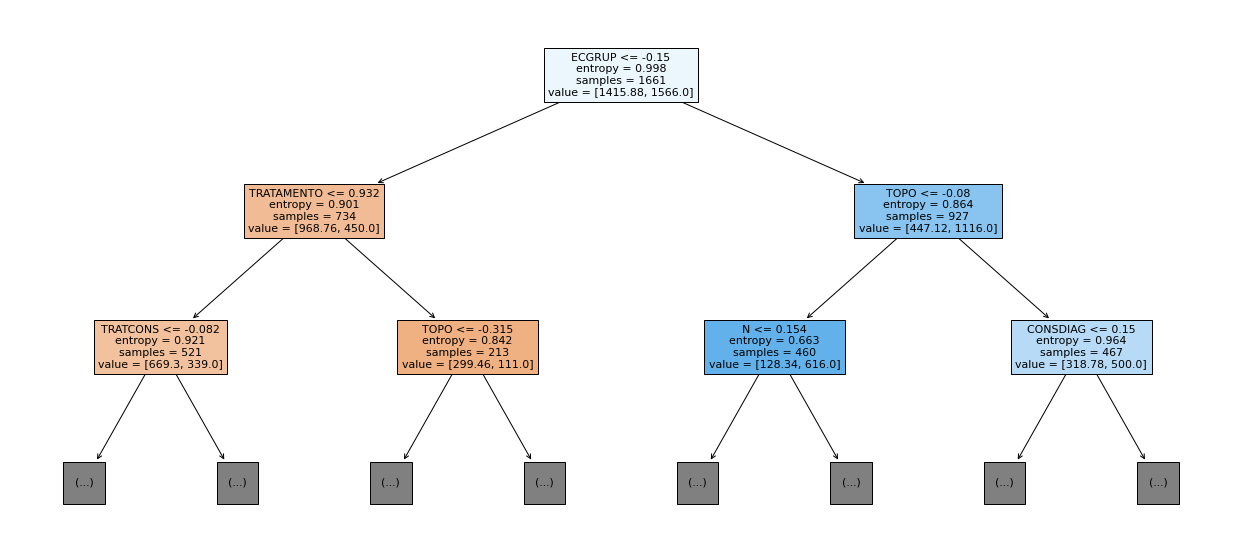

In [205]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

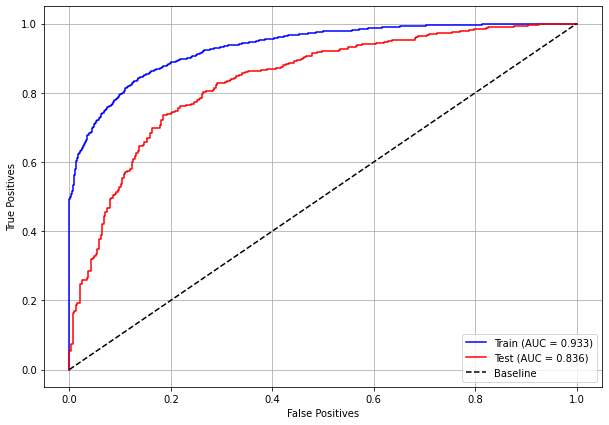

In [206]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

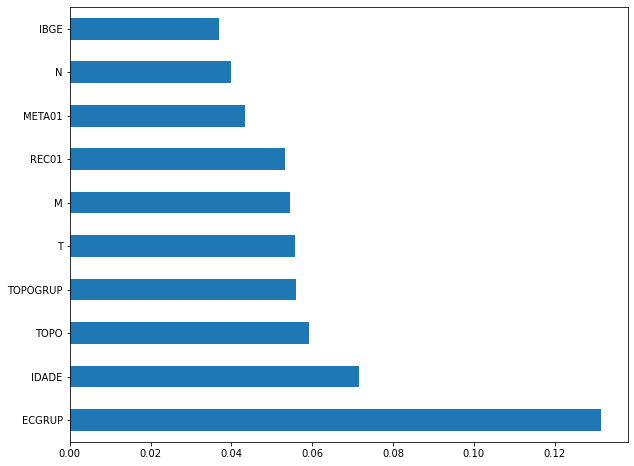

In [207]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `IDADE`, `TOPO` and `TOPOGRUP`.

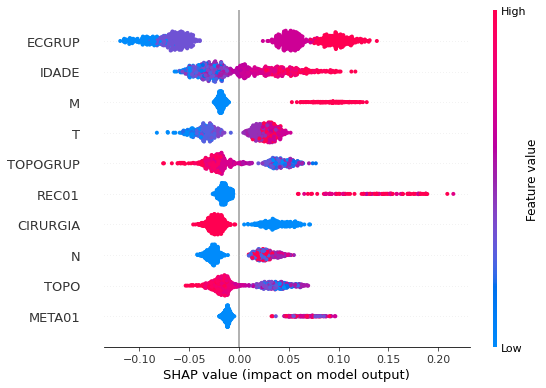

In [208]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [235]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.18},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.18}, criterion='entropy',
                       max_depth=8, random_state=10)

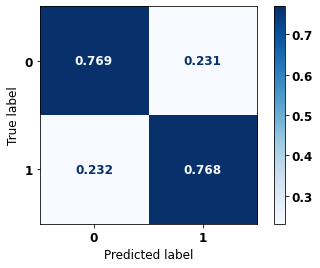


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       615
           1       0.77      0.77      0.77       617

    accuracy                           0.77      1232
   macro avg       0.77      0.77      0.77      1232
weighted avg       0.77      0.77      0.77      1232



In [236]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 77% of accuracy.


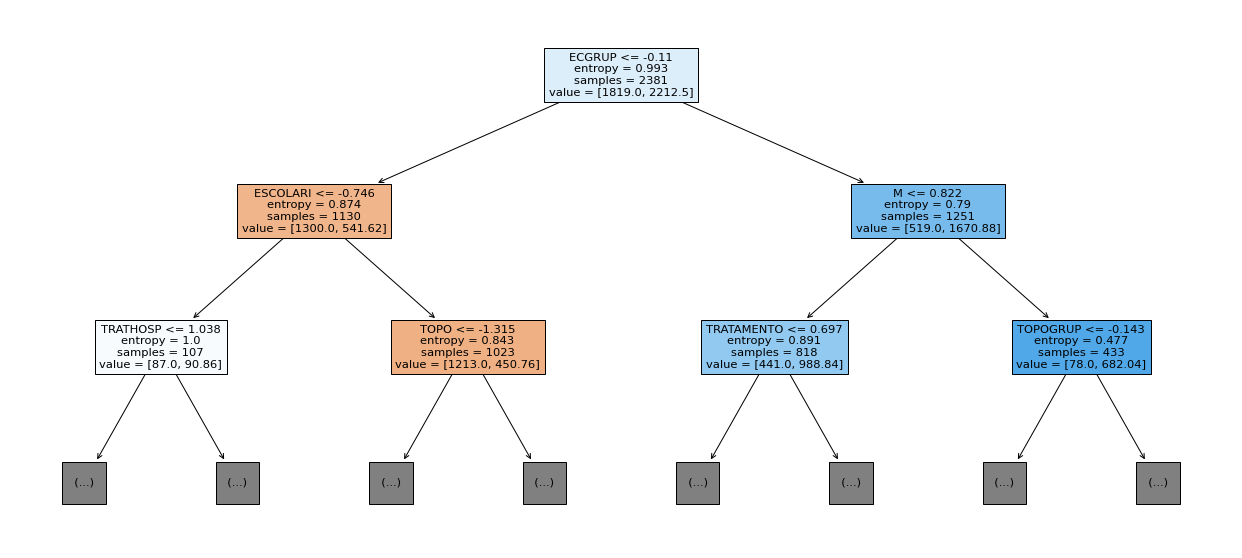

In [237]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

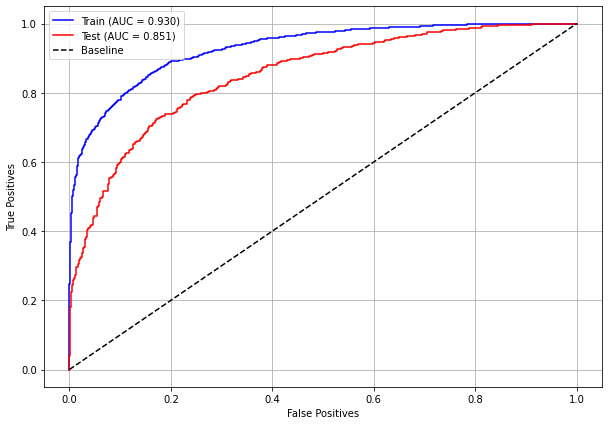

In [238]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

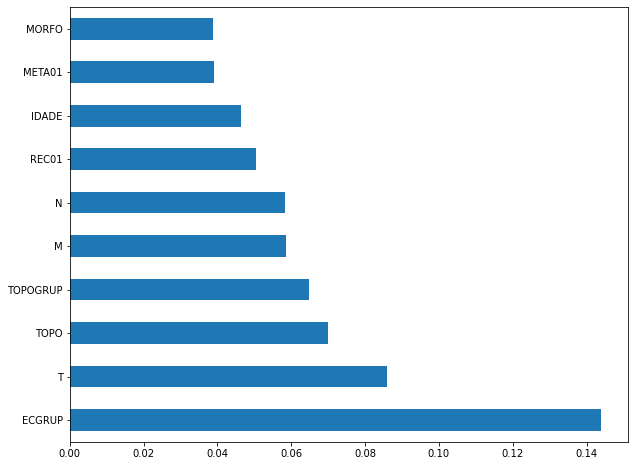

In [239]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `TOPO` and `TOPOGRUP`.

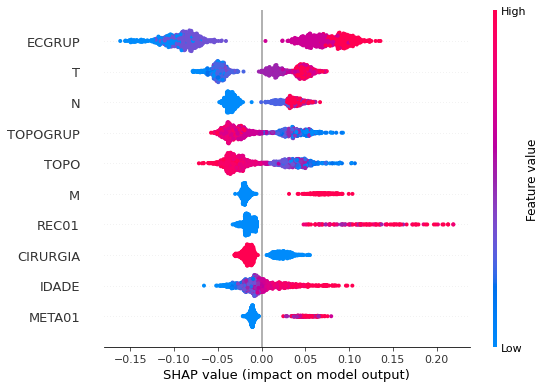

In [240]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [249]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed,
                                       class_weight={0:1, 1:1.495},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.495}, criterion='entropy',
                       max_depth=8, random_state=10)

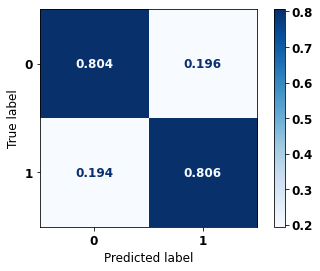


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       843
           1       0.77      0.81      0.79       670

    accuracy                           0.81      1513
   macro avg       0.80      0.81      0.80      1513
weighted avg       0.81      0.81      0.81      1513



In [250]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


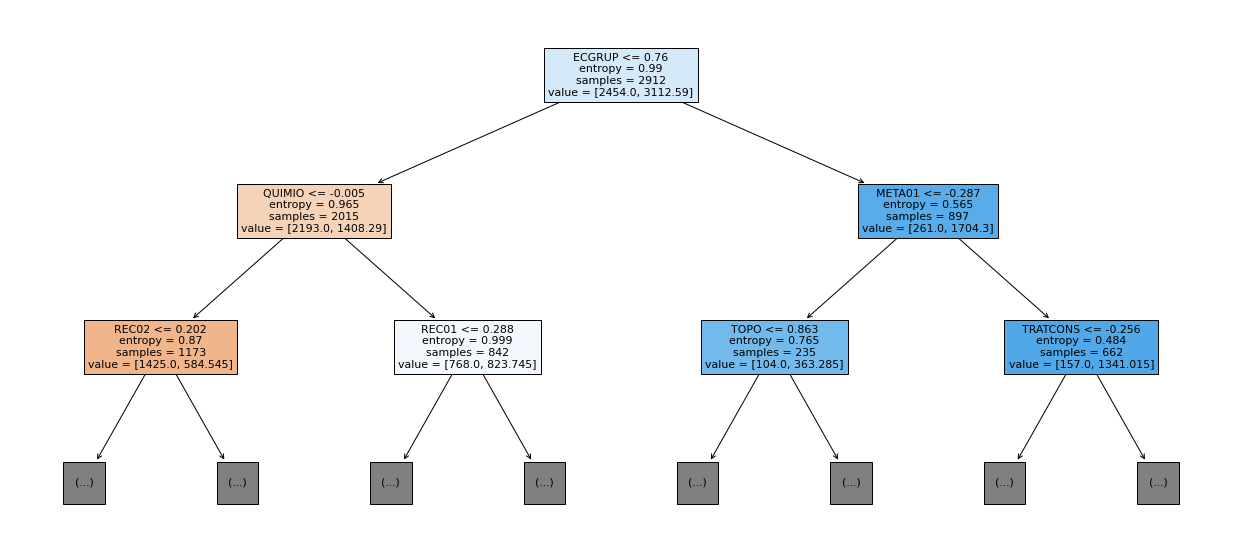

In [251]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

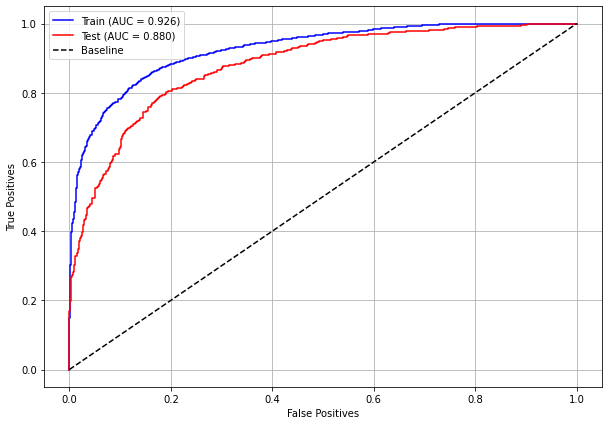

In [252]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

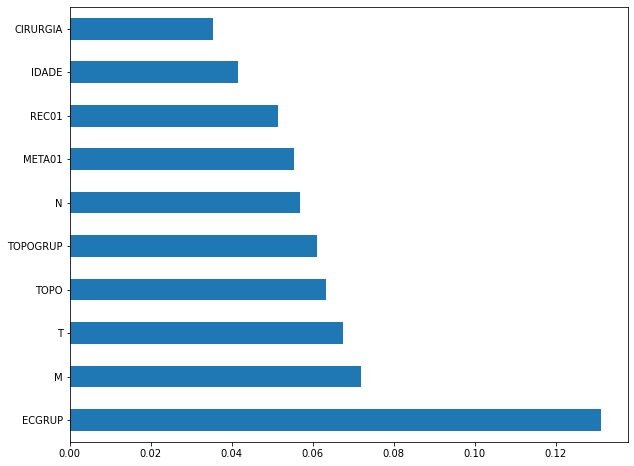

In [253]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `TOPO`.

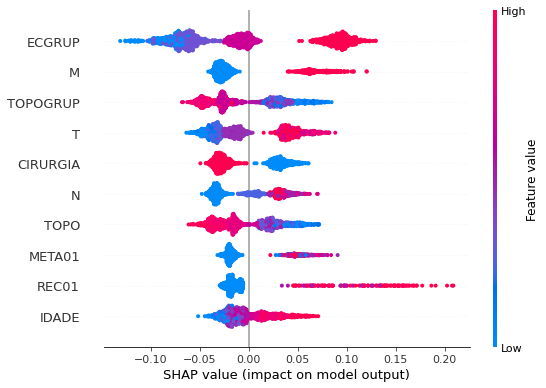

In [254]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [267]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.65},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.65}, criterion='entropy',
                       max_depth=8, random_state=10)

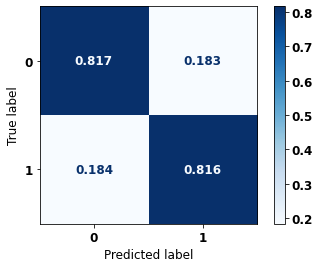


              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1319
           1       0.70      0.82      0.76       705

    accuracy                           0.82      2024
   macro avg       0.80      0.82      0.80      2024
weighted avg       0.83      0.82      0.82      2024



In [268]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 82% of accuracy.


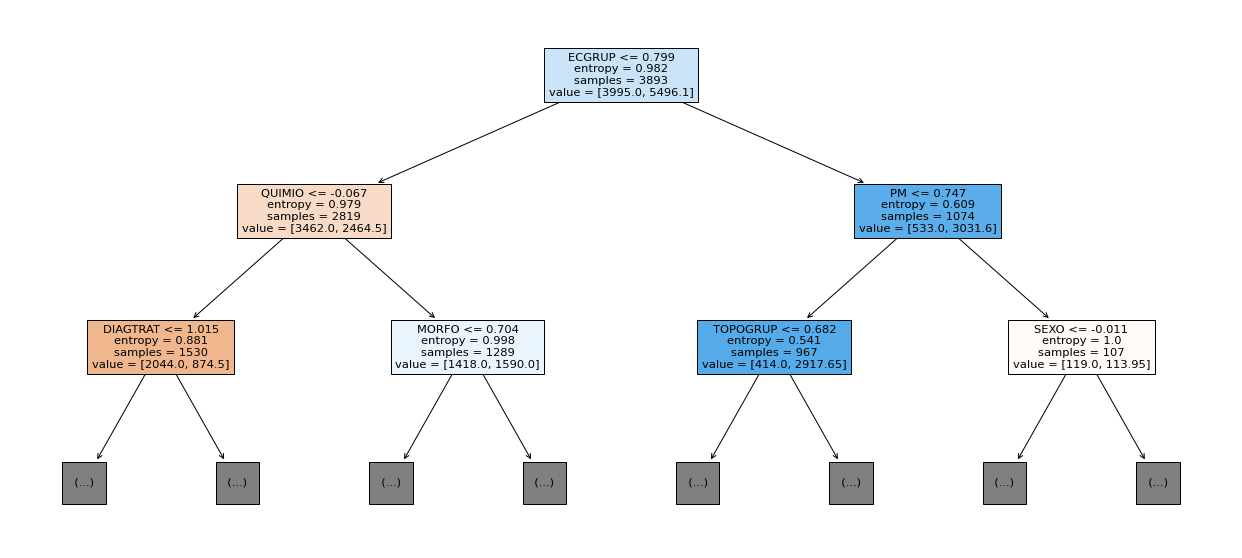

In [269]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

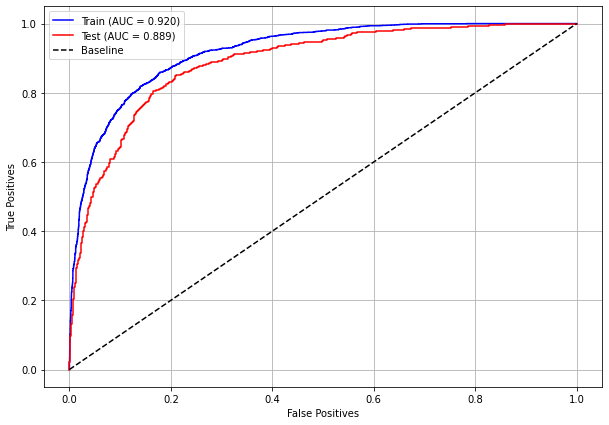

In [270]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

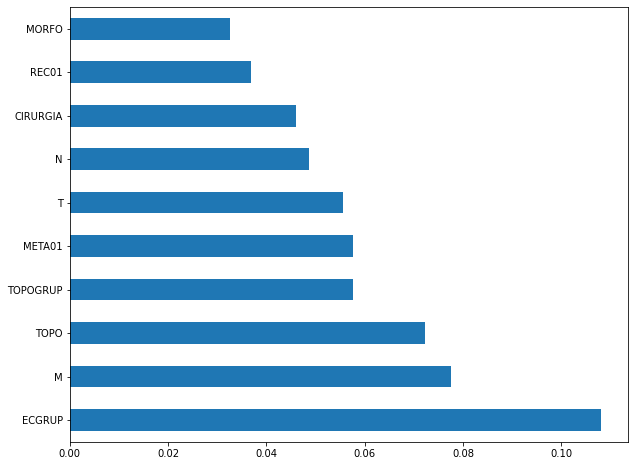

In [271]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

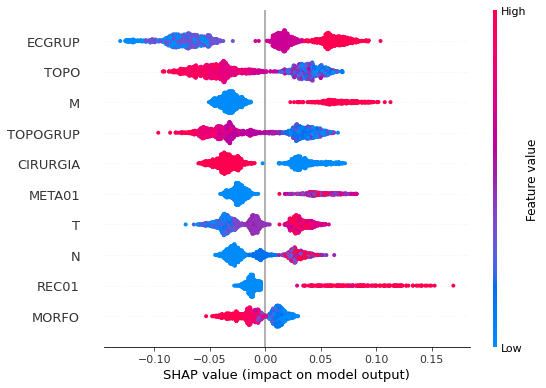

In [272]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [277]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.3},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 2.3}, criterion='entropy',
                       max_depth=8, random_state=10)

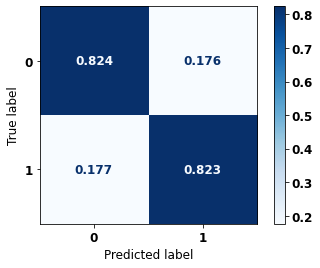


              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1558
           1       0.60      0.82      0.70       504

    accuracy                           0.82      2062
   macro avg       0.77      0.82      0.79      2062
weighted avg       0.85      0.82      0.83      2062



In [278]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 82% of accuracy.


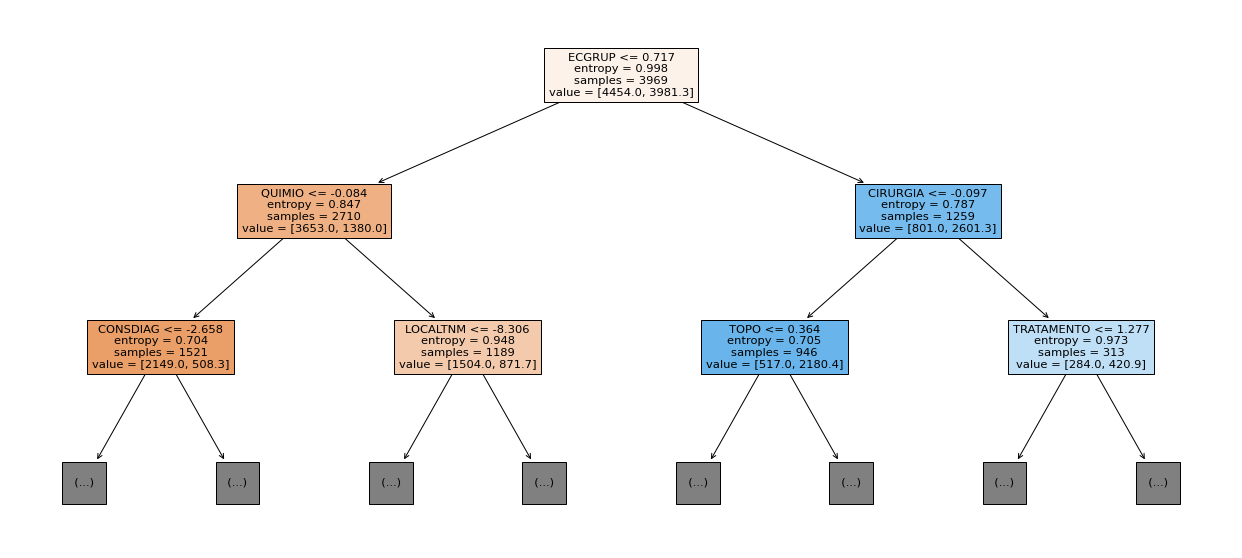

In [279]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

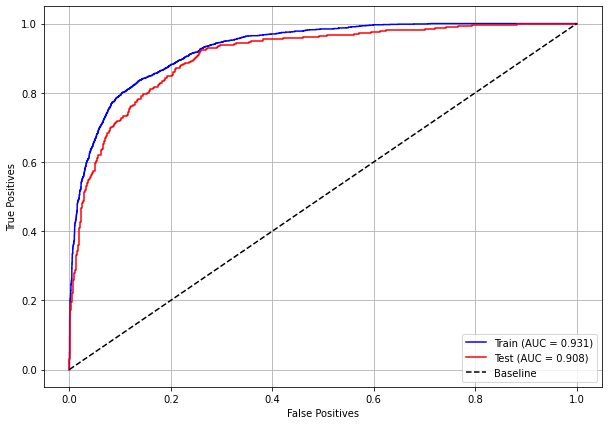

In [280]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

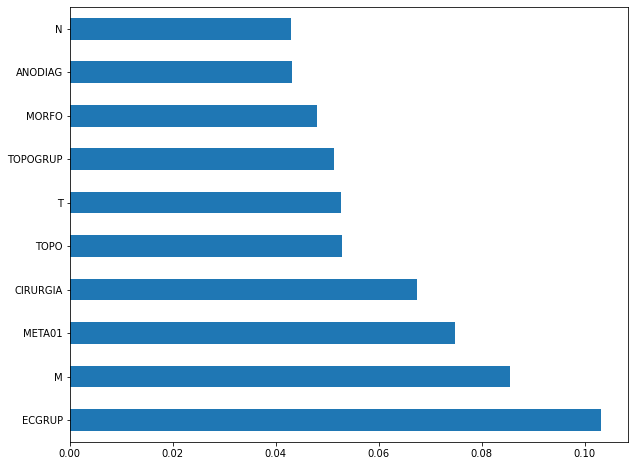

In [281]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `CIRURGIA`.

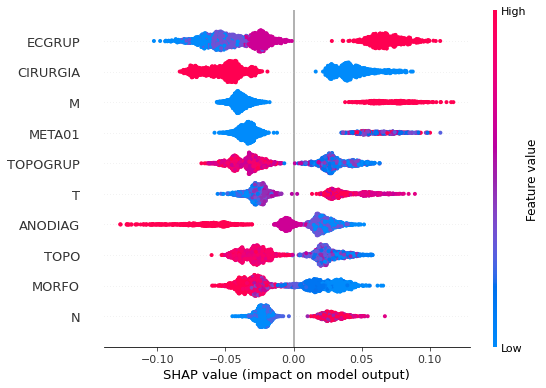

In [282]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.38)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.38)

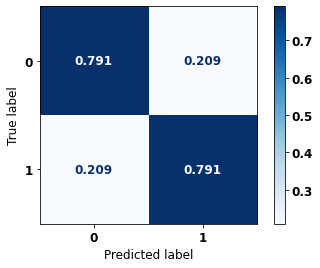


              precision    recall  f1-score   support

           0       0.63      0.79      0.70      4790
           1       0.89      0.79      0.84     10577

    accuracy                           0.79     15367
   macro avg       0.76      0.79      0.77     15367
weighted avg       0.81      0.79      0.80     15367



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, here with 79% of accuracy.

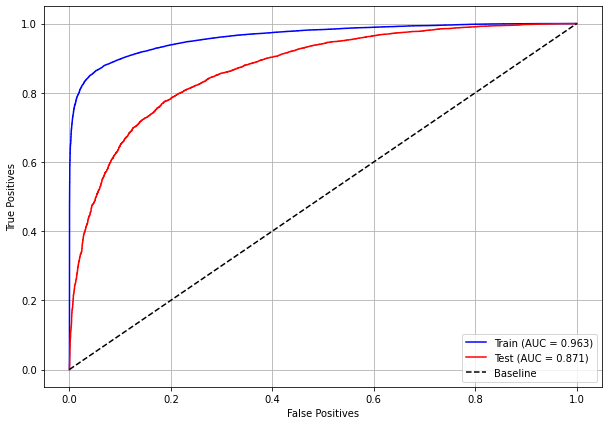

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

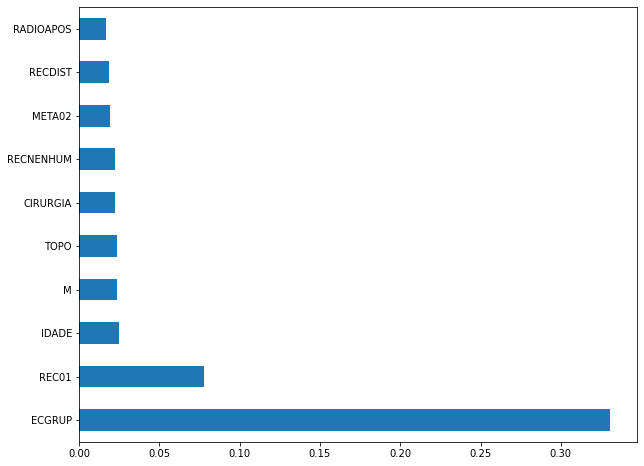

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `IDADE` and `M`.

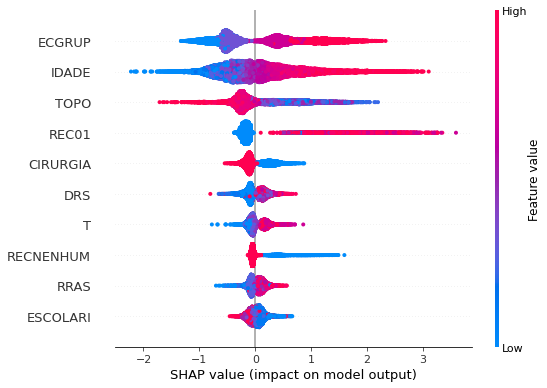

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.657)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.657)

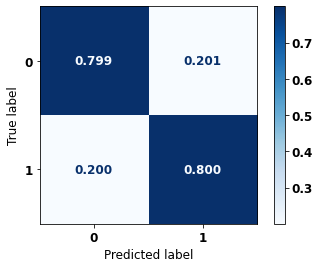


              precision    recall  f1-score   support

           0       0.72      0.80      0.76      7548
           1       0.86      0.80      0.83     11842

    accuracy                           0.80     19390
   macro avg       0.79      0.80      0.79     19390
weighted avg       0.81      0.80      0.80     19390



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.


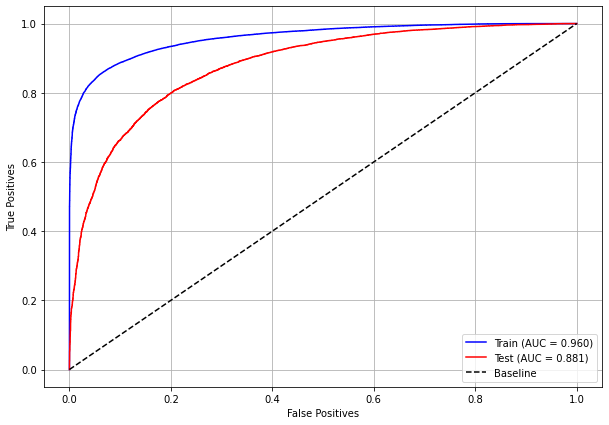

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

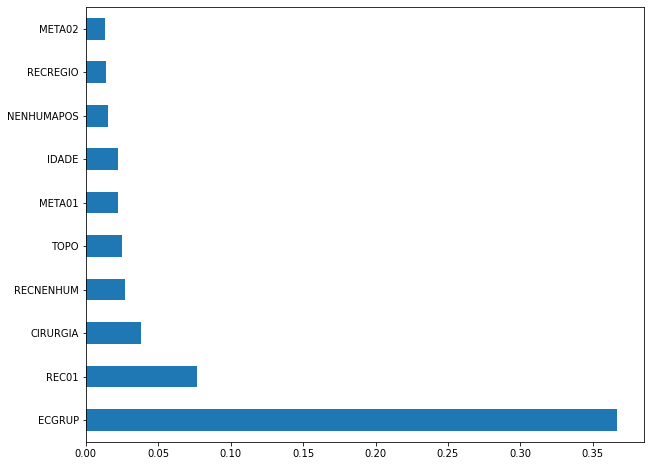

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

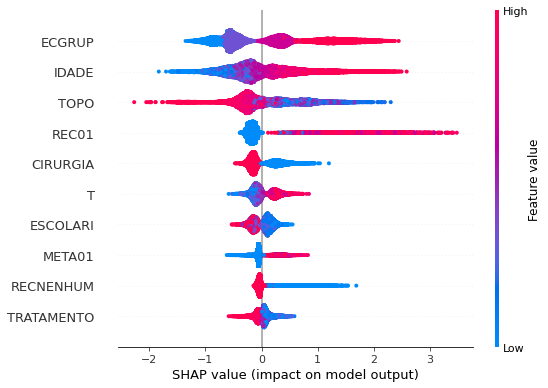

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.04,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.04)

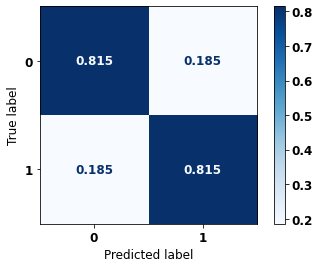


              precision    recall  f1-score   support

           0       0.79      0.81      0.80     12072
           1       0.83      0.81      0.82     13732

    accuracy                           0.81     25804
   macro avg       0.81      0.81      0.81     25804
weighted avg       0.82      0.81      0.81     25804



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

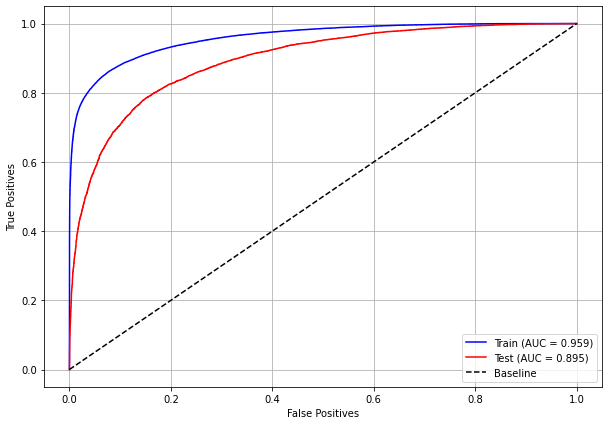

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

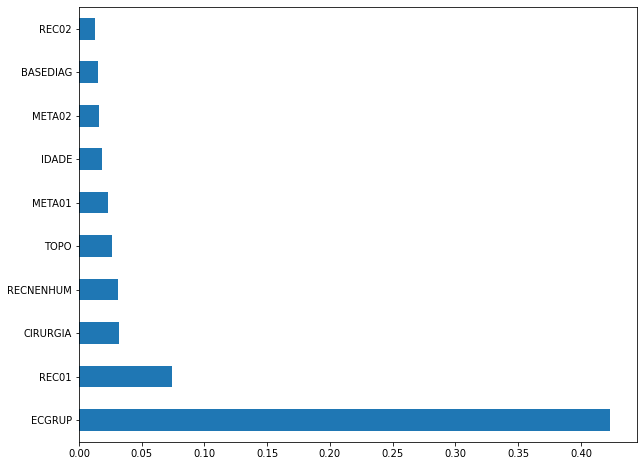

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

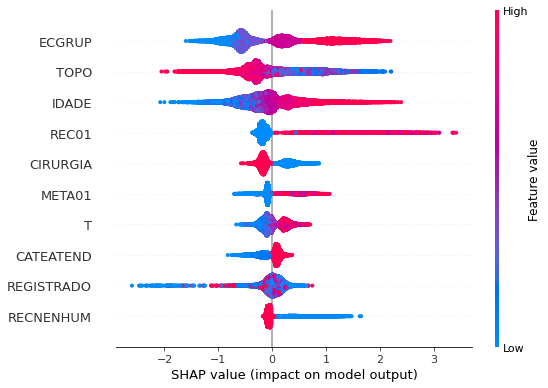

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=1.7)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.7)

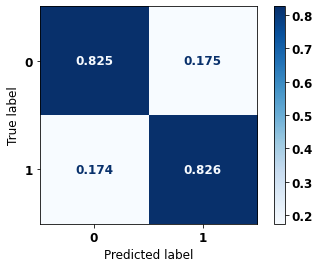


              precision    recall  f1-score   support

           0       0.87      0.83      0.85     19067
           1       0.76      0.83      0.79     12975

    accuracy                           0.83     32042
   macro avg       0.82      0.83      0.82     32042
weighted avg       0.83      0.83      0.83     32042



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

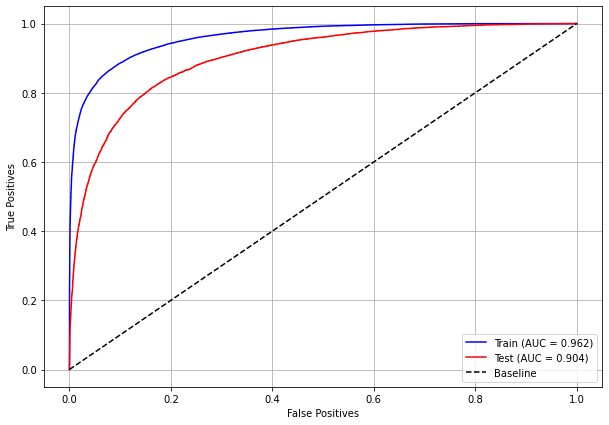

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

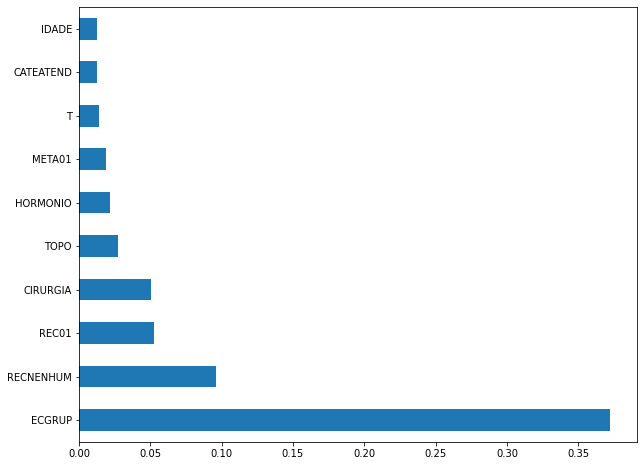

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage. Following we have `RECNENHUM`, `REC01` and `CIRURGIA`. 

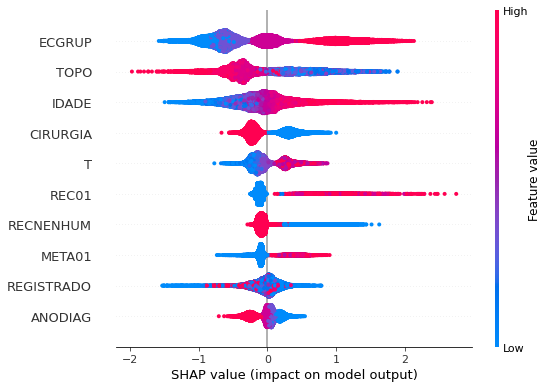

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=3.15)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=3.15)

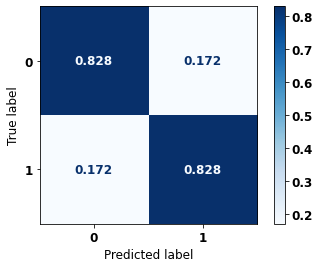


              precision    recall  f1-score   support

           0       0.92      0.83      0.87     17594
           1       0.66      0.83      0.73      6967

    accuracy                           0.83     24561
   macro avg       0.79      0.83      0.80     24561
weighted avg       0.85      0.83      0.83     24561



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, for SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.


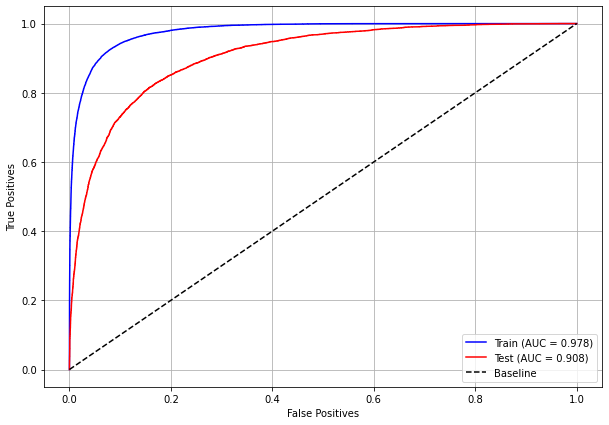

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

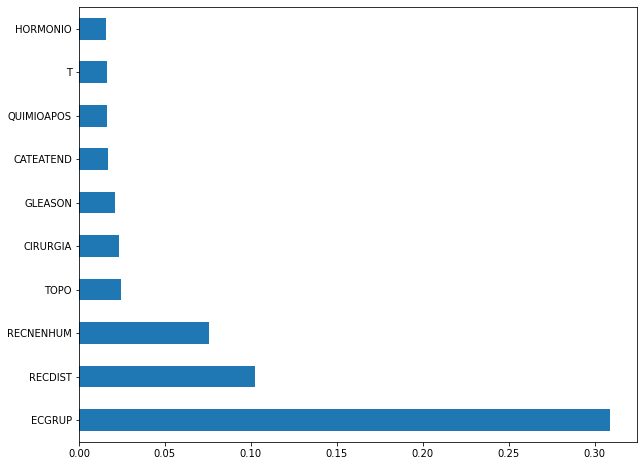

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECDIST`, `RECNENHUM` and `TOPO`.



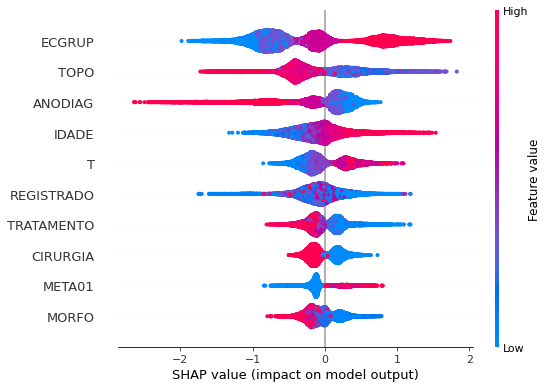

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [307]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=0.7074,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=0.7074)

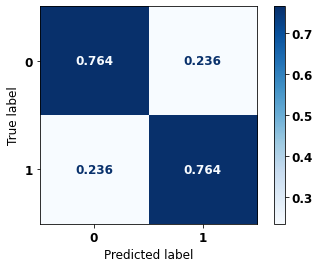


              precision    recall  f1-score   support

           0       0.66      0.76      0.71       326
           1       0.84      0.76      0.80       539

    accuracy                           0.76       865
   macro avg       0.75      0.76      0.76       865
weighted avg       0.77      0.76      0.77       865



In [308]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 76% of accuracy.

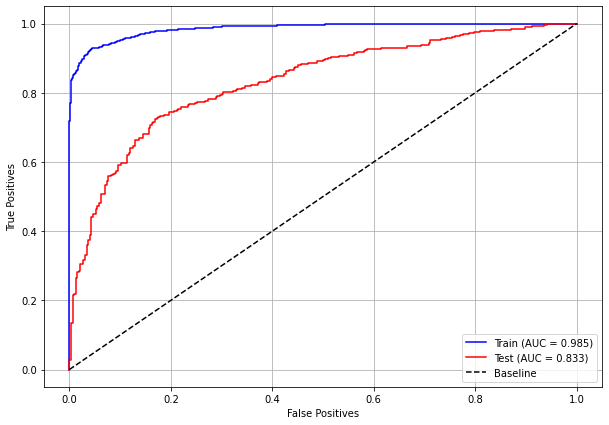

In [309]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

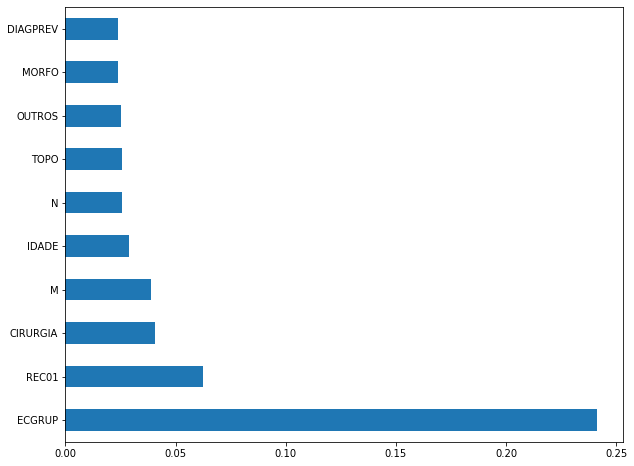

In [310]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `M`.

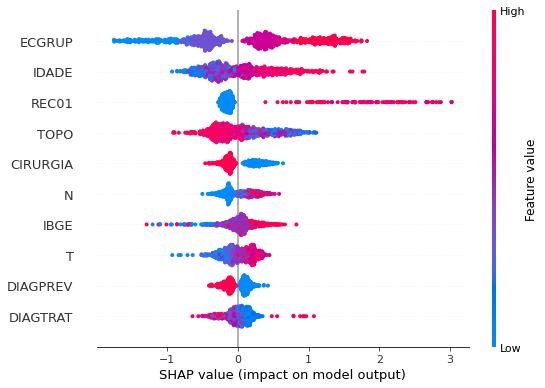

In [311]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [316]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=0.95,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=0.95)

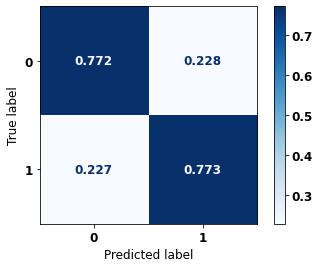


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       615
           1       0.77      0.77      0.77       617

    accuracy                           0.77      1232
   macro avg       0.77      0.77      0.77      1232
weighted avg       0.77      0.77      0.77      1232



In [317]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 77% of accuracy.

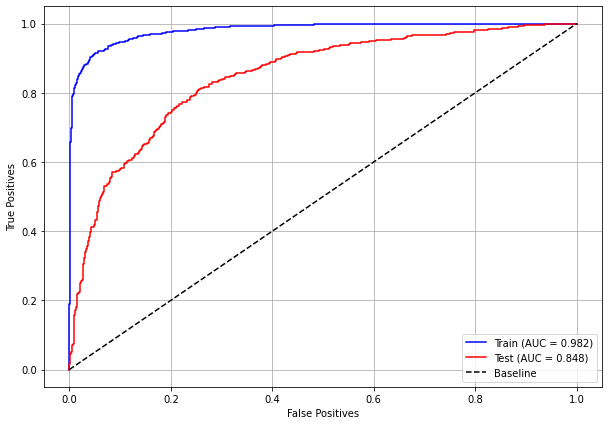

In [318]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

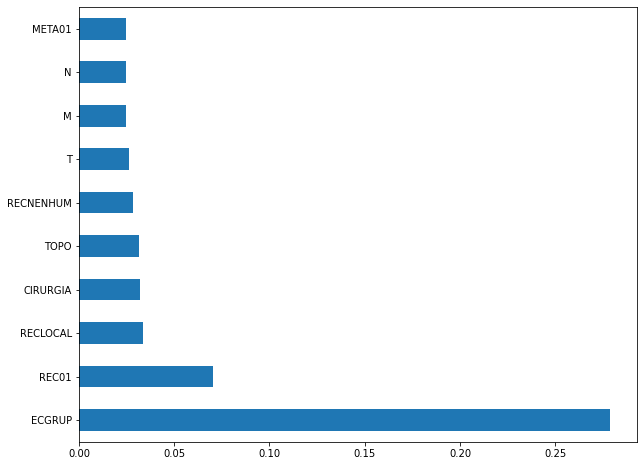

In [319]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `RECLOCAL` and `CIRURGIA`.

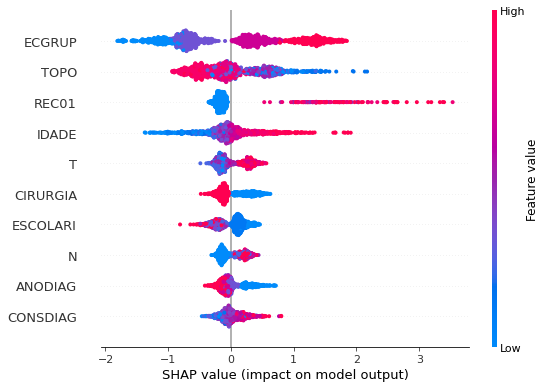

In [320]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [331]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.57,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.57)

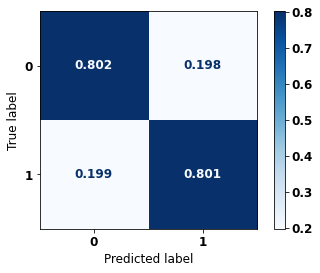


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       843
           1       0.76      0.80      0.78       670

    accuracy                           0.80      1513
   macro avg       0.80      0.80      0.80      1513
weighted avg       0.80      0.80      0.80      1513



In [332]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 80% of accuracy.

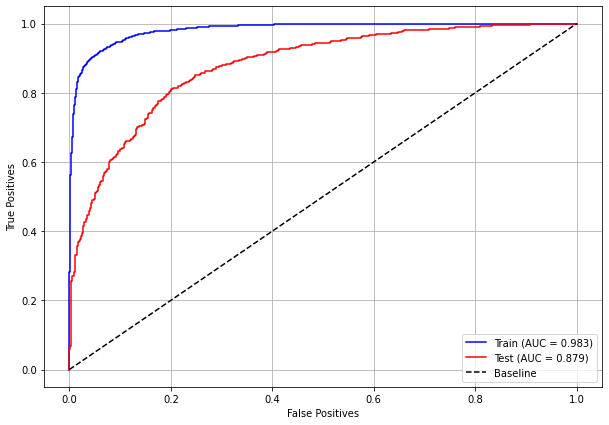

In [333]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

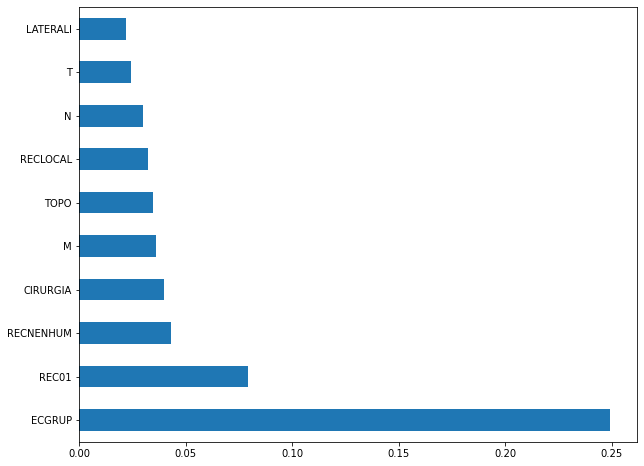

In [334]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `RECNENHUM` and `CIRURGIA`.

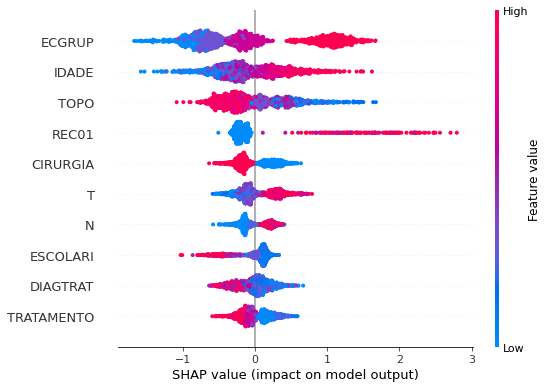

In [335]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [356]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=2.756,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.756)

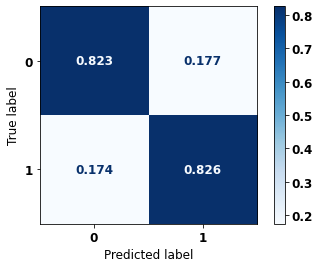


              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1319
           1       0.71      0.83      0.77       705

    accuracy                           0.82      2024
   macro avg       0.81      0.82      0.81      2024
weighted avg       0.83      0.82      0.83      2024



In [357]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

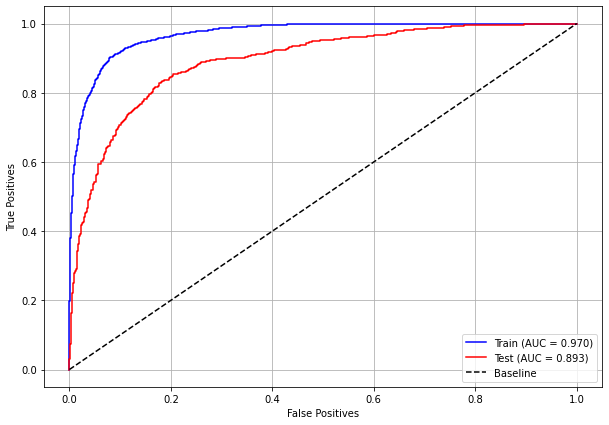

In [358]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

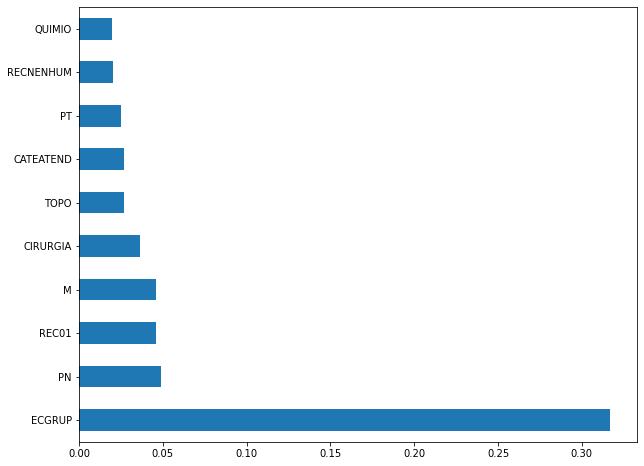

In [359]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `PN`, `REC01` and `M`.

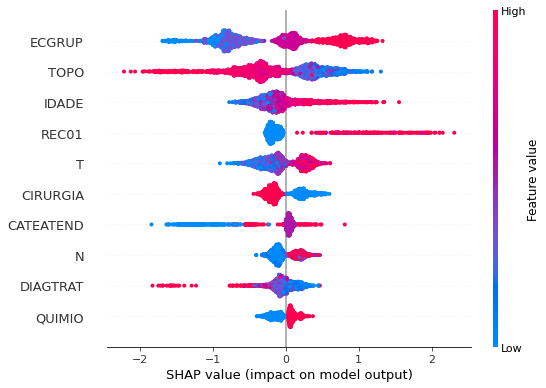

In [360]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [371]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=2.75,
                                   random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.75)

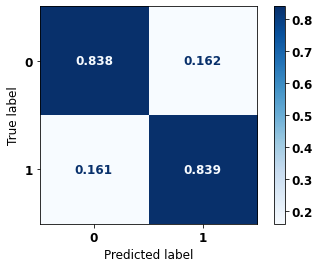


              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1558
           1       0.63      0.84      0.72       504

    accuracy                           0.84      2062
   macro avg       0.78      0.84      0.80      2062
weighted avg       0.86      0.84      0.85      2062



In [372]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 84% of accuracy.

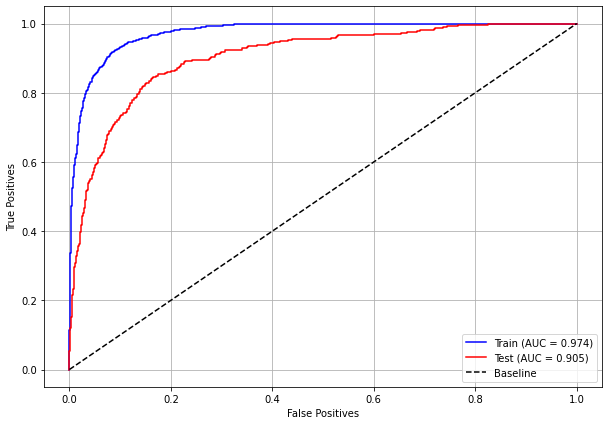

In [373]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

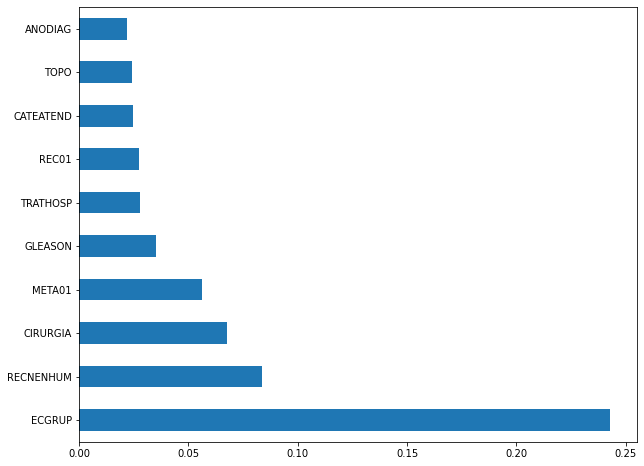

In [374]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `RECNENHUM`, `CIRURGIA` and `META01`.

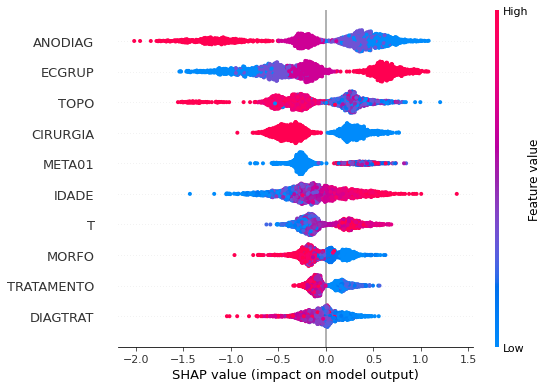

In [375]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ANODIAG column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

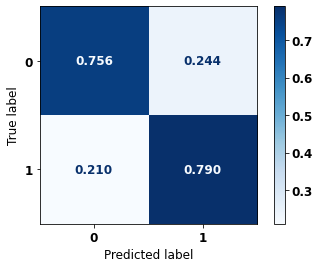


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      7548
           1       0.84      0.79      0.81     11842

    accuracy                           0.78     19390
   macro avg       0.77      0.77      0.77     19390
weighted avg       0.78      0.78      0.78     19390



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

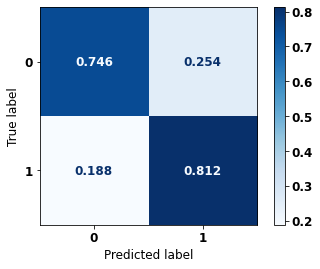


              precision    recall  f1-score   support

           0       0.78      0.75      0.76     12072
           1       0.78      0.81      0.80     13732

    accuracy                           0.78     25804
   macro avg       0.78      0.78      0.78     25804
weighted avg       0.78      0.78      0.78     25804



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

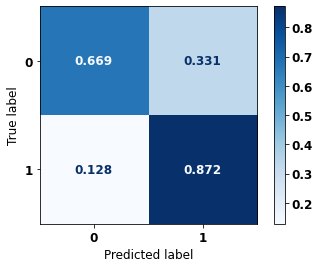


              precision    recall  f1-score   support

           0       0.88      0.67      0.76     19067
           1       0.64      0.87      0.74     12975

    accuracy                           0.75     32042
   macro avg       0.76      0.77      0.75     32042
weighted avg       0.79      0.75      0.75     32042



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

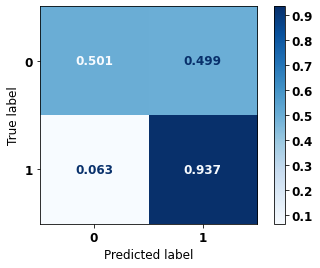


              precision    recall  f1-score   support

           0       0.95      0.50      0.66     17594
           1       0.43      0.94      0.59      6967

    accuracy                           0.62     24561
   macro avg       0.69      0.72      0.62     24561
weighted avg       0.80      0.62      0.64     24561



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

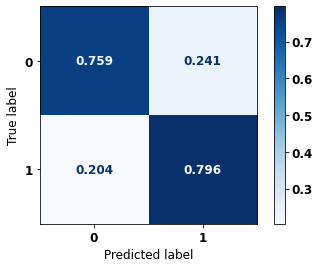


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      7548
           1       0.84      0.80      0.82     11842

    accuracy                           0.78     19390
   macro avg       0.77      0.78      0.77     19390
weighted avg       0.79      0.78      0.78     19390



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

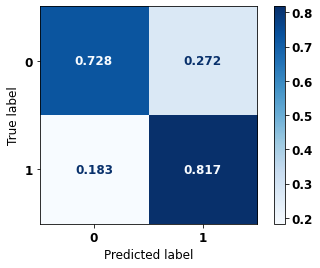


              precision    recall  f1-score   support

           0       0.78      0.73      0.75     12072
           1       0.77      0.82      0.79     13732

    accuracy                           0.78     25804
   macro avg       0.78      0.77      0.77     25804
weighted avg       0.78      0.78      0.77     25804



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

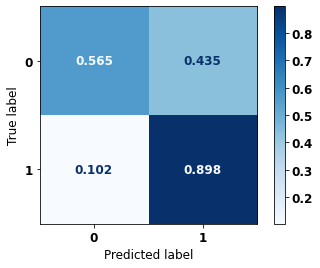


              precision    recall  f1-score   support

           0       0.89      0.56      0.69     19067
           1       0.58      0.90      0.71     12975

    accuracy                           0.70     32042
   macro avg       0.74      0.73      0.70     32042
weighted avg       0.77      0.70      0.70     32042



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

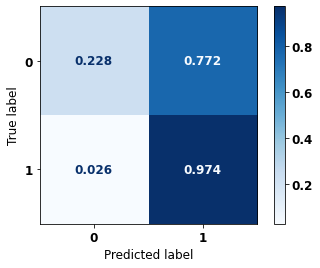


              precision    recall  f1-score   support

           0       0.96      0.23      0.37     17594
           1       0.33      0.97      0.50      6967

    accuracy                           0.44     24561
   macro avg       0.65      0.60      0.43     24561
weighted avg       0.78      0.44      0.40     24561



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

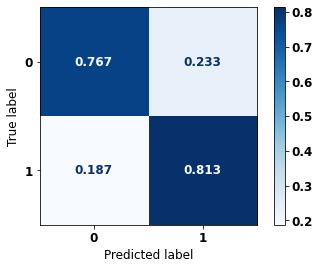


              precision    recall  f1-score   support

           0       0.78      0.77      0.77     12072
           1       0.80      0.81      0.81     13732

    accuracy                           0.79     25804
   macro avg       0.79      0.79      0.79     25804
weighted avg       0.79      0.79      0.79     25804



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

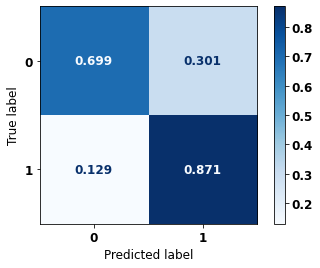


              precision    recall  f1-score   support

           0       0.89      0.70      0.78     19067
           1       0.66      0.87      0.75     12975

    accuracy                           0.77     32042
   macro avg       0.78      0.78      0.77     32042
weighted avg       0.80      0.77      0.77     32042



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

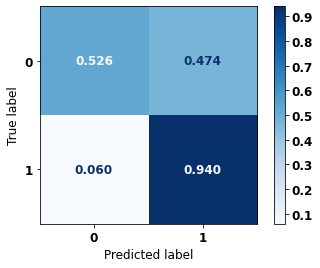


              precision    recall  f1-score   support

           0       0.96      0.53      0.68     17594
           1       0.44      0.94      0.60      6967

    accuracy                           0.64     24561
   macro avg       0.70      0.73      0.64     24561
weighted avg       0.81      0.64      0.66     24561



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

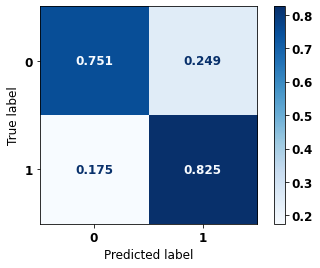


              precision    recall  f1-score   support

           0       0.79      0.75      0.77     12072
           1       0.79      0.83      0.81     13732

    accuracy                           0.79     25804
   macro avg       0.79      0.79      0.79     25804
weighted avg       0.79      0.79      0.79     25804



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

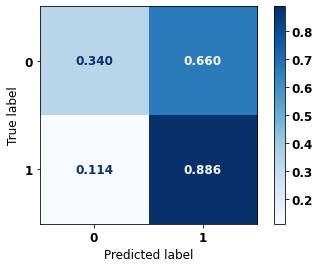


              precision    recall  f1-score   support

           0       0.81      0.34      0.48     19067
           1       0.48      0.89      0.62     12975

    accuracy                           0.56     32042
   macro avg       0.65      0.61      0.55     32042
weighted avg       0.68      0.56      0.54     32042



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

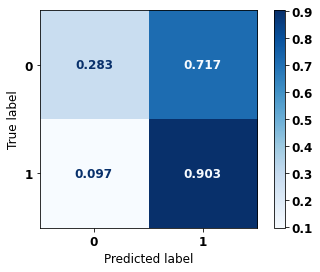


              precision    recall  f1-score   support

           0       0.88      0.28      0.43     17594
           1       0.33      0.90      0.49      6967

    accuracy                           0.46     24561
   macro avg       0.61      0.59      0.46     24561
weighted avg       0.73      0.46      0.44     24561



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

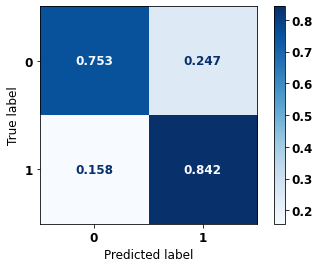


              precision    recall  f1-score   support

           0       0.87      0.75      0.81     19067
           1       0.70      0.84      0.76     12975

    accuracy                           0.79     32042
   macro avg       0.79      0.80      0.79     32042
weighted avg       0.80      0.79      0.79     32042



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

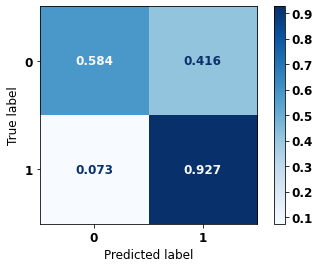


              precision    recall  f1-score   support

           0       0.95      0.58      0.72     17594
           1       0.47      0.93      0.62      6967

    accuracy                           0.68     24561
   macro avg       0.71      0.76      0.67     24561
weighted avg       0.82      0.68      0.70     24561



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

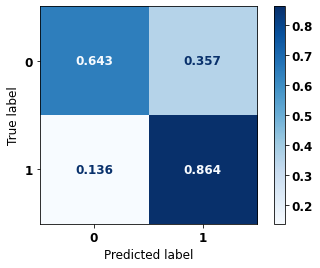


              precision    recall  f1-score   support

           0       0.87      0.64      0.74     19067
           1       0.62      0.86      0.72     12975

    accuracy                           0.73     32042
   macro avg       0.75      0.75      0.73     32042
weighted avg       0.77      0.73      0.73     32042



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

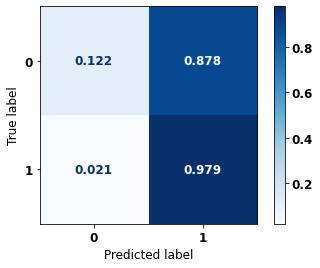


              precision    recall  f1-score   support

           0       0.94      0.12      0.22     17594
           1       0.31      0.98      0.47      6967

    accuracy                           0.37     24561
   macro avg       0.62      0.55      0.34     24561
weighted avg       0.76      0.37      0.29     24561



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

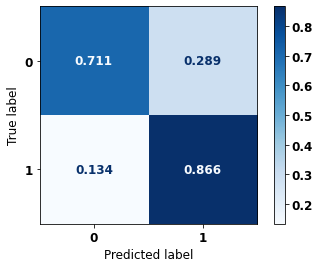


              precision    recall  f1-score   support

           0       0.93      0.71      0.81     17594
           1       0.54      0.87      0.67      6967

    accuracy                           0.76     24561
   macro avg       0.74      0.79      0.74     24561
weighted avg       0.82      0.76      0.77     24561



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

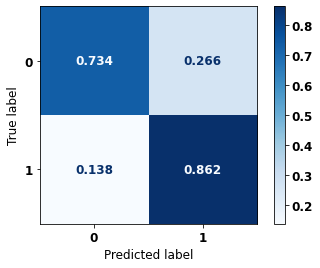


              precision    recall  f1-score   support

           0       0.93      0.73      0.82     17594
           1       0.56      0.86      0.68      6967

    accuracy                           0.77     24561
   macro avg       0.75      0.80      0.75     24561
weighted avg       0.83      0.77      0.78     24561



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

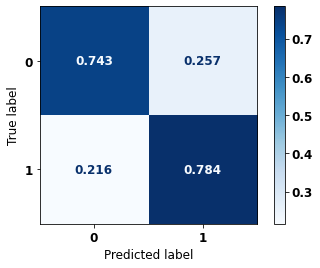


              precision    recall  f1-score   support

           0       0.77      0.74      0.76       615
           1       0.75      0.78      0.77       617

    accuracy                           0.76      1232
   macro avg       0.76      0.76      0.76      1232
weighted avg       0.76      0.76      0.76      1232



In [376]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

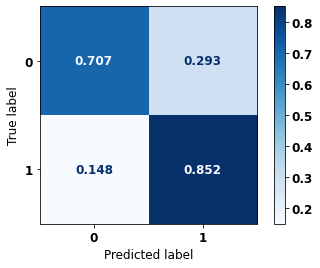


              precision    recall  f1-score   support

           0       0.86      0.71      0.78       843
           1       0.70      0.85      0.77       670

    accuracy                           0.77      1513
   macro avg       0.78      0.78      0.77      1513
weighted avg       0.79      0.77      0.77      1513



In [377]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

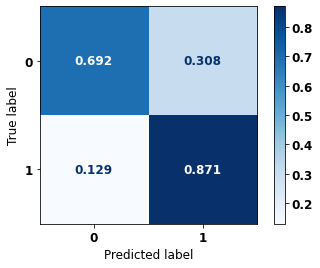


              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1319
           1       0.60      0.87      0.71       705

    accuracy                           0.75      2024
   macro avg       0.76      0.78      0.75      2024
weighted avg       0.80      0.75      0.76      2024



In [378]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

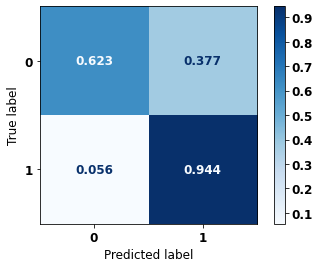


              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1558
           1       0.45      0.94      0.61       504

    accuracy                           0.70      2062
   macro avg       0.71      0.78      0.68      2062
weighted avg       0.84      0.70      0.72      2062



In [379]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

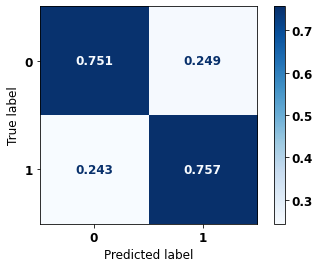


              precision    recall  f1-score   support

           0       0.75      0.75      0.75       615
           1       0.75      0.76      0.76       617

    accuracy                           0.75      1232
   macro avg       0.75      0.75      0.75      1232
weighted avg       0.75      0.75      0.75      1232



In [380]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

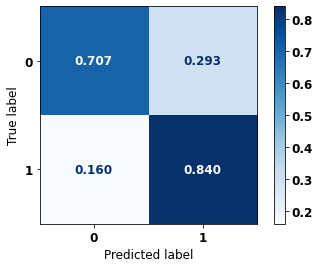


              precision    recall  f1-score   support

           0       0.85      0.71      0.77       843
           1       0.70      0.84      0.76       670

    accuracy                           0.77      1513
   macro avg       0.77      0.77      0.77      1513
weighted avg       0.78      0.77      0.77      1513



In [381]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

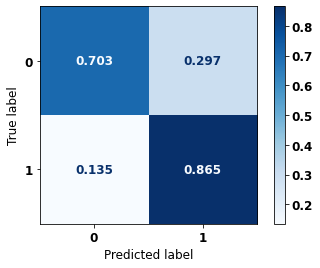


              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1319
           1       0.61      0.87      0.71       705

    accuracy                           0.76      2024
   macro avg       0.76      0.78      0.75      2024
weighted avg       0.80      0.76      0.77      2024



In [382]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

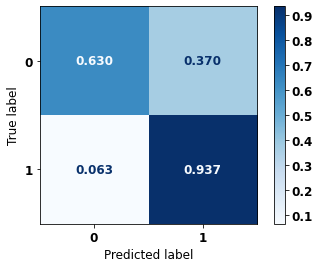


              precision    recall  f1-score   support

           0       0.97      0.63      0.76      1558
           1       0.45      0.94      0.61       504

    accuracy                           0.70      2062
   macro avg       0.71      0.78      0.69      2062
weighted avg       0.84      0.70      0.73      2062



In [383]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

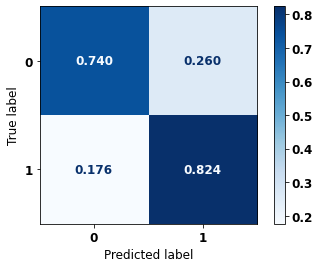


              precision    recall  f1-score   support

           0       0.84      0.74      0.79       843
           1       0.72      0.82      0.77       670

    accuracy                           0.78      1513
   macro avg       0.78      0.78      0.78      1513
weighted avg       0.79      0.78      0.78      1513



In [384]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

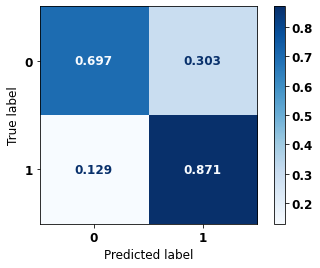


              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1319
           1       0.61      0.87      0.71       705

    accuracy                           0.76      2024
   macro avg       0.76      0.78      0.75      2024
weighted avg       0.80      0.76      0.76      2024



In [385]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

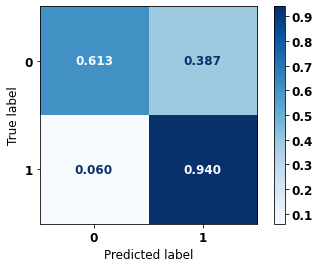


              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1558
           1       0.44      0.94      0.60       504

    accuracy                           0.69      2062
   macro avg       0.70      0.78      0.68      2062
weighted avg       0.84      0.69      0.71      2062



In [386]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

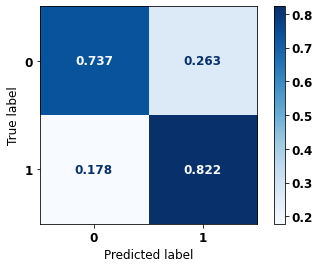


              precision    recall  f1-score   support

           0       0.84      0.74      0.78       843
           1       0.71      0.82      0.76       670

    accuracy                           0.77      1513
   macro avg       0.78      0.78      0.77      1513
weighted avg       0.78      0.77      0.78      1513



In [387]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

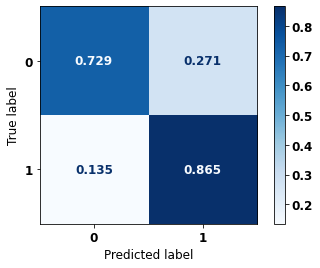


              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1319
           1       0.63      0.87      0.73       705

    accuracy                           0.78      2024
   macro avg       0.77      0.80      0.77      2024
weighted avg       0.81      0.78      0.78      2024



In [388]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

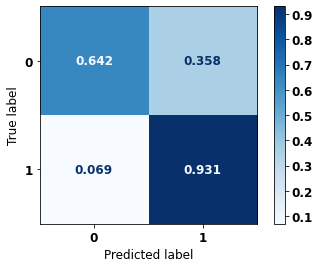


              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1558
           1       0.46      0.93      0.61       504

    accuracy                           0.71      2062
   macro avg       0.71      0.79      0.69      2062
weighted avg       0.84      0.71      0.73      2062



In [389]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

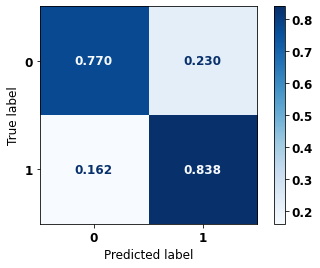


              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1319
           1       0.66      0.84      0.74       705

    accuracy                           0.79      2024
   macro avg       0.78      0.80      0.78      2024
weighted avg       0.82      0.79      0.80      2024



In [390]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

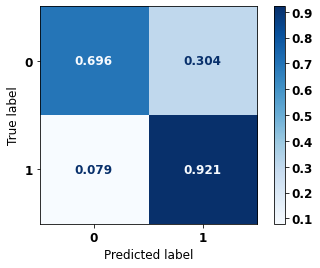


              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1558
           1       0.49      0.92      0.64       504

    accuracy                           0.75      2062
   macro avg       0.73      0.81      0.73      2062
weighted avg       0.85      0.75      0.77      2062



In [391]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

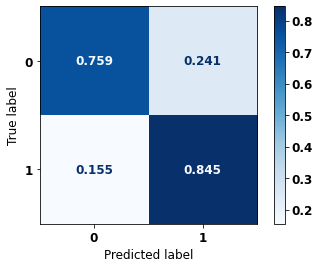


              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1319
           1       0.65      0.85      0.74       705

    accuracy                           0.79      2024
   macro avg       0.78      0.80      0.78      2024
weighted avg       0.81      0.79      0.79      2024



In [392]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

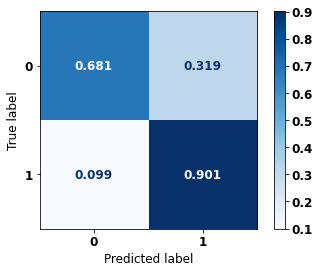


              precision    recall  f1-score   support

           0       0.95      0.68      0.80      1558
           1       0.48      0.90      0.62       504

    accuracy                           0.73      2062
   macro avg       0.72      0.79      0.71      2062
weighted avg       0.84      0.73      0.75      2062



In [393]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

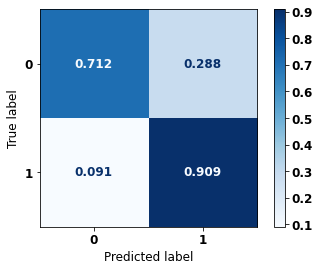


              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1558
           1       0.50      0.91      0.65       504

    accuracy                           0.76      2062
   macro avg       0.73      0.81      0.73      2062
weighted avg       0.85      0.76      0.78      2062



In [394]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

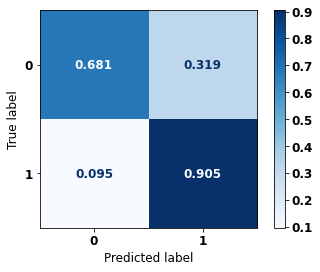


              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1558
           1       0.48      0.90      0.63       504

    accuracy                           0.74      2062
   macro avg       0.72      0.79      0.71      2062
weighted avg       0.84      0.74      0.75      2062



In [395]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fifth approach**

Approach with grouped years, using only morphologies with final digit equal to 3 and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [396]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'RECCONS', 'RECDIAG', 'RECTRAT', 'ULTICONS', 
             'ULTIDIAG', 'ULTITRAT', 'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ob_com_rec',
             'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO', 'EC', 'obito_cancer']

lb = 'obito_geral'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, random_state=seed)

In [ ]:
X_trainSP_01_04, X_testSP_01_04, y_trainSP_01_04, y_testSP_01_04, feat_SP_01_04 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2001, 
                                                                                                last_year=2004, random_state=seed)

In [ ]:
X_trainSP_02_05, X_testSP_02_05, y_trainSP_02_05, y_testSP_02_05, feat_SP_02_05 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2002, 
                                                                                                last_year=2005, random_state=seed)

In [ ]:
X_trainSP_03_06, X_testSP_03_06, y_trainSP_03_06, y_testSP_03_06, feat_SP_03_06 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2003, 
                                                                                                last_year=2006, random_state=seed)

In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, random_state=seed)

In [ ]:
X_trainSP_05_08, X_testSP_05_08, y_trainSP_05_08, y_testSP_05_08, feat_SP_05_08 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2005, 
                                                                                                last_year=2008, random_state=seed)

In [ ]:
X_trainSP_06_09, X_testSP_06_09, y_trainSP_06_09, y_testSP_06_09, feat_SP_06_09 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2006, 
                                                                                                last_year=2009, random_state=seed)

In [ ]:
X_trainSP_07_10, X_testSP_07_10, y_trainSP_07_10, y_testSP_07_10, feat_SP_07_10 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2007, 
                                                                                                last_year=2010, random_state=seed)

In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, random_state=seed)

In [ ]:
X_trainSP_09_12, X_testSP_09_12, y_trainSP_09_12, y_testSP_09_12, feat_SP_09_12 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2009, 
                                                                                                last_year=2012, random_state=seed)

In [ ]:
X_trainSP_10_13, X_testSP_10_13, y_trainSP_10_13, y_testSP_10_13, feat_SP_10_13 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2010, 
                                                                                                last_year=2013, random_state=seed)

In [ ]:
X_trainSP_11_14, X_testSP_11_14, y_trainSP_11_14, y_testSP_11_14, feat_SP_11_14 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2011, 
                                                                                                last_year=2014, random_state=seed)

In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, random_state=seed)

In [ ]:
X_trainSP_13_16, X_testSP_13_16, y_trainSP_13_16, y_testSP_13_16, feat_SP_13_16 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2013, 
                                                                                                last_year=2016, random_state=seed)

In [ ]:
X_trainSP_14_17, X_testSP_14_17, y_trainSP_14_17, y_testSP_14_17, feat_SP_14_17 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2014, 
                                                                                                last_year=2017, random_state=seed)

In [ ]:
X_trainSP_15_18, X_testSP_15_18, y_trainSP_15_18, y_testSP_15_18, feat_SP_15_18 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2015, 
                                                                                                last_year=2018, random_state=seed)

In [ ]:
X_trainSP_16_19, X_testSP_16_19, y_trainSP_16_19, y_testSP_16_19, feat_SP_16_19 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2019, random_state=seed)

In [ ]:
X_trainSP_17_20, X_testSP_17_20, y_trainSP_17_20, y_testSP_17_20, feat_SP_17_20 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2017, 
                                                                                                last_year=2020, random_state=seed)

In [ ]:
X_trainSP_18_21, X_testSP_18_21, y_trainSP_18_21, y_testSP_18_21, feat_SP_18_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2018, 
                                                                                                last_year=2021, random_state=seed)

### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2000,
                                                                                                last_year=2003, morpho3=True, 
                                                                                                random_state=seed)

In [ ]:
X_trainOS_01_04, X_testOS_01_04, y_trainOS_01_04, y_testOS_01_04, feat_OS_01_04 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2001, 
                                                                                                last_year=2004, random_state=seed)

In [ ]:
X_trainOS_02_05, X_testOS_02_05, y_trainOS_02_05, y_testOS_02_05, feat_OS_02_05 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2002, 
                                                                                                last_year=2005, random_state=seed)

In [ ]:
X_trainOS_03_06, X_testOS_03_06, y_trainOS_03_06, y_testOS_03_06, feat_OS_03_06 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2003, 
                                                                                                last_year=2006, random_state=seed)

In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, random_state=seed)

In [ ]:
X_trainOS_05_08, X_testOS_05_08, y_trainOS_05_08, y_testOS_05_08, feat_OS_05_08 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2005, 
                                                                                                last_year=2008, random_state=seed)

In [ ]:
X_trainOS_06_09, X_testOS_06_09, y_trainOS_06_09, y_testOS_06_09, feat_OS_06_09 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2006, 
                                                                                                last_year=2009, random_state=seed)

In [ ]:
X_trainOS_07_10, X_testOS_07_10, y_trainOS_07_10, y_testOS_07_10, feat_OS_07_10 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2007, 
                                                                                                last_year=2010, random_state=seed)

In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, random_state=seed)

In [ ]:
X_trainOS_09_12, X_testOS_09_12, y_trainOS_09_12, y_testOS_09_12, feat_OS_09_12 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2009, 
                                                                                                last_year=2012, random_state=seed)

In [ ]:
X_trainOS_10_13, X_testOS_10_13, y_trainOS_10_13, y_testOS_10_13, feat_OS_10_13 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2010, 
                                                                                                last_year=2013, random_state=seed)

In [ ]:
X_trainOS_11_14, X_testOS_11_14, y_trainOS_11_14, y_testOS_11_14, feat_OS_11_14 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2011, 
                                                                                                last_year=2014, random_state=seed)

In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, random_state=seed)

In [ ]:
X_trainOS_13_16, X_testOS_13_16, y_trainOS_13_16, y_testOS_13_16, feat_OS_13_16 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2013, 
                                                                                                last_year=2016, random_state=seed)

In [ ]:
X_trainOS_14_17, X_testOS_14_17, y_trainOS_14_17, y_testOS_14_17, feat_OS_14_17 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2014, 
                                                                                                last_year=2017, random_state=seed)

In [ ]:
X_trainOS_15_18, X_testOS_15_18, y_trainOS_15_18, y_testOS_15_18, feat_OS_15_18 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2015, 
                                                                                                last_year=2018, random_state=seed)

In [ ]:
X_trainOS_16_19, X_testOS_16_19, y_trainOS_16_19, y_testOS_16_19, feat_OS_16_19 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2019, random_state=seed)

In [ ]:
X_trainOS_17_20, X_testOS_17_20, y_trainOS_17_20, y_testOS_17_20, feat_OS_17_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2017, 
                                                                                                last_year=2020, random_state=seed)

## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because even after balancing the data the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, class_weight={0:4_000_000, 1:1})
rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03)

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t3`, and `delta_t2`. The last two being the difference, in days, between treatment and consultation and between treatment and diagnosis, respectively.

In [ ]:
# SP - 2000 to 2003
rf_sp_01_04 = RandomForestClassifier(random_state=seed, class_weight={0:3_800_000, 1:1})
rf_sp_01_04.fit(X_trainSP_01_04, y_trainSP_01_04)

In [ ]:
show_tree(rf_sp_01_04, feat_SP_01_04, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_01_04, y_testSP_01_04, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2001 to 2004, shows a good performance of the model, with 78% of accuracy.


In [ ]:
plot_feat_importances(rf_sp_01_04, feat_SP_01_04)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t3`, and `delta_t1`. The last two being the difference, in days, between treatment and consultation and between diagnosis and consultation, respectively.

In [ ]:
# SP - 2000 to 2003
rf_sp_02_05 = RandomForestClassifier(random_state=seed, class_weight={0:4_000_000, 1:1})
rf_sp_02_05.fit(X_trainSP_02_05, y_trainSP_02_05)

In [ ]:
show_tree(rf_sp_02_05, feat_SP_02_05, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_02_05, y_testSP_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2002 to 2005, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(rf_sp_02_05, feat_SP_02_05)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t3`, and `delta_t1`. The last two being the difference, in days, between treatment and consultation and between diagnosis and consultation, respectively.

In [ ]:
# SP - 2000 to 2003
rf_sp_03_06 = RandomForestClassifier(random_state=seed, class_weight={0:3_500_000, 1:1})
rf_sp_03_06.fit(X_trainSP_03_06, y_trainSP_03_06)

In [ ]:
show_tree(rf_sp_03_06, feat_SP_03_06, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2002 to 2005, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(rf_sp_03_06, feat_SP_03_06)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t3`, and `delta_t1`. The last two being the difference, in days, between treatment and consultation and between diagnosis and consultation, respectively.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, class_weight={0:3_300_000, 1:1})
rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07)

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `IDADE`, `IBGE` `delta_t1` and `delta_t3`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

In [ ]:
# SP - 2004 to 2007
rf_sp_05_08 = RandomForestClassifier(random_state=seed, class_weight={0:3_000_000, 1:1})
rf_sp_05_08.fit(X_trainSP_05_08, y_trainSP_05_08)

In [ ]:
show_tree(rf_sp_05_08, feat_SP_05_08, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_05_08, feat_SP_05_08)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

In [ ]:
# SP - 2004 to 2007
rf_sp_06_09 = RandomForestClassifier(random_state=seed, class_weight={0:2_700_000, 1:1})
rf_sp_06_09.fit(X_trainSP_06_09, y_trainSP_06_09)

In [ ]:
show_tree(rf_sp_06_09, feat_SP_06_09)

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_06_09, feat_SP_06_09)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

In [ ]:
# SP - 2004 to 2007
rf_sp_07_10 = RandomForestClassifier(random_state=seed, class_weight={0:2_300_000, 1:1})
rf_sp_07_10.fit(X_trainSP_07_10, y_trainSP_07_10)

In [ ]:
show_tree(rf_sp_07_10, feat_SP_07_10)

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_07_10, feat_SP_07_10)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:3_500_000})
rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11)

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuray.

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2008 to 2011
rf_sp_09_12 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:3_500_000})
rf_sp_09_12.fit(X_trainSP_09_12, y_trainSP_09_12)

In [ ]:
show_tree(rf_sp_09_12, feat_SP_09_12, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuray.

In [ ]:
plot_feat_importances(rf_sp_09_12, feat_SP_09_12)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`.

In [ ]:
# SP - 2008 to 2011
rf_sp_10_13 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:3_900_000})
rf_sp_10_13.fit(X_trainSP_10_13, y_trainSP_10_13)

In [ ]:
show_tree(rf_sp_10_13, feat_SP_10_13)

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuray.

In [ ]:
plot_feat_importances(rf_sp_10_13, feat_SP_10_13)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`.

In [ ]:
# SP - 2008 to 2011
rf_sp_11_14 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_300_000})
rf_sp_11_14.fit(X_trainSP_11_14, y_trainSP_11_14)

In [ ]:
show_tree(rf_sp_11_14, feat_SP_11_14)

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuray.

In [ ]:
plot_feat_importances(rf_sp_11_14, feat_SP_11_14)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_400_000})
rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15)

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model with 81% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`.

In [ ]:
# SP - 2012 to 2015
rf_sp_13_16 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_300_000})
rf_sp_13_16.fit(X_trainSP_13_16, y_trainSP_13_16)

In [ ]:
show_tree(rf_sp_13_16, feat_SP_13_16)

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_13_16, feat_SP_13_16)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`. 

In [ ]:
# SP - 2012 to 2015
rf_sp_14_17 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_300_000})
rf_sp_14_17.fit(X_trainSP_14_17, y_trainSP_14_17)

In [ ]:
show_tree(rf_sp_14_17, feat_SP_14_17)

In [ ]:
plot_confusion_matrix(rf_sp_14_17, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_14_17, feat_SP_14_17)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `IBGE`.

In [ ]:
# SP - 2012 to 2015
rf_sp_15_18 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_300_000})
rf_sp_15_18.fit(X_trainSP_15_18, y_trainSP_15_18)

In [ ]:
show_tree(rf_sp_15_18, feat_SP_15_18)

In [ ]:
plot_confusion_matrix(rf_sp_15_18, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_15_18, feat_SP_15_18)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`. 

In [ ]:
# SP - 2016 to 2021
rf_sp_16_19 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_700_000})
rf_sp_16_19.fit(X_trainSP_16_19, y_trainSP_16_19)

In [ ]:
show_tree(rf_sp_16_19, feat_SP_16_19)

In [ ]:
plot_confusion_matrix(rf_sp_16_19, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_16_19, feat_SP_16_19)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE`, and `delta_t3`.



In [ ]:
# SP - 2016 to 2021
rf_sp_17_20 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_800_000})
rf_sp_17_20.fit(X_trainSP_17_20, y_trainSP_17_20)

In [ ]:
show_tree(rf_sp_17_20, feat_SP_17_20)

In [ ]:
plot_confusion_matrix(rf_sp_17_20, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_17_20, feat_SP_17_20)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE`, and `delta_t2`.



In [ ]:
# SP - 2016 to 2021
rf_sp_18_21 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_500_000})
rf_sp_18_21.fit(X_trainSP_18_21, y_trainSP_18_21)

In [ ]:
show_tree(rf_sp_18_21, feat_SP_18_21)

In [ ]:
plot_confusion_matrix(rf_sp_18_21, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(rf_sp_18_21, feat_SP_18_21)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE`, and `delta_t2`.



**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, class_weight={0:3_000_000, 1:1})
rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03)

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 75% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2000 to 2003
rf_fora_01_04 = RandomForestClassifier(random_state=seed, class_weight={0:2_800_000, 1:1})
rf_fora_01_04.fit(X_trainOS_01_04, y_trainOS_01_04)

In [ ]:
show_tree(rf_fora_01_04, feat_OS_01_04)

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_01_04, y_testOS_01_04, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 77% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_01_04, feat_OS_01_04)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2000 to 2003
rf_fora_02_05 = RandomForestClassifier(random_state=seed, class_weight={0:2_800_000, 1:1})
rf_fora_02_05.fit(X_trainOS_02_05, y_trainOS_02_05)

In [ ]:
show_tree(rf_fora_02_05, feat_OS_02_05)

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_02_05, y_testOS_02_05, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 77% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_02_05, feat_OS_02_05)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2000 to 2003
rf_fora_03_06 = RandomForestClassifier(random_state=seed, class_weight={0:3_400_000, 1:1})
rf_fora_03_06.fit(X_trainOS_03_06, y_trainOS_03_06)

In [ ]:
show_tree(rf_fora_03_06, feat_OS_03_06)

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_03_06, y_testOS_03_06, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 80% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_03_06, feat_OS_03_06)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, class_weight={0:1_500_000, 1:1})
rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07)

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`.

In [ ]:
# Other states - 2000 to 2003
rf_fora_05_08 = RandomForestClassifier(random_state=seed, class_weight={0:800_000, 1:1})
rf_fora_05_08.fit(X_trainOS_05_08, y_trainOS_05_08)

In [ ]:
show_tree(rf_fora_05_08, feat_OS_05_08, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_05_08, y_testOS_05_08, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 80% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_05_08, feat_OS_05_08)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2000 to 2003
rf_fora_06_09 = RandomForestClassifier(random_state=seed, class_weight={0:50_000, 1:1})
rf_fora_06_09.fit(X_trainOS_06_09, y_trainOS_06_09)

In [ ]:
show_tree(rf_fora_06_09, feat_OS_06_09)

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_06_09, y_testOS_06_09, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 79% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_06_09, feat_OS_06_09)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2000 to 2003
rf_fora_07_10 = RandomForestClassifier(random_state=seed, class_weight={0:50_000, 1:1})
rf_fora_07_10.fit(X_trainOS_07_10, y_trainOS_07_10)

In [ ]:
show_tree(rf_fora_07_10, feat_OS_07_10)

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_07_10, y_testOS_07_10, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix with 82% of accuracy.

In [ ]:
plot_feat_importances(rf_fora_07_10, feat_OS_07_10)

> The four most important features in the model were `IDADE`, `delta_t3`, `IBGE` and `delta_t1`. `delta_t3` is the difference, in days, between treatment and diagnosis and `delta_t1` is the difference between diagnosis and consultation.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:6_000_000})
rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11)

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 78% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_09_12 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_500_000})
rf_fora_09_12.fit(X_trainOS_09_12, y_trainOS_09_12)

In [ ]:
show_tree(rf_fora_09_12, feat_OS_09_12)

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_09_12, y_testOS_09_12,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 79% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_09_12, feat_OS_09_12)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_10_13 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_000_000})
rf_fora_10_13.fit(X_trainOS_10_13, y_trainOS_10_13)

In [ ]:
show_tree(rf_fora_10_13, feat_OS_10_13, max_depth=3)

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_10_13, y_testOS_10_13,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_10_13, feat_OS_10_13)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_11_14 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_700_000})
rf_fora_11_14.fit(X_trainOS_11_14, y_trainOS_11_14)

In [ ]:
show_tree(rf_fora_11_14, feat_OS_11_14, max_depth=4)

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_11_14, y_testOS_11_14,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 79% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_11_14, feat_OS_11_14)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_700_000})
rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15)

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 80% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `IBGE`, `delta_t1`, `delta_t3` and `IDADE`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_13_16 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_700_000})
rf_fora_13_16.fit(X_trainOS_13_16, y_trainOS_13_16)

In [ ]:
show_tree(rf_fora_13_16, feat_OS_13_16)

In [ ]:
plot_confusion_matrix(rf_fora_13_16, X_testOS_13_16, y_testOS_13_16,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 80% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_13_16, feat_OS_13_16)

> The four most important features in the model were `IBGE`, `delta_t1`, `delta_t3` and `IDADE`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_14_17 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:5_300_000})
rf_fora_14_17.fit(X_trainOS_14_17, y_trainOS_14_17)

In [ ]:
show_tree(rf_fora_14_17, feat_OS_14_17)

In [ ]:
plot_confusion_matrix(rf_fora_14_17, X_testOS_14_17, y_testOS_14_17,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 82% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_14_17, feat_OS_14_17)

> The four most important features in the model were `IBGE`, `delta_t1`, `delta_t3` and `IDADE`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_15_18 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_700_000})
rf_fora_15_18.fit(X_trainOS_15_18, y_trainOS_15_18)

In [ ]:
show_tree(rf_fora_15_18, feat_OS_15_18)

In [ ]:
plot_confusion_matrix(rf_fora_15_18, X_testOS_15_18, y_testOS_15_18,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 82% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_15_18, feat_OS_15_18)

> The four most important features in the model were `IBGE`, `delta_t1`, `delta_t3` and `IDADE`.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_19 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_300_000})
rf_fora_16_19.fit(X_trainOS_16_19, y_trainOS_16_19)

In [ ]:
show_tree(rf_fora_16_19, feat_OS_16_19)

In [ ]:
plot_confusion_matrix(rf_fora_16_19, X_testOS_16_19, y_testOS_16_19,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 81% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_16_19, feat_OS_16_19)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`.

In [ ]:
# Other states - 2016 to 2020
rf_fora_17_20 = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:4_700_000})
rf_fora_17_20.fit(X_trainOS_17_20, y_trainOS_17_20)

In [ ]:
show_tree(rf_fora_17_20, feat_OS_17_20)

In [ ]:
plot_confusion_matrix(rf_fora_17_20, X_testOS_17_20, y_testOS_17_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 81% of accuracy.


In [ ]:
plot_feat_importances(rf_fora_17_20, feat_OS_17_20)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.35)
xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, with 78% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `TOPOGRUP` and `M`.

In [ ]:
# SP - 2000 to 2003
xgb_sp_01_04 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.4)
xgb_sp_01_04.fit(X_trainSP_01_04, y_trainSP_01_04)

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_01_04, y_testSP_01_04,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, with 78% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_01_04, feat_SP_01_04)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `TOPOGRUP` and `M`.

In [ ]:
# SP - 2000 to 2003
xgb_sp_02_05 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.5)
xgb_sp_02_05.fit(X_trainSP_02_05, y_trainSP_02_05)

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_02_05, y_testSP_02_05,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, with 78% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_02_05, feat_SP_02_05)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `TOPOGRUP` and `M`.

In [ ]:
# SP - 2000 to 2003
xgb_sp_03_06 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.53)
xgb_sp_03_06.fit(X_trainSP_03_06, y_trainSP_03_06)

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_03_06, y_testSP_03_06,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a good performance of the model, with 78% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_03_06, feat_SP_03_06)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `TOPOGRUP` and `M`.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.58)
xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `TOPOGRUP` and `RECNENHUM`. 

In [ ]:
# SP - 2004 to 2007
xgb_sp_05_08 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.68)
xgb_sp_05_08.fit(X_trainSP_05_08, y_trainSP_05_08)

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_05_08, y_testSP_05_08,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_05_08, feat_SP_05_08)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `TOPOGRUP` and `RECNENHUM`. 

In [ ]:
# SP - 2004 to 2007
xgb_sp_06_09 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.8)
xgb_sp_06_09.fit(X_trainSP_06_09, y_trainSP_06_09)

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_06_09, y_testSP_06_09,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_06_09, feat_SP_06_09)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `TOPOGRUP` and `RECNENHUM`. 

In [ ]:
# SP - 2004 to 2007
xgb_sp_07_10 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.9)
xgb_sp_07_10.fit(X_trainSP_07_10, y_trainSP_07_10)

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_07_10, y_testSP_07_10,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_07_10, feat_SP_07_10)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `TOPOGRUP` and `RECNENHUM`. 

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1.2,
                                 random_state=seed)
xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `M` and `TOPOGRUP`. 

In [ ]:
# SP - 2008 to 2011
xgb_sp_09_12 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1.4,
                                 random_state=seed)
xgb_sp_09_12.fit(X_trainSP_09_12, y_trainSP_09_12)

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_09_12, y_testSP_09_12,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_09_12, feat_SP_09_12)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `M` and `TOPOGRUP`. 

In [ ]:
# SP - 2008 to 2011
xgb_sp_10_13 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1.7,
                                 random_state=seed)
xgb_sp_10_13.fit(X_trainSP_10_13, y_trainSP_10_13)

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_10_13, y_testSP_10_13,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_10_13, feat_SP_10_13)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `M` and `TOPOGRUP`. 

In [ ]:
# SP - 2008 to 2011
xgb_sp_11_14 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=2,
                                 random_state=seed)
xgb_sp_11_14.fit(X_trainSP_11_14, y_trainSP_11_14)

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_11_14, y_testSP_11_14,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_11_14, feat_SP_11_14)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `M` and `TOPOGRUP`. 

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=2.5)
xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `RECNENHUM`, `TOPOGRUP` and `CIRURGIA`. 

In [ ]:
# SP - 2012 to 2015
xgb_sp_13_16 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=2.7)
xgb_sp_13_16.fit(X_trainSP_13_16, y_trainSP_13_16)

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_13_16, y_testSP_13_16,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_13_16, feat_SP_13_16)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `RECNENHUM`, `TOPOGRUP` and `CIRURGIA`. 

In [ ]:
# SP - 2012 to 2015
xgb_sp_14_17 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=3.5)
xgb_sp_14_17.fit(X_trainSP_14_17, y_trainSP_14_17)

In [ ]:
plot_confusion_matrix(xgb_sp_14_17, X_testSP_14_17, y_testSP_14_17,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_14_17, feat_SP_14_17)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `RECNENHUM`, `TOPOGRUP` and `CIRURGIA`. 

In [ ]:
# SP - 2012 to 2015
xgb_sp_15_18 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=5.5)
xgb_sp_15_18.fit(X_trainSP_15_18, y_trainSP_15_18)

In [ ]:
plot_confusion_matrix(xgb_sp_15_18, X_testSP_15_18, y_testSP_15_18,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_sp_15_18, feat_SP_15_18)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `RECNENHUM`, `TOPOGRUP` and `CIRURGIA`. 

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_19 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=11)
xgb_sp_16_19.fit(X_trainSP_16_19, y_trainSP_16_19)

In [ ]:
plot_confusion_matrix(xgb_sp_16_19, X_testSP_16_19, y_testSP_16_19,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_16_19, feat_SP_16_19)

> The four most important features were `ECGRUP`, `RECNENHUM`, `TOPOGRUP` and `GLEASON`.

In [ ]:
# SP - 2016 to 2021
xgb_sp_17_20 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=30)
xgb_sp_17_20.fit(X_trainSP_17_20, y_trainSP_17_20)

In [ ]:
plot_confusion_matrix(xgb_sp_17_20, X_testSP_17_20, y_testSP_17_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_17_20, feat_SP_17_20)

> The four most important features were `ECGRUP`, `RECNENHUM`, `TOPOGRUP` and `GLEASON`.

In [ ]:
# SP - 2016 to 2021
xgb_sp_18_21 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=250)
xgb_sp_18_21.fit(X_trainSP_18_21, y_trainSP_18_21)

In [ ]:
plot_confusion_matrix(xgb_sp_18_21, X_testSP_18_21, y_testSP_18_21,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 81% of accuracy.


In [ ]:
plot_feat_importances(xgb_sp_18_21, feat_SP_18_21)

> The four most important features were `ECGRUP`, `RECNENHUM`, `TOPOGRUP` and `GLEASON`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.45,
                                   random_state=seed)
xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 75% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

In [ ]:
# Other states - 2000 to 2003
xgb_fora_01_04 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.75,
                                   random_state=seed)
xgb_fora_01_04.fit(X_trainOS_01_04, y_trainOS_01_04)

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_01_04, y_testOS_01_04,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 75% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_01_04, feat_OS_01_04)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

In [ ]:
# Other states - 2000 to 2003
xgb_fora_02_05 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.75,
                                   random_state=seed)
xgb_fora_02_05.fit(X_trainOS_02_05, y_trainOS_02_05)

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_02_05, y_testOS_02_05,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 75% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_02_05, feat_OS_02_05)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

In [ ]:
# Other states - 2000 to 2003
xgb_fora_03_06 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.75,
                                   random_state=seed)
xgb_fora_03_06.fit(X_trainOS_03_06, y_trainOS_03_06)

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_03_06, y_testOS_03_06,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 75% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_03_06, feat_OS_03_06)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1.5,
                                   random_state=seed)
xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 76% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `G` and `RECNENHUM`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_05_08 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=2.1,
                                   random_state=seed)
xgb_fora_05_08.fit(X_trainOS_05_08, y_trainOS_05_08)

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_05_08, y_testOS_05_08,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 76% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_05_08, feat_OS_05_08)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `G` and `RECNENHUM`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_06_09 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=2,
                                   random_state=seed)
xgb_fora_06_09.fit(X_trainOS_06_09, y_trainOS_06_09)

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_06_09, y_testOS_06_09,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 76% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_06_09, feat_OS_06_09)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `G` and `RECNENHUM`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_07_10 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=3,
                                   random_state=seed)
xgb_fora_07_10.fit(X_trainOS_07_10, y_trainOS_07_10)

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_07_10, y_testOS_07_10,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 76% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_07_10, feat_OS_07_10)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `G` and `RECNENHUM`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=3.5,
                                   random_state=seed)
xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 79% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `RECNENHUM` and `HABILIT2`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_09_12 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=3.5,
                                   random_state=seed)
xgb_fora_09_12.fit(X_trainOS_09_12, y_trainOS_09_12)

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_09_12, y_testOS_09_12,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 79% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_09_12, feat_OS_09_12)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `RECNENHUM` and `HABILIT2`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_10_13 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=10,
                                   random_state=seed)
xgb_fora_10_13.fit(X_trainOS_10_13, y_trainOS_10_13)

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_10_13, y_testOS_10_13,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 79% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_10_13, feat_OS_10_13)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `RECNENHUM` and `HABILIT2`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_11_14 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=12,
                                   random_state=seed)
xgb_fora_11_14.fit(X_trainOS_11_14, y_trainOS_11_14)

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_11_14, y_testOS_11_14,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 79% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_11_14, feat_OS_11_14)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `RECNENHUM` and `HABILIT2`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=25,
                                   random_state=seed)
xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `CATEATEND`, `ECGRUP`, `HORMOAPOS` and `RADIOAPOS`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_13_16 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=20,
                                   random_state=seed)
xgb_fora_13_16.fit(X_trainOS_13_16, y_trainOS_13_16)

In [ ]:
plot_confusion_matrix(xgb_fora_13_16, X_testOS_13_16, y_testOS_13_16,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_13_16, feat_OS_13_16)

> The four most important features were `CATEATEND`, `ECGRUP`, `HORMOAPOS` and `RADIOAPOS`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_14_17 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=22,
                                   random_state=seed)
xgb_fora_14_17.fit(X_trainOS_14_17, y_trainOS_14_17)

In [ ]:
plot_confusion_matrix(xgb_fora_14_17, X_testOS_14_17, y_testOS_14_17,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_14_17, feat_OS_14_17)

> The four most important features were `CATEATEND`, `ECGRUP`, `HORMOAPOS` and `RADIOAPOS`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_15_18 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=22,
                                   random_state=seed)
xgb_fora_15_18.fit(X_trainOS_15_18, y_trainOS_15_18)

In [ ]:
plot_confusion_matrix(xgb_fora_15_18, X_testOS_15_18, y_testOS_15_18,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_15_18, feat_OS_15_18)

> The four most important features were `CATEATEND`, `ECGRUP`, `HORMOAPOS` and `RADIOAPOS`.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_19 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=30,
                                  random_state=seed)
xgb_fora_16_19.fit(X_trainOS_16_19, y_trainOS_16_19)

In [ ]:
plot_confusion_matrix(xgb_fora_16_19, X_testOS_16_19, y_testOS_16_19,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows a good performance, with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_16_19, feat_OS_16_19)

> The four most important features were `ECGRUP`, `CIRURAPOS`, `GLEASON` and `RADIOAPOS`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_17_20 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=250,
                                   random_state=seed)
xgb_fora_17_20.fit(X_trainOS_17_20, y_trainOS_17_20)

In [ ]:
plot_confusion_matrix(xgb_fora_17_20, X_testOS_17_20, y_testOS_17_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 82% of accuracy.

In [ ]:
plot_feat_importances(xgb_fora_17_20, feat_OS_17_20)

> The four most important features were `CATEATEND`, `ECGRUP`, `HORMOAPOS` and `RADIOAPOS`.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_01_04, y_testSP_01_04, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_02_05, y_testSP_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2001 to 2004**

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_02_05, y_testSP_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_01_04, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2002 to 2005**

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_02_05, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2003 to 2006**

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_03_06, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2005 to 2008**

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_05_08, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2006 to 2009**

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_06_09, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2007 to 2010**

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_07_10, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2009 to 2012**

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_09_12, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2010 to 2013**

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_10_13, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2011 to 2014**

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_11_14, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2013 to 2016**

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_13_16, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2014 to 2017**

In [ ]:
plot_confusion_matrix(rf_sp_14_17, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_14_17, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_14_17, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_14_17, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2015 to 2018**

In [ ]:
plot_confusion_matrix(rf_sp_15_18, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_15_18, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_15_18, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2016 to 2019**

In [ ]:
plot_confusion_matrix(rf_sp_16_19, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_sp_16_19, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2017 to 2020**

In [ ]:
plot_confusion_matrix(rf_sp_17_20, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_01_04, y_testSP_01_04, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_02_05, y_testSP_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2001 to 2004**

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_02_05, y_testSP_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_01_04, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2002 to 2005**

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_03_06, y_testSP_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_02_05, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2003 to 2006**

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_03_06, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_05_08, y_testSP_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2005 to 2008**

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_06_09, y_testSP_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_05_08, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2006 to 2009**

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_07_10, y_testSP_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_06_09, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2007 to 2010**

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_07_10, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_09_12, y_testSP_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2009 to 2012**

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_10_13, y_testSP_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_09_12, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2010 to 2013**

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_11_14, y_testSP_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_10_13, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2011 to 2014**

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_11_14, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_13_16, y_testSP_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2013 to 2016**

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_14_17, y_testSP_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_13_16, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2014 to 2017**

In [ ]:
plot_confusion_matrix(xgb_sp_14_17, X_testSP_15_18, y_testSP_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_14_17, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_14_17, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_14_17, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2015 to 2018**

In [ ]:
plot_confusion_matrix(xgb_sp_15_18, X_testSP_16_19, y_testSP_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_15_18, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_15_18, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2016 to 2019**

In [ ]:
plot_confusion_matrix(xgb_sp_16_19, X_testSP_17_20, y_testSP_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_sp_16_19, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2017 to 2020**

In [ ]:
plot_confusion_matrix(xgb_sp_17_20, X_testSP_18_21, y_testSP_18_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_01_04, y_testOS_01_04, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_02_05, y_testOS_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2001 to 2004**

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_02_05, y_testOS_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_01_04, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2002 to 2005**

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_02_05, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2003 to 2006**

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_03_06, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2005 to 2008**

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_05_08, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2006 to 2009**

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_06_09, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2007 to 2010**

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_07_10, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2009 to 2012**

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_09_12, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2010 to 2013**

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_10_13, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2011 to 2014**

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_11_14, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2013 to 2016**

In [ ]:
plot_confusion_matrix(rf_fora_13_16, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_13_16, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_13_16, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_13_16, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2014 to 2017**

In [ ]:
plot_confusion_matrix(rf_fora_14_17, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_14_17, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_14_17, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2015 to 2018**

In [ ]:
plot_confusion_matrix(rf_fora_15_18, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(rf_fora_15_18, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2016 to 2019**

In [ ]:
plot_confusion_matrix(rf_fora_16_19, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2000 to 2003**

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_01_04, y_testOS_01_04, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_02_05, y_testOS_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2001 to 2004**

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_02_05, y_testOS_02_05, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_01_04, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2002 to 2005**

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_03_06, y_testOS_03_06, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_02_05, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2003 to 2006**

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_03_06, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2004 to 2007**

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_05_08, y_testOS_05_08, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2005 to 2008**

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_06_09, y_testOS_06_09, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_05_08, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2006 to 2009**

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_07_10, y_testOS_07_10, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_06_09, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2007 to 2010**

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_07_10, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2008 to 2011**

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_09_12, y_testOS_09_12, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2009 to 2012**

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_10_13, y_testOS_10_13, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_09_12, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2010 to 2013**

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_11_14, y_testOS_11_14, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_10_13, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2011 to 2014**

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_11_14, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2012 to 2015**

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_13_16, y_testOS_13_16, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2013 to 2016**

In [ ]:
plot_confusion_matrix(xgb_fora_13_16, X_testOS_14_17, y_testOS_14_17, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_13_16, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_13_16, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_13_16, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2014 to 2017**

In [ ]:
plot_confusion_matrix(xgb_fora_14_17, X_testOS_15_18, y_testOS_15_18, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_14_17, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_14_17, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2015 to 2018**

In [ ]:
plot_confusion_matrix(xgb_fora_15_18, X_testOS_16_19, y_testOS_16_19, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

In [ ]:
plot_confusion_matrix(xgb_fora_15_18, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2016 to 2019**

In [ ]:
plot_confusion_matrix(xgb_fora_16_19, X_testOS_17_20, y_testOS_17_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()